In [18]:
import datetime
import numpy as np
from influxdb import InfluxDBClient

In [19]:
client = InfluxDBClient(host='140.112.42.160', port=23234, database='test_2')

In [20]:
CODE_TO_COUNTRY = {              # country language code to full language name  
        'zh-tw': 'Taiwan',
        'west-eu': 'Europe',
        'west-us': 'West US',
    }

In [21]:
def build_query(t_s, t_e, channel=None, lang=None, loc=None):
    """
    gets all data from month/date to month/(date+1)
    t_s: time start
    t_e: time end 
    lang: stream language
    loc: client location 
    """
    channel = '/.*/' if channel is None else channel
    q = f"SELECT viewer, client_location, ip_list, fq_count, num_edge FROM {channel} WHERE time >= '{t_s}' AND time < '{t_e}'"
    if lang:
        q = f"{q} AND stream_language = '{lang}'"
    if loc:
        q = f"{q} AND client_location = '{loc}'"
    return q

def get_edge_num(result):
    tmp = list()
    transactions = 0
    for (stream, _), points in result.items():
        for point in points:
            edges = point['ip_list'].split(',')
            transactions += sum([int(fq) for fq in point['fq_count'].split(',')])
            for edge in edges:
                if edge not in tmp:
                    tmp.append(edge)
    return set(tmp), transactions

def mean(l):
    return sum(l)/len(l)

def TIMEFMT(t):
    return datetime.datetime.strptime(t, '%Y-%m-%dT%H:%M:%SZ')

Observe the lifetime of servers

In [22]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
sample_time1 = ['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00']
sample_time2 = ['01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00', '11:00:00', '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00', '18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00', '23:59:59']

In [23]:
st = f'2019-10-28T00:00:00Z' 
et = f'2019-11-10T23:59:59Z'
q = build_query(st, et, loc='west-us', lang=None)
result = client.query(q)
server_set, _ = get_edge_num(result)
server_list = list(server_set)
print(len(server_set))
print(len(server_list))

197
197


In [17]:
server_lifetime_table = np.zeros((len(server_list), len(date)*len(sample_time1)), dtype=int)
server_number_per_hour = np.zeros((len(date)*len(sample_time1),), dtype=int)
print(server_lifetime_table.shape)
for i, dat in enumerate(date):
    for j, (t1, t2) in enumerate(zip(sample_time1, sample_time2)):
        st = f'2019-{dat}T{t1}Z'
        et = f'2019-{dat}T{t2}Z'
        q = build_query(st, et, loc='west-us', lang=None)
        result = client.query(q)
        server_set, _ = get_edge_num(result)
        print(dat, t1, t2, server_set)
        server_number_per_hour[i*24+j] = len(server_set)
        for k, server in enumerate(server_list):
            if server in server_set:
                server_lifetime_table[k, i*24+j] = 1
print(server_lifetime_table)

(197, 336)
10-28 00:00:00 01:00:00 {'52.223.228.102', '52.223.247.89', '52.223.228.96', '52.223.247.86', '52.223.228.106', '52.223.228.24', '99.181.96.133', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.123', '52.223.247.152', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.170', '99.181.96.125', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '99.181.96.120', '52.223.228.30', '52.223.247.171', '52.223.228.68', '99.181.96.126', '52.223.247.76', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '99.181.96.108', '52.223.247.167', '99.181.96.110', '52.223.247.146', '52.223.247.99', '52.223.247.229', '52.223.227.243', '52.223.247.38', '52.223.228.5', '52.223.247.135', '52.223.247.101', '52.223.247.210', '99.181.96.100', '52.223.247.73', '52.223.228.118', '52.223.228.85', '52.223.228.107', '52.223.228.89', '99.181.96.111', '52.223.228.97', '52.223.228.59', '52.223.227.23

10-28 08:00:00 09:00:00 {'52.223.228.5', '52.223.228.99', '52.223.228.18', '52.223.228.102', '99.181.96.109', '52.223.228.37', '99.181.96.135', '99.181.96.100', '52.223.228.118', '52.223.228.85', '52.223.228.103', '52.223.228.96', '99.181.96.189', '52.223.228.93', '99.181.96.163', '52.223.228.107', '52.223.228.26', '52.223.228.89', '99.181.96.111', '52.223.228.97', '52.223.228.92', '52.223.228.24', '99.181.96.164', '52.223.228.106', '99.181.96.167', '99.181.96.122', '52.223.227.232', '52.223.228.27', '99.181.96.133', '99.181.96.134', '52.223.228.90', '52.223.227.234', '52.223.227.248', '52.223.228.59', '52.223.228.123', '99.181.96.120', '99.181.96.106', '52.223.228.28', '52.223.228.30', '52.223.228.13', '52.223.228.68', '52.223.228.10', '52.223.228.125', '99.181.96.126', '99.181.96.115', '52.223.228.98', '52.223.228.95', '52.223.228.94', '52.223.228.9', '52.223.227.230', '52.223.228.25', '99.181.96.118', '52.223.228.29', '52.223.225.214', '52.223.227.240', '99.181.96.107', '99.181.96.1

10-28 15:00:00 16:00:00 {'52.223.226.26', '52.223.228.5', '52.223.228.18', '52.223.228.99', '52.223.228.102', '52.223.228.37', '52.223.228.118', '52.223.228.85', '52.223.228.103', '52.223.228.96', '52.223.228.93', '52.223.228.27', '52.223.228.26', '52.223.228.107', '52.223.228.89', '52.223.228.97', '52.223.228.92', '52.223.228.106', '52.223.228.24', '52.223.227.232', '52.223.228.90', '52.223.227.248', '52.223.228.59', '52.223.227.234', '52.223.228.123', '52.223.228.28', '52.223.228.30', '52.223.228.13', '52.223.228.68', '52.223.228.10', '52.223.228.125', '52.223.228.98', '52.223.228.95', '52.223.228.94', '52.223.228.9', '52.223.227.230', '52.223.228.25', '52.223.228.29', '52.223.227.240', '52.223.227.241', '52.223.228.7', '52.223.228.122', '52.223.228.87', '52.223.228.4', '52.223.227.243', '52.223.228.17', '52.223.227.219', '52.223.228.8', '52.223.228.40', '52.223.228.52'}
10-28 16:00:00 17:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.228.96', '52.223.228.106', '5

10-28 23:00:00 23:59:59 {'52.223.228.102', '52.223.228.96', '52.223.247.86', '52.223.228.106', '52.223.228.24', '99.181.96.133', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.123', '52.223.247.152', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.170', '99.181.96.125', '52.223.228.99', '52.223.228.37', '52.223.228.93', '52.223.228.27', '99.181.96.164', '52.223.228.30', '52.223.247.171', '52.223.228.68', '99.181.96.126', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '99.181.96.110', '52.223.227.243', '52.223.228.5', '52.223.247.211', '52.223.247.237', '99.181.96.100', '52.223.228.118', '52.223.228.85', '52.223.228.107', '52.223.228.89', '99.181.96.111', '52.223.228.97', '52.223.227.234', '52.223.228.59', '99.181.96.106', '52.223.228.125', '99.181.96.118', '52.223.227.241', '52.223.228.7', '52.223.228.4', '99.181.96.165', '52.223.247.63', '52.223.247.92', '52.223.228.94', '52.223.228.18', '52.223.247.119', '99.181.96.135', '52.223.24

10-29 06:00:00 07:00:00 {'52.223.228.5', '52.223.228.99', '52.223.228.18', '52.223.228.102', '52.223.228.37', '52.223.228.118', '52.223.228.85', '52.223.228.103', '52.223.228.96', '52.223.228.93', '52.223.228.40', '52.223.228.26', '52.223.228.107', '52.223.228.27', '52.223.228.89', '52.223.228.97', '52.223.228.92', '52.223.228.106', '52.223.228.24', '52.223.227.232', '52.223.228.90', '52.223.228.59', '52.223.228.49', '52.223.227.234', '52.223.227.248', '52.223.228.123', '52.223.228.28', '52.223.228.30', '52.223.228.13', '52.223.228.68', '52.223.228.10', '52.223.228.125', '52.223.228.98', '52.223.228.95', '52.223.228.9', '52.223.227.230', '52.223.228.25', '52.223.228.29', '52.223.227.240', '52.223.227.241', '52.223.228.7', '52.223.228.122', '52.223.228.87', '52.223.228.4', '52.223.227.243', '52.223.228.17', '52.223.227.219', '52.223.228.8', '52.223.228.94', '52.223.228.52'}
10-29 07:00:00 08:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.112', '52.223.247.111', '52.223.247.130', 

10-29 13:00:00 14:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.112', '52.223.247.111', '52.223.247.130', '52.223.228.96', '52.223.247.86', '52.223.228.106', '52.223.228.24', '52.223.247.150', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.152', '52.223.247.40', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.120', '52.223.247.165', '52.223.225.137', '52.223.247.170', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.225.221', '52.223.247.42', '52.223.225.159', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '52.223.247.113', '52.223.247.178', '99.181.96.120', '52.223.247.171', '52.223.228.30', '52.223.228.68', '99.181.96.126', '52.223.247.76', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '52.223.247.167', '99.181.96.110', '99.181.96.108', '52.223.247.99', '52.223.247.146', '52.223.247.229', '52.223.227.243', '52.223.247.38', '52.223.228.5', '5

10-29 18:00:00 19:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.111', '52.223.228.96', '52.223.247.86', '52.223.228.24', '52.223.228.106', '52.223.247.150', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.248.235', '52.223.228.123', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.165', '52.223.247.120', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.247.42', '52.223.228.93', '52.223.228.27', '52.223.228.30', '52.223.247.171', '52.223.228.68', '52.223.228.95', '52.223.228.9', '52.223.227.240', '52.223.247.167', '52.223.227.243', '52.223.228.5', '52.223.247.211', '52.223.247.237', '52.223.247.73', '52.223.228.118', '52.223.228.85', '52.223.228.107', '52.223.228.89', '52.223.228.97', '52.223.247.95', '52.223.227.234', '52.223.228.59', '52.223.228.125', '52.223.247.169', '52.223.227.241', '52.223.228.7', '52.223.247.93', '52.223.228.4', '52.223.247.63', '52.223.247.92', '52.223.228.94', '52.223.228.18', '52.223.247.119', '52.2

10-30 03:00:00 04:00:00 {'52.223.228.5', '52.223.228.18', '52.223.228.99', '52.223.228.102', '52.223.228.37', '52.223.228.118', '52.223.228.85', '52.223.228.103', '52.223.228.96', '52.223.228.93', '52.223.228.107', '52.223.228.26', '52.223.228.27', '52.223.228.89', '52.223.228.97', '52.223.228.92', '52.223.228.24', '52.223.228.106', '52.223.227.232', '52.223.228.90', '52.223.227.234', '52.223.228.49', '52.223.227.248', '52.223.228.59', '52.223.228.123', '52.223.228.28', '52.223.228.30', '52.223.228.13', '52.223.228.68', '52.223.228.125', '52.223.228.10', '52.223.228.98', '52.223.228.95', '52.223.228.94', '52.223.228.9', '52.223.227.230', '52.223.228.25', '52.223.228.29', '52.223.227.240', '52.223.227.241', '52.223.228.7', '52.223.228.122', '52.223.228.87', '52.223.228.4', '52.223.227.243', '52.223.227.219', '52.223.228.17', '52.223.228.8', '52.223.228.40', '52.223.228.52'}
10-30 04:00:00 05:00:00 {'52.223.228.5', '52.223.228.18', '52.223.228.99', '52.223.228.102', '52.223.247.210', '52

10-30 10:00:00 11:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.112', '52.223.247.111', '52.223.228.96', '52.223.247.86', '52.223.228.24', '52.223.228.106', '52.223.247.150', '99.181.96.133', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.40', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.120', '52.223.247.165', '52.223.247.170', '99.181.96.125', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '52.223.247.113', '52.223.247.178', '99.181.96.120', '52.223.228.30', '52.223.247.171', '52.223.228.68', '99.181.96.126', '52.223.247.76', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '99.181.96.108', '99.181.96.110', '52.223.247.167', '52.223.247.99', '52.223.247.146', '52.223.247.229', '52.223.227.243', '52.223.228.5', '52.223.247.135', '52.223.247.101', '52.223.247.210', '99.181.96.100', '52.223.247.73', '52.

10-30 15:00:00 16:00:00 {'52.223.228.5', '52.223.228.18', '52.223.228.99', '52.223.228.102', '52.223.228.37', '52.223.228.118', '52.223.228.85', '52.223.228.103', '52.223.228.96', '52.223.228.93', '52.223.228.27', '52.223.228.26', '52.223.228.107', '52.223.228.89', '52.223.228.97', '52.223.228.92', '52.223.228.24', '52.223.228.106', '52.223.227.232', '52.223.228.90', '52.223.227.248', '52.223.228.59', '52.223.228.49', '52.223.227.234', '52.223.228.123', '52.223.228.28', '52.223.228.30', '52.223.228.13', '52.223.228.68', '52.223.228.125', '52.223.228.10', '52.223.228.98', '52.223.228.95', '52.223.228.94', '52.223.227.230', '52.223.228.9', '52.223.228.25', '52.223.228.29', '52.223.227.240', '52.223.227.241', '52.223.228.7', '52.223.228.122', '52.223.228.87', '52.223.228.4', '52.223.227.243', '52.223.228.17', '52.223.227.219', '52.223.228.8', '52.223.228.40', '52.223.228.52'}
10-30 16:00:00 17:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.112', '52.223.247.111', '

10-30 22:00:00 23:00:00 {'52.223.228.5', '52.223.228.18', '52.223.228.99', '52.223.228.102', '52.223.228.37', '52.223.228.118', '52.223.228.85', '52.223.228.103', '52.223.228.96', '52.223.228.93', '52.223.228.40', '52.223.228.27', '52.223.228.107', '52.223.228.26', '52.223.228.89', '52.223.228.97', '52.223.228.92', '52.223.228.24', '52.223.228.106', '52.223.227.232', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.227.234', '52.223.228.59', '52.223.228.123', '52.223.228.28', '52.223.228.30', '52.223.228.13', '52.223.228.68', '52.223.228.125', '52.223.228.10', '52.223.228.98', '52.223.228.95', '52.223.228.9', '52.223.227.230', '52.223.228.25', '52.223.228.29', '52.223.227.240', '52.223.227.241', '52.223.228.7', '52.223.228.122', '52.223.228.87', '52.223.228.4', '52.223.227.243', '52.223.227.219', '52.223.228.17', '52.223.228.8', '52.223.228.94', '52.223.228.52'}
10-30 23:00:00 23:59:59 {'52.223.228.5', '52.223.228.99', '52.223.228.18', '52.223.228.102', '52.223.228.37', '52.

10-31 08:00:00 09:00:00 {'52.223.228.5', '52.223.228.18', '52.223.228.99', '52.223.228.102', '52.223.228.37', '52.223.228.118', '52.223.228.85', '52.223.228.103', '52.223.228.96', '52.223.228.93', '52.223.228.40', '52.223.228.27', '52.223.228.107', '52.223.228.26', '52.223.228.89', '52.223.228.92', '52.223.228.97', '52.223.228.24', '52.223.228.106', '52.223.227.232', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.59', '52.223.227.234', '52.223.228.123', '52.223.228.28', '52.223.228.30', '52.223.228.13', '52.223.228.68', '52.223.228.125', '52.223.228.10', '52.223.228.98', '52.223.228.95', '52.223.227.230', '52.223.228.9', '52.223.228.25', '52.223.228.29', '52.223.227.240', '52.223.227.241', '52.223.228.7', '52.223.228.122', '52.223.228.87', '52.223.228.4', '52.223.227.243', '52.223.227.219', '52.223.228.17', '52.223.228.8', '52.223.228.94', '52.223.228.52'}
10-31 09:00:00 10:00:00 {'52.223.228.5', '52.223.228.18', '52.223.228.99', '52.223.228.102', '52.223.228.37', '52.

10-31 14:00:00 15:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.130', '52.223.228.96', '52.223.247.86', '52.223.228.106', '52.223.228.24', '99.181.96.133', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.152', '52.223.247.40', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.120', '52.223.247.165', '52.223.247.170', '99.181.96.125', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.247.42', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '52.223.247.178', '99.181.96.120', '52.223.228.30', '52.223.247.171', '52.223.228.68', '99.181.96.126', '52.223.228.95', '52.223.228.9', '52.223.227.240', '99.181.96.108', '99.181.96.110', '52.223.247.99', '52.223.227.243', '52.223.228.5', '52.223.247.211', '52.223.247.101', '52.223.247.210', '52.223.247.237', '99.181.96.109', '99.181.96.100', '52.223.247.73', '52.223.228.118', '52.223.228.85', '52.223.228.107', '52.223.228.89', '99.181.96.111', '52.22

10-31 22:00:00 23:00:00 {'52.223.228.5', '52.223.228.99', '52.223.228.18', '52.223.228.102', '52.223.228.37', '99.181.96.135', '52.223.228.118', '52.223.228.85', '52.223.228.103', '52.223.228.96', '99.181.96.189', '52.223.228.93', '52.223.228.107', '52.223.228.26', '52.223.228.27', '52.223.228.89', '99.181.96.111', '52.223.228.92', '52.223.228.97', '52.223.228.106', '52.223.228.24', '99.181.96.164', '99.181.96.122', '52.223.227.232', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.227.234', '52.223.228.49', '52.223.228.59', '52.223.228.123', '52.223.228.28', '52.223.228.30', '52.223.228.13', '52.223.228.68', '52.223.228.125', '52.223.228.10', '99.181.96.126', '52.223.228.98', '52.223.228.95', '52.223.228.94', '52.223.227.230', '52.223.228.9', '99.181.96.118', '52.223.228.29', '52.223.228.25', '52.223.227.240', '99.181.96.107', '52.223.227.241', '52.223.228.7', '99.181.96.112', '99.181.96.108', '52.223.228.122', '52.223.228.87', '52.223.228.4', '99.181.96.125', '52.223.227.2

11-01 06:00:00 07:00:00 {'52.223.228.102', '52.223.247.89', '52.223.228.96', '52.223.228.24', '52.223.228.106', '99.181.96.133', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.228.98', '52.223.228.25', '52.223.228.29', '99.181.96.125', '52.223.228.99', '52.223.228.37', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '52.223.247.178', '99.181.96.120', '52.223.228.30', '52.223.228.68', '99.181.96.126', '52.223.228.95', '52.223.228.9', '52.223.227.240', '99.181.96.108', '99.181.96.110', '52.223.227.243', '52.223.228.5', '52.223.247.237', '99.181.96.109', '99.181.96.100', '52.223.228.118', '52.223.228.85', '52.223.228.107', '52.223.228.89', '99.181.96.111', '52.223.228.97', '52.223.247.208', '52.223.227.234', '52.223.228.59', '99.181.96.106', '52.223.228.125', '99.181.96.118', '99.181.96.107', '52.223.227.241', '52.223.228.7', '52.223.247.93', '52.223.228.4', '99.181.96.165', '52.223.228.94', '52.223.228.18', '99.181.96.13

11-01 13:00:00 14:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.112', '52.223.247.111', '52.223.247.130', '52.223.228.96', '52.223.247.86', '52.223.228.106', '52.223.228.24', '52.223.247.150', '99.181.96.133', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.152', '52.223.247.40', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.120', '52.223.247.165', '52.223.247.170', '99.181.96.125', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.225.155', '52.223.247.42', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '52.223.247.113', '52.223.247.178', '99.181.96.120', '52.223.228.30', '52.223.247.171', '52.223.228.68', '99.181.96.126', '52.223.247.76', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '99.181.96.108', '99.181.96.110', '52.223.247.167', '52.223.247.99', '52.223.247.146', '52.223.247.229', '52.223.227.243', '52.223.247.38', '52.223.228.5', '52.

11-01 20:00:00 21:00:00 {'52.223.228.5', '52.223.228.99', '52.223.228.18', '52.223.228.102', '52.223.228.37', '52.223.228.118', '52.223.228.85', '52.223.228.103', '52.223.228.96', '52.223.228.93', '52.223.228.40', '52.223.228.107', '52.223.228.27', '52.223.228.26', '52.223.228.89', '52.223.228.92', '52.223.228.97', '52.223.228.106', '52.223.228.24', '52.223.227.232', '52.223.228.90', '52.223.227.234', '52.223.228.49', '52.223.228.59', '52.223.227.248', '52.223.228.123', '52.223.228.28', '52.223.228.30', '52.223.228.13', '52.223.228.68', '52.223.228.125', '52.223.228.10', '52.223.228.98', '52.223.228.95', '52.223.228.9', '52.223.227.230', '52.223.228.25', '52.223.228.29', '52.223.227.240', '52.223.227.241', '52.223.228.7', '52.223.228.122', '52.223.228.87', '52.223.228.4', '52.223.227.243', '52.223.228.17', '52.223.227.219', '52.223.228.8', '52.223.228.94', '52.223.228.52'}
11-01 21:00:00 22:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.112', '52.223.247.111', '

11-02 04:00:00 05:00:00 {'52.223.228.102', '52.223.228.96', '52.223.228.24', '52.223.228.106', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.228.98', '52.223.228.25', '52.223.228.29', '99.181.96.125', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '52.223.247.113', '99.181.96.120', '52.223.228.30', '52.223.228.68', '99.181.96.126', '52.223.228.95', '52.223.228.9', '52.223.227.240', '99.181.96.108', '99.181.96.110', '52.223.227.243', '52.223.247.38', '52.223.228.5', '52.223.247.237', '99.181.96.100', '52.223.228.118', '52.223.228.85', '52.223.228.107', '52.223.228.89', '99.181.96.111', '52.223.228.97', '52.223.227.234', '52.223.228.59', '99.181.96.106', '52.223.228.125', '99.181.96.107', '52.223.227.241', '52.223.228.7', '52.223.228.4', '99.181.96.165', '52.223.247.63', '52.223.228.94', '52.223.228.18', '99.181.96.135', '52.223.228.103', '99.181.96.189', '52.223.228.4

11-02 10:00:00 11:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.112', '52.223.247.111', '52.223.247.130', '52.223.228.96', '52.223.247.86', '52.223.228.106', '52.223.228.24', '52.223.247.150', '99.181.96.133', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.152', '52.223.247.40', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.87', '52.223.247.120', '52.223.247.165', '52.223.247.170', '99.181.96.125', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.247.42', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '52.223.247.113', '52.223.247.178', '99.181.96.120', '52.223.228.30', '52.223.247.171', '52.223.228.68', '99.181.96.126', '52.223.247.76', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '99.181.96.108', '99.181.96.110', '52.223.247.167', '52.223.247.99', '52.223.247.146', '52.223.227.243', '52.223.247.38', '52.223.247.211', '52.223.247.135', '52

11-02 15:00:00 16:00:00 {'52.223.228.102', '52.223.247.89', '52.223.247.111', '52.223.228.96', '52.223.247.86', '52.223.228.24', '52.223.228.106', '99.181.96.133', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.87', '52.223.247.120', '52.223.247.165', '99.181.96.125', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '52.223.247.113', '52.223.247.178', '99.181.96.120', '52.223.228.30', '52.223.228.68', '99.181.96.126', '52.223.247.76', '52.223.228.95', '52.223.228.9', '52.223.227.240', '99.181.96.108', '99.181.96.110', '52.223.247.99', '52.223.227.243', '52.223.228.5', '52.223.247.135', '52.223.247.101', '52.223.247.237', '52.223.247.210', '99.181.96.109', '99.181.96.100', '52.223.247.73', '52.223.228.118', '52.223.228.85', '52.223.228.107', '52.223.228.89', '99.181.96.111', '52.223.228.97', '52.223.227.234', '52.223

11-02 21:00:00 22:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.112', '52.223.247.111', '52.223.247.130', '52.223.228.96', '52.223.247.86', '52.223.228.24', '52.223.228.106', '52.223.247.150', '99.181.96.133', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.152', '52.223.247.40', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.87', '52.223.247.165', '52.223.247.120', '52.223.247.170', '99.181.96.125', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.247.42', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '52.223.247.113', '52.223.247.178', '99.181.96.120', '52.223.228.30', '52.223.228.68', '99.181.96.126', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '99.181.96.108', '99.181.96.110', '52.223.247.167', '52.223.247.146', '52.223.247.99', '52.223.247.229', '52.223.227.243', '52.223.247.38', '52.223.228.5', '52.223.247.135', '52.223.247.211', '52.

11-03 02:00:00 03:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.112', '52.223.247.111', '52.223.247.130', '52.223.228.96', '52.223.247.86', '52.223.228.106', '52.223.228.24', '52.223.247.150', '99.181.96.133', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.152', '52.223.247.40', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.87', '52.223.247.120', '52.223.247.165', '99.181.96.125', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.247.42', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '52.223.247.178', '99.181.96.120', '52.223.228.30', '52.223.247.171', '52.223.228.68', '99.181.96.126', '52.223.247.76', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '99.181.96.108', '99.181.96.110', '52.223.247.167', '52.223.247.146', '52.223.247.99', '52.223.247.229', '52.223.227.243', '52.223.247.38', '52.223.247.211', '52.223.247.135', '52.223.228.5', '52.223.247.101', '52.

11-03 07:00:00 08:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.112', '52.223.247.111', '52.223.247.130', '52.223.228.96', '52.223.247.86', '52.223.228.24', '52.223.228.106', '52.223.247.150', '99.181.96.133', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.152', '52.223.247.40', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.87', '52.223.247.120', '52.223.247.165', '52.223.247.170', '99.181.96.125', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.247.42', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '52.223.247.113', '52.223.247.178', '99.181.96.120', '52.223.228.30', '52.223.247.171', '52.223.228.68', '99.181.96.126', '52.223.247.76', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '99.181.96.108', '99.181.96.110', '52.223.247.167', '52.223.247.99', '52.223.247.146', '52.223.247.229', '52.223.227.243', '52.223.247.38', '52.223.228.5', '52.2

11-03 12:00:00 13:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.112', '52.223.247.111', '52.223.247.130', '52.223.228.96', '52.223.247.86', '52.223.228.24', '52.223.228.106', '52.223.247.150', '99.181.96.133', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.152', '52.223.247.40', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.165', '52.223.247.120', '52.223.247.170', '99.181.96.125', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.247.42', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '52.223.247.113', '52.223.247.178', '99.181.96.120', '52.223.247.171', '52.223.228.30', '52.223.228.68', '99.181.96.126', '52.223.247.76', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '99.181.96.108', '52.223.247.167', '99.181.96.110', '52.223.247.146', '52.223.247.99', '52.223.247.229', '52.223.227.243', '52.223.247.38', '52.223.247.211', '52.223.247.135', '5

11-03 17:00:00 18:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.112', '52.223.247.130', '52.223.228.96', '52.223.247.86', '52.223.228.24', '52.223.228.106', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.152', '52.223.247.40', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.170', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.247.42', '52.223.228.93', '52.223.228.27', '52.223.247.113', '52.223.228.30', '52.223.228.68', '52.223.247.76', '52.223.228.95', '52.223.228.9', '52.223.227.240', '52.223.247.99', '52.223.247.146', '52.223.247.229', '52.223.227.243', '52.223.228.5', '52.223.247.135', '52.223.247.211', '52.223.247.101', '52.223.247.237', '52.223.247.210', '52.223.228.118', '52.223.228.85', '52.223.228.107', '52.223.228.89', '52.223.228.97', '52.223.247.95', '52.223.227.234', '52.223.228.59', '52.223.228.125', '52.223.247.169', '52.223.227.241', '52.223.228.7', '52.223.247.93', '52.223.228.4', '52

11-03 23:00:00 23:59:59 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.130', '52.223.228.96', '52.223.228.24', '52.223.228.106', '99.181.96.133', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.120', '99.181.96.125', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.228.93', '52.223.228.27', '99.181.96.164', '52.223.247.178', '99.181.96.120', '52.223.228.30', '52.223.247.171', '52.223.228.68', '99.181.96.126', '52.223.228.95', '52.223.228.9', '52.223.227.240', '52.223.247.167', '99.181.96.110', '99.181.96.108', '52.223.247.99', '52.223.247.146', '52.223.227.243', '52.223.247.38', '52.223.228.5', '52.223.247.101', '52.223.247.210', '52.223.247.237', '99.181.96.100', '52.223.228.118', '52.223.228.85', '52.223.228.107', '52.223.228.89', '99.181.96.111', '52.223.228.97', '52.223.247.95', '52.223.228.59', '52.223.227.234', '52.223.228.125', '99.181.96.118', '52.22

11-04 06:00:00 07:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.112', '52.223.247.111', '52.223.247.130', '52.223.228.96', '52.223.247.86', '52.223.228.24', '52.223.228.106', '52.223.247.150', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.152', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.165', '52.223.247.120', '52.223.247.170', '99.181.96.125', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.247.42', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '52.223.247.113', '52.223.247.178', '99.181.96.120', '52.223.228.30', '52.223.247.171', '52.223.228.68', '52.223.247.76', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '52.223.247.167', '52.223.247.99', '52.223.247.146', '52.223.247.229', '52.223.227.243', '52.223.247.38', '52.223.228.5', '52.223.247.135', '52.223.247.211', '52.223.247.101', '52.223.247.237', '99.181.96.100', '52.223.228.118', '52.223.228.85', 

11-04 11:00:00 12:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.112', '52.223.247.111', '52.223.247.130', '52.223.228.96', '52.223.247.86', '52.223.228.24', '52.223.228.106', '52.223.247.150', '99.181.96.133', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.152', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.87', '52.223.247.120', '52.223.247.170', '99.181.96.125', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.247.42', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '52.223.225.175', '52.223.247.178', '99.181.96.120', '52.223.228.30', '52.223.247.171', '52.223.228.68', '99.181.96.126', '52.223.247.76', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '52.223.247.167', '99.181.96.110', '99.181.96.108', '52.223.247.146', '52.223.227.243', '52.223.247.38', '52.223.228.5', '52.223.247.211', '52.223.247.101', '52.223.247.210', '99.181.96.109', '99.

11-04 17:00:00 18:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.111', '52.223.247.130', '52.223.228.96', '52.223.247.86', '52.223.228.106', '52.223.228.24', '52.223.247.150', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.152', '52.223.247.40', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.87', '52.223.247.120', '52.223.247.165', '52.223.247.170', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.247.42', '52.223.228.93', '52.223.228.27', '52.223.247.113', '52.223.247.178', '52.223.228.30', '52.223.247.171', '52.223.228.68', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '52.223.247.167', '52.223.247.146', '52.223.247.99', '52.223.247.229', '52.223.227.243', '52.223.247.38', '52.223.228.5', '52.223.247.211', '52.223.247.135', '52.223.247.101', '52.223.247.210', '52.223.247.237', '52.223.247.73', '52.223.228.118', '52.223.228.85', '52.223.228.107', '52.223.228.89', '52.223.228.97',

11-05 00:00:00 01:00:00 {'52.223.228.5', '52.223.228.99', '52.223.228.18', '52.223.228.102', '52.223.228.37', '52.223.228.118', '52.223.228.85', '52.223.228.103', '52.223.228.96', '52.223.228.93', '52.223.228.40', '52.223.228.107', '52.223.228.26', '52.223.228.27', '52.223.228.89', '52.223.228.92', '52.223.228.97', '52.223.228.24', '52.223.228.106', '52.223.227.232', '52.223.228.90', '52.223.228.59', '52.223.228.49', '52.223.227.248', '52.223.227.234', '52.223.228.123', '52.223.228.28', '52.223.228.30', '52.223.228.13', '52.223.228.68', '52.223.228.10', '52.223.228.125', '52.223.228.98', '52.223.228.95', '52.223.227.230', '52.223.228.9', '52.223.228.25', '52.223.228.29', '52.223.227.240', '52.223.227.241', '52.223.228.7', '52.223.228.122', '52.223.228.87', '52.223.228.4', '52.223.227.243', '52.223.228.17', '52.223.227.219', '52.223.228.8', '52.223.228.94', '52.223.228.52'}
11-05 01:00:00 02:00:00 {'52.223.228.5', '52.223.228.99', '52.223.228.18', '52.223.228.102', '99.181.96.109', '52.

11-05 08:00:00 09:00:00 {'52.223.228.5', '52.223.228.18', '52.223.228.99', '52.223.228.102', '52.223.228.37', '52.223.228.118', '52.223.228.85', '52.223.228.103', '52.223.228.96', '52.223.228.93', '52.223.228.40', '52.223.228.107', '52.223.228.26', '52.223.228.27', '52.223.228.89', '52.223.228.97', '52.223.228.92', '52.223.228.24', '52.223.228.106', '52.223.227.232', '52.223.228.90', '52.223.227.248', '52.223.228.59', '52.223.227.234', '52.223.228.49', '52.223.228.123', '52.223.228.28', '52.223.228.30', '52.223.228.13', '52.223.228.68', '52.223.228.10', '52.223.228.125', '52.223.228.98', '52.223.228.95', '52.223.228.9', '52.223.227.230', '52.223.228.25', '52.223.228.29', '52.223.227.240', '52.223.227.241', '52.223.228.7', '52.223.228.122', '52.223.228.87', '52.223.228.4', '52.223.227.243', '52.223.228.17', '52.223.227.219', '52.223.228.8', '52.223.228.94', '52.223.228.52'}
11-05 09:00:00 10:00:00 {'52.223.228.5', '52.223.228.18', '52.223.228.99', '52.223.228.102', '52.223.228.37', '52.

11-05 14:00:00 15:00:00 {'52.223.228.5', '52.223.228.18', '52.223.228.99', '52.223.228.102', '99.181.96.109', '52.223.228.37', '99.181.96.135', '99.181.96.100', '52.223.228.118', '52.223.228.85', '52.223.228.103', '52.223.228.96', '99.181.96.189', '52.223.228.93', '52.223.228.26', '52.223.228.27', '99.181.96.163', '52.223.228.89', '52.223.228.107', '52.223.228.92', '52.223.228.97', '52.223.228.106', '52.223.228.24', '99.181.96.164', '99.181.96.167', '99.181.96.111', '99.181.96.122', '99.181.96.133', '52.223.227.232', '99.181.96.134', '52.223.228.90', '52.223.227.234', '52.223.228.59', '52.223.227.248', '52.223.228.49', '52.223.228.123', '99.181.96.120', '52.223.228.28', '52.223.228.30', '99.181.96.106', '52.223.228.13', '52.223.228.68', '52.223.228.125', '52.223.228.10', '99.181.96.126', '99.181.96.156', '99.181.96.115', '52.223.228.98', '52.223.228.95', '52.223.228.94', '52.223.228.9', '52.223.227.230', '99.181.96.118', '52.223.228.25', '52.223.228.29', '52.223.227.240', '99.181.96.10

11-05 21:00:00 22:00:00 {'52.223.228.5', '52.223.228.18', '52.223.228.99', '52.223.228.102', '52.223.228.37', '52.223.228.118', '52.223.228.85', '52.223.228.103', '52.223.228.96', '52.223.228.40', '52.223.228.93', '52.223.228.107', '52.223.228.26', '52.223.228.27', '52.223.228.89', '52.223.228.92', '52.223.228.97', '52.223.228.24', '52.223.228.106', '52.223.227.232', '52.223.228.90', '52.223.228.59', '52.223.227.248', '52.223.228.49', '52.223.227.234', '52.223.228.123', '52.223.228.28', '52.223.228.30', '52.223.228.13', '52.223.228.68', '52.223.228.10', '52.223.228.125', '52.223.228.98', '52.223.228.95', '52.223.228.9', '52.223.227.230', '52.223.228.25', '52.223.228.29', '52.223.227.240', '52.223.227.241', '52.223.228.7', '52.223.228.122', '52.223.228.87', '52.223.228.4', '52.223.227.243', '52.223.228.17', '52.223.227.219', '52.223.228.8', '52.223.228.94', '52.223.228.52'}
11-05 22:00:00 23:00:00 {'52.223.228.5', '52.223.228.18', '52.223.228.99', '52.223.228.102', '52.223.228.37', '99.

11-06 06:00:00 07:00:00 {'52.223.228.5', '52.223.228.18', '52.223.228.99', '52.223.228.102', '52.223.228.37', '52.223.228.118', '52.223.228.85', '52.223.228.103', '52.223.228.96', '52.223.228.93', '52.223.228.26', '52.223.228.107', '52.223.228.27', '52.223.228.89', '52.223.228.92', '52.223.228.97', '52.223.228.24', '52.223.228.106', '52.223.227.232', '52.223.228.90', '52.223.228.59', '52.223.227.248', '52.223.228.49', '52.223.227.234', '52.223.228.123', '52.223.228.28', '52.223.228.30', '52.223.228.13', '52.223.228.68', '52.223.228.125', '52.223.228.10', '52.223.228.98', '52.223.228.95', '52.223.228.94', '52.223.228.9', '52.223.227.230', '52.223.228.25', '52.223.228.29', '52.223.227.240', '52.223.227.241', '52.223.228.7', '52.223.228.122', '52.223.228.87', '52.223.228.4', '52.223.227.243', '52.223.228.17', '52.223.227.219', '52.223.228.8', '52.223.228.40', '52.223.228.52'}
11-06 07:00:00 08:00:00 {'52.223.228.5', '52.223.228.99', '52.223.228.18', '52.223.228.102', '52.223.228.37', '52.

11-06 13:00:00 14:00:00 {'52.223.228.102', '52.223.247.89', '52.223.247.112', '52.223.247.111', '52.223.228.96', '52.223.228.24', '52.223.228.106', '99.181.96.133', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.152', '52.223.228.98', '52.223.228.25', '52.223.228.29', '99.181.96.125', '52.223.228.99', '52.223.228.37', '52.223.247.42', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '99.181.96.120', '52.223.228.30', '52.223.247.171', '52.223.228.68', '99.181.96.126', '52.223.247.76', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '99.181.96.108', '99.181.96.110', '52.223.247.167', '52.223.247.146', '52.223.247.229', '52.223.227.243', '52.223.247.38', '52.223.228.5', '52.223.247.135', '52.223.247.210', '99.181.96.109', '99.181.96.100', '52.223.228.118', '52.223.228.85', '52.223.228.107', '52.223.228.89', '99.181.96.111', '52.223.228.97', '52.223.247.208', '52.223.228.59', '52.223.227.234', '99.18

11-06 18:00:00 19:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.112', '52.223.247.111', '52.223.247.130', '52.223.228.96', '52.223.247.86', '52.223.228.106', '52.223.228.24', '52.223.247.150', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.152', '52.223.247.40', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.165', '52.223.247.120', '52.223.247.170', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.247.42', '52.223.228.93', '52.223.228.27', '52.223.247.113', '52.223.247.178', '52.223.228.30', '52.223.247.171', '52.223.228.68', '52.223.247.76', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '52.223.247.167', '52.223.247.99', '52.223.247.146', '52.223.247.229', '52.223.227.243', '52.223.247.38', '52.223.247.211', '52.223.247.135', '52.223.228.5', '52.223.247.101', '52.223.247.210', '52.223.247.237', '52.223.247.73', '52.223.228.118', '52.223.228.85', '52.223.228.107', '52.223.228.89'

11-07 04:00:00 05:00:00 {'52.223.228.5', '52.223.228.18', '52.223.228.99', '52.223.228.102', '52.223.228.37', '52.223.228.118', '52.223.228.85', '52.223.228.103', '52.223.228.96', '52.223.228.93', '52.223.228.40', '52.223.228.107', '52.223.228.26', '52.223.228.27', '52.223.228.89', '52.223.228.92', '52.223.228.97', '52.223.228.106', '52.223.228.24', '52.223.227.232', '52.223.228.90', '52.223.228.59', '52.223.227.234', '52.223.228.49', '52.223.227.248', '52.223.228.123', '52.223.228.28', '52.223.228.30', '52.223.228.13', '52.223.228.68', '52.223.228.125', '52.223.228.10', '52.223.228.98', '52.223.228.95', '52.223.227.230', '52.223.228.9', '52.223.228.25', '52.223.228.29', '52.223.227.240', '52.223.227.241', '52.223.228.7', '52.223.228.122', '52.223.228.87', '52.223.228.4', '52.223.227.243', '52.223.227.219', '52.223.228.17', '52.223.228.8', '52.223.228.94', '52.223.228.52'}
11-07 05:00:00 06:00:00 {'52.223.228.5', '52.223.228.18', '52.223.228.99', '52.223.228.102', '52.223.228.37', '52.

11-07 12:00:00 13:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.112', '52.223.247.111', '52.223.247.130', '52.223.228.96', '52.223.247.86', '52.223.228.106', '52.223.228.24', '52.223.247.150', '99.181.96.133', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.152', '52.223.247.40', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.120', '52.223.247.165', '52.223.247.170', '99.181.96.125', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.247.42', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '52.223.247.113', '52.223.247.178', '99.181.96.120', '52.223.228.30', '52.223.247.171', '52.223.228.68', '99.181.96.126', '52.223.247.76', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '52.223.247.167', '99.181.96.110', '99.181.96.108', '52.223.247.146', '52.223.247.99', '52.223.247.229', '52.223.227.243', '52.223.247.38', '52.223.247.211', '52.223.247.135', '5

11-07 17:00:00 18:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.111', '52.223.247.130', '52.223.228.96', '52.223.247.86', '52.223.228.24', '52.223.228.106', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.87', '52.223.247.165', '52.223.247.120', '99.181.96.125', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.247.42', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '52.223.247.113', '52.223.247.178', '99.181.96.120', '52.223.228.30', '52.223.228.68', '99.181.96.126', '52.223.247.76', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '52.223.247.167', '99.181.96.108', '99.181.96.110', '52.223.247.99', '52.223.247.146', '52.223.247.229', '52.223.227.243', '52.223.247.38', '52.223.228.5', '52.223.247.211', '52.223.247.135', '52.223.247.101', '52.223.247.210', '52.223.247.237', '99.181.96.109', '52.223.247.73', '52.2

11-08 01:00:00 02:00:00 {'52.223.228.5', '52.223.228.18', '52.223.228.99', '52.223.228.102', '52.223.228.37', '52.223.228.118', '52.223.228.85', '52.223.228.103', '52.223.228.96', '52.223.228.93', '52.223.228.40', '52.223.228.26', '52.223.228.107', '52.223.228.27', '52.223.228.89', '52.223.228.97', '52.223.228.106', '52.223.228.24', '52.223.227.232', '52.223.228.90', '52.223.228.59', '52.223.227.248', '52.223.228.49', '52.223.227.234', '52.223.228.123', '52.223.228.28', '52.223.228.30', '52.223.228.13', '52.223.228.68', '52.223.228.10', '52.223.228.125', '52.223.228.98', '52.223.228.95', '52.223.227.230', '52.223.228.9', '52.223.228.25', '52.223.228.29', '52.223.227.240', '52.223.227.241', '52.223.228.7', '52.223.228.122', '52.223.228.87', '52.223.228.4', '52.223.227.243', '52.223.228.17', '52.223.227.219', '52.223.228.8', '52.223.228.94', '52.223.228.52'}
11-08 02:00:00 03:00:00 {'52.223.228.5', '52.223.228.99', '52.223.228.18', '52.223.228.102', '52.223.228.37', '52.223.228.118', '52

11-08 09:00:00 10:00:00 {'52.223.228.5', '52.223.228.99', '52.223.228.18', '52.223.228.102', '52.223.228.37', '52.223.228.118', '52.223.228.85', '52.223.228.103', '52.223.228.96', '52.223.228.93', '52.223.228.107', '52.223.228.26', '52.223.228.27', '52.223.228.89', '52.223.228.97', '52.223.228.92', '52.223.228.24', '52.223.228.106', '52.223.227.232', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.227.234', '52.223.228.59', '52.223.228.123', '52.223.228.28', '52.223.228.30', '52.223.228.13', '52.223.228.68', '52.223.228.10', '52.223.228.125', '52.223.228.98', '52.223.228.95', '52.223.228.94', '52.223.227.230', '52.223.228.9', '52.223.228.25', '52.223.228.29', '52.223.227.240', '52.223.227.241', '52.223.228.7', '52.223.228.122', '52.223.228.87', '52.223.228.4', '52.223.227.243', '52.223.227.219', '52.223.228.17', '52.223.228.8', '52.223.228.40', '52.223.228.52'}
11-08 10:00:00 11:00:00 {'52.223.228.5', '52.223.228.99', '52.223.228.18', '52.223.228.102', '52.223.247.210', '52

11-08 14:00:00 15:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.112', '52.223.247.111', '52.223.247.130', '52.223.228.96', '52.223.247.86', '52.223.228.106', '52.223.228.24', '52.223.247.150', '99.181.96.133', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.152', '52.223.247.40', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.87', '52.223.247.120', '52.223.247.165', '52.223.247.170', '99.181.96.125', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.247.42', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '99.181.96.120', '52.223.247.171', '52.223.228.30', '52.223.228.68', '99.181.96.126', '52.223.247.76', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '99.181.96.108', '99.181.96.110', '52.223.247.146', '52.223.247.99', '52.223.247.229', '52.223.227.243', '52.223.247.38', '52.223.228.5', '52.223.247.135', '52.223.247.211', '52.223.247.101', '52.2

11-09 03:00:00 04:00:00 {'52.223.228.5', '52.223.228.99', '52.223.228.18', '52.223.228.102', '52.223.247.91', '52.223.247.119', '52.223.228.37', '52.223.247.73', '52.223.228.118', '52.223.247.42', '52.223.228.85', '52.223.228.103', '52.223.228.96', '52.223.247.86', '52.223.228.93', '52.223.228.26', '52.223.228.27', '52.223.228.107', '52.223.228.89', '52.223.228.92', '52.223.228.97', '52.223.228.24', '52.223.228.106', '52.223.227.232', '52.223.247.178', '52.223.247.236', '52.223.228.90', '52.223.228.59', '52.223.227.234', '52.223.228.49', '52.223.227.248', '52.223.228.123', '52.223.228.28', '52.223.228.30', '52.223.247.233', '52.223.228.13', '52.223.228.68', '52.223.228.125', '52.223.228.10', '52.223.247.43', '52.223.228.98', '52.223.228.95', '52.223.228.94', '52.223.227.230', '52.223.228.9', '52.223.228.25', '52.223.228.29', '52.223.227.240', '52.223.227.241', '52.223.228.7', '52.223.228.122', '52.223.228.87', '52.223.228.4', '52.223.227.243', '52.223.227.219', '52.223.228.17', '52.223

11-09 08:00:00 09:00:00 {'52.223.228.5', '52.223.228.18', '52.223.228.99', '52.223.228.102', '52.223.247.91', '52.223.247.119', '52.223.228.37', '52.223.247.111', '52.223.228.118', '52.223.247.42', '52.223.228.85', '52.223.228.103', '52.223.228.96', '52.223.228.93', '52.223.228.26', '52.223.228.27', '52.223.228.107', '52.223.228.89', '52.223.228.97', '52.223.228.92', '52.223.228.24', '52.223.228.106', '52.223.227.232', '52.223.247.178', '52.223.247.236', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.59', '52.223.227.234', '52.223.228.123', '52.223.228.28', '52.223.228.30', '52.223.247.233', '52.223.228.13', '52.223.228.68', '52.223.228.125', '52.223.228.10', '52.223.247.43', '52.223.228.98', '52.223.228.95', '52.223.228.94', '52.223.228.9', '52.223.227.230', '52.223.228.25', '52.223.228.29', '52.223.227.240', '52.223.227.241', '52.223.228.7', '52.223.228.122', '52.223.247.99', '52.223.228.87', '52.223.228.4', '52.223.227.243', '52.223.227.219', '52.223.228.17', '52.22

11-09 14:00:00 15:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.111', '52.223.247.130', '52.223.228.96', '52.223.247.86', '52.223.228.24', '52.223.228.106', '52.223.247.150', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.152', '52.223.247.40', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.165', '52.223.247.120', '52.223.247.170', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.247.42', '52.223.228.93', '52.223.228.27', '52.223.247.113', '52.223.247.178', '52.223.228.30', '52.223.247.171', '52.223.228.68', '52.223.247.76', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '52.223.247.167', '52.223.247.146', '52.223.247.99', '52.223.247.229', '52.223.227.243', '52.223.247.38', '52.223.228.5', '52.223.247.135', '52.223.247.101', '52.223.247.237', '52.223.247.210', '52.223.247.73', '52.223.228.118', '52.223.228.85', '52.223.228.107', '52.223.228.89', '52.223.228.97', '52.223.247.95', 

11-09 19:00:00 20:00:00 {'52.223.228.5', '52.223.228.99', '52.223.228.18', '52.223.228.102', '52.223.228.37', '52.223.228.118', '52.223.228.85', '52.223.228.103', '52.223.228.96', '52.223.228.93', '52.223.228.40', '52.223.228.26', '52.223.228.27', '52.223.228.107', '52.223.228.89', '52.223.228.92', '52.223.228.97', '52.223.228.24', '52.223.228.106', '52.223.227.232', '52.223.228.90', '52.223.228.59', '52.223.228.49', '52.223.227.234', '52.223.227.248', '52.223.228.123', '52.223.228.28', '52.223.228.30', '52.223.228.13', '52.223.228.68', '52.223.228.10', '52.223.228.125', '52.223.228.98', '52.223.228.95', '52.223.228.9', '52.223.227.230', '52.223.228.25', '52.223.228.29', '52.223.227.240', '52.223.227.241', '52.223.228.7', '52.223.228.122', '52.223.228.87', '52.223.228.4', '52.223.227.243', '52.223.228.17', '52.223.227.219', '52.223.228.8', '52.223.228.94', '52.223.228.52'}
11-09 20:00:00 21:00:00 {'52.223.228.5', '52.223.228.99', '52.223.228.18', '52.223.228.102', '99.181.96.109', '52.

11-10 02:00:00 03:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.89', '52.223.247.112', '52.223.247.111', '52.223.247.130', '52.223.228.96', '52.223.247.86', '52.223.228.24', '52.223.228.106', '52.223.247.150', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.152', '52.223.247.40', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.87', '52.223.247.165', '52.223.247.120', '52.223.247.170', '99.181.96.125', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.247.42', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '52.223.247.113', '52.223.247.178', '99.181.96.120', '52.223.228.30', '52.223.247.171', '52.223.228.68', '99.181.96.126', '52.223.247.76', '52.223.247.43', '52.223.228.95', '52.223.228.9', '52.223.227.240', '52.223.247.167', '99.181.96.108', '99.181.96.110', '52.223.247.99', '52.223.247.146', '52.223.247.229', '52.223.227.243', '52.223.247.38', '52.223.247.211', '52.223.247.135', '5

11-10 08:00:00 09:00:00 {'52.223.228.102', '52.223.247.112', '52.223.247.111', '52.223.228.96', '52.223.247.86', '52.223.228.106', '52.223.228.24', '52.223.247.150', '99.181.96.133', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.40', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.165', '52.223.247.120', '52.223.247.170', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.247.42', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '52.223.247.113', '52.223.247.178', '99.181.96.120', '52.223.228.30', '52.223.247.171', '52.223.228.68', '99.181.96.126', '52.223.247.76', '52.223.228.95', '52.223.228.9', '52.223.227.240', '99.181.96.108', '99.181.96.110', '52.223.247.146', '52.223.247.99', '52.223.247.229', '52.223.227.243', '52.223.247.38', '52.223.228.5', '52.223.247.135', '52.223.247.211', '99.181.96.109', '99.181.96.100', '52.223.247.73', '52.223.228.118', '52.223.228.85', '52.223.228.107', '52.223.228.89', '52.

11-10 13:00:00 14:00:00 {'52.223.228.102', '52.223.247.91', '52.223.247.112', '52.223.247.111', '52.223.247.130', '52.223.228.96', '52.223.247.86', '52.223.228.24', '52.223.228.106', '52.223.247.150', '99.181.96.133', '99.181.96.134', '52.223.228.90', '52.223.227.248', '52.223.228.49', '52.223.228.123', '52.223.247.40', '52.223.228.98', '52.223.228.25', '52.223.228.29', '52.223.247.165', '52.223.247.120', '99.181.96.125', '52.223.228.99', '52.223.247.46', '52.223.228.37', '52.223.228.93', '52.223.228.27', '99.181.96.167', '99.181.96.164', '52.223.247.178', '52.223.225.163', '99.181.96.120', '52.223.247.171', '52.223.228.30', '52.223.228.68', '99.181.96.126', '52.223.247.76', '52.223.228.95', '52.223.228.9', '52.223.227.240', '99.181.96.108', '99.181.96.110', '52.223.247.229', '52.223.227.243', '52.223.247.38', '52.223.228.5', '52.223.247.135', '52.223.247.211', '52.223.247.101', '52.223.247.210', '52.223.247.237', '99.181.96.109', '99.181.96.100', '52.223.228.118', '52.223.228.85', '52

11-10 18:00:00 19:00:00 {'52.223.228.5', '52.223.228.18', '52.223.228.99', '52.223.247.211', '52.223.228.102', '52.223.247.101', '52.223.247.91', '52.223.247.89', '52.223.247.112', '52.223.228.37', '52.223.247.38', '52.223.228.118', '52.223.228.85', '52.223.228.103', '52.223.228.96', '52.223.247.77', '52.223.228.93', '52.223.228.40', '52.223.228.27', '52.223.228.26', '52.223.228.107', '52.223.228.89', '52.223.228.97', '52.223.228.92', '52.223.228.24', '52.223.228.106', '52.223.227.232', '52.223.247.178', '52.223.247.236', '52.223.228.90', '52.223.247.208', '52.223.227.248', '52.223.227.234', '52.223.228.59', '52.223.228.49', '52.223.228.123', '52.223.228.28', '52.223.228.30', '52.223.247.171', '52.223.247.233', '52.223.228.13', '52.223.228.68', '52.223.228.10', '52.223.228.125', '52.223.228.98', '52.223.228.95', '52.223.227.230', '52.223.228.9', '52.223.228.25', '52.223.228.29', '52.223.227.240', '52.223.227.241', '52.223.228.7', '52.223.247.120', '52.223.247.165', '52.223.228.122', '5

In [8]:
accumulation = np.zeros((2, 24))
for i in range(24):
    accumulation[0, i] = i
    accumulation[1, i] = np.sum(server_number_per_hour[i:264:24])/11
print(accumulation)

[[  0.           1.           2.           3.           4.
    5.           6.           7.           8.           9.
   10.          11.          12.          13.          14.
   15.          16.          17.          18.          19.
   20.          21.          22.          23.        ]
 [ 65.72727273  64.          64.09090909  61.09090909  59.
   64.72727273  69.36363636  79.09090909  82.63636364  75.81818182
   85.54545455  85.45454545 110.63636364 115.90909091  98.45454545
   68.81818182  73.27272727  88.09090909  80.45454545  54.81818182
   60.72727273  63.09090909  67.54545455  62.36363636]]


Baseline

In [7]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']
date_1 = ['10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10', '11-11']

In [8]:
BS_24hr_12am = np.zeros((len(date),), dtype = int)
BS_24hr_12am_tran = np.zeros((len(date),), dtype = int)

In [9]:
def get_server_ip_bs(d1, d2, t1, t2, loc, lang=None):
    st = f'2019-{d1}T{t1}:00:00Z' 
    et = f'2019-{d2}T{t2}:00:00Z'
    
    q = build_query(st, et, loc=loc, lang=lang)
    result = client.query(q)
    BS, BS_t = get_edge_num(result)
    return len(BS), BS_t


In [10]:
#24hr-baseline
for d, (date1, date2) in enumerate(zip(date, date_1)):
    num, tran = get_server_ip_bs(date1, date2, "00", "00", 'west-us')
    BS_24hr_12am[d] = num
    BS_24hr_12am_tran[d] = tran

print(BS_24hr_12am)
print(BS_24hr_12am_tran)

[131 135 131 132 141 128 152 133 140 152 128 130 131 129]
[331715 363885 341492 320152 327913 315358 291054 320451 317502 278662
 284515 212132 260809 264912]


In [299]:
error_rate_avg_12am = np.zeros((4, 5))
error_rate_std_12am = np.zeros((4, 5))
error_rate_avg_12pm = np.zeros((4, 5))
error_rate_std_12pm = np.zeros((4, 5))
transaction_avg_12am = np.zeros((4, 5))
transaction_avg_12pm = np.zeros((4, 5))

CJS model -- 24 hr -- 12am

In [12]:
date =   ['10-28', '10-29', '10-30', '10-31', '11-01', '11-02', '11-03', '11-04', '11-05', '11-06', '11-07', '11-08', '11-09', '11-10']

In [13]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [14]:
def get_server_ip_sampling(date, t1, t2, idx, loc, lang=None):
    
    c_st = f'2019-{date}T{t1}Z'
    c_et = f'2019-{date}T{t2}Z'
    
    q = build_query(c_st, c_et, loc=loc, lang=lang)
    result = client.query(q)
    C, C_t = get_edge_num(result)
    
    last_rec = np.zeros((idx,), dtype = int)
    marked_sum = 0
    if idx > 0:
        for server in C:
            for d, server_cluster in enumerate(record_server_table[::-1]):
                if server in server_cluster:
                    last_rec[d] += 1
                    marked_sum += 1
                    break
        last_capture_table[idx, :idx] = last_rec[::-1]
        
    m_t[idx] = marked_sum
    u_t[idx] = len(C)-marked_sum
    n_t[idx] = len(C)
    record_server_table.append(C)
    C_tran[idx] = C_t

In [15]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [16]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "02:00:00", j, 'west-us')

CNt_24hr_12am = n_t
CMt_24hr_12am = m_t
R_t_24hr_12am, Z_t_24hr_12am = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_12am[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_12am[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_12am/(R_t_24hr_12am+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12am_2hr = N_t
C_tran_24hr_12am_2hr = C_tran
print(estimate_N_24hr_12am_2hr)

[  0.         129.10717897 119.         122.71280277 119.
 122.75678443 124.86388206 119.99166667  71.74509804  53.05959246
  52.          52.          52.          52.        ]


In [17]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [18]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "01:00:00", j, 'west-us')

CNt_24hr_12am = n_t
CMt_24hr_12am = m_t
R_t_24hr_12am, Z_t_24hr_12am = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_12am[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_12am[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_12am/(R_t_24hr_12am+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12am_1hr = N_t
C_tran_24hr_12am_1hr = C_tran
print(estimate_N_24hr_12am_1hr)

[  0.         126.79054054 108.         111.27720108 112.43076923
 100.         113.4765625   65.3046875   50.          50.
  50.          50.          50.          50.        ]


In [19]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [20]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:30:00", j, 'west-us')

CNt_24hr_12am = n_t
CMt_24hr_12am = m_t
R_t_24hr_12am, Z_t_24hr_12am = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_12am[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_12am[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_12am/(R_t_24hr_12am+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12am_30min = N_t
C_tran_24hr_12am_30min = C_tran
print(estimate_N_24hr_12am_30min)

[  0.          63.5052      63.24        63.          63.
  63.         106.83333333  50.          50.          50.
  50.          50.          50.          50.        ]


In [21]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [22]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:05:00", j, 'west-us')

CNt_24hr_12am = n_t
CMt_24hr_12am = m_t
R_t_24hr_12am, Z_t_24hr_12am = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_12am[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_12am[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_12am/(R_t_24hr_12am+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12am_5min = N_t
C_tran_24hr_12am_5min = C_tran
print(estimate_N_24hr_12am_5min)

[ 0.         52.8        60.         56.21212121 55.         55.
 66.01648352 50.         50.42857143 51.03571429 50.2        39.90909091
 24.         24.        ]


In [23]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [24]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:01:00", j, 'west-us')

CNt_24hr_12am = n_t
CMt_24hr_12am = m_t
R_t_24hr_12am, Z_t_24hr_12am = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_12am[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_12am[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_12am/(R_t_24hr_12am+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12am_1min = N_t
C_tran_24hr_12am_1min = C_tran
print(estimate_N_24hr_12am_1min)

[ 0.         63.57142857 35.77777778 42.47272727 96.         43.4
 90.18181818 49.5        91.575      41.19786096 57.6875     25.
 12.         13.84615385]


In [300]:
error = np.abs(estimate_N_24hr_12am_2hr[2:-2] - BS_24hr_12am[2:-2]) / BS_24hr_12am[2:-2]
print(error)
error_rate_avg_12am[3, 4] = np.mean(error)
error_rate_std_12am[3, 4] = np.std(error)
transaction_avg_12am[3, 4] = np.mean(C_tran_24hr_12am_2hr[2:-2])

[0.09160305 0.07035755 0.15602837 0.04096262 0.17852709 0.09780702
 0.48753501 0.65092373 0.59375    0.6       ]


In [301]:
error = np.abs(estimate_N_24hr_12am_1hr[2:-2] - BS_24hr_12am[2:-2]) / BS_24hr_12am[2:-2]
print(error)
error_rate_avg_12am[3, 3] = np.mean(error)
error_rate_std_12am[3, 3] = np.std(error)
transaction_avg_12am[3, 3] = np.mean(C_tran_24hr_12am_1hr[2:-2])

[0.17557252 0.1569909  0.20261866 0.21875    0.25344367 0.50898731
 0.64285714 0.67105263 0.609375   0.61538462]


In [302]:
error = np.abs(estimate_N_24hr_12am_30min[2:-2] - BS_24hr_12am[2:-2]) / BS_24hr_12am[2:-2]
print(error)
error_rate_avg_12am[3, 2] = np.mean(error)
error_rate_std_12am[3, 2] = np.std(error)
transaction_avg_12am[3, 2] = np.mean(C_tran_24hr_12am_30min[2:-2])

[0.51725191 0.52272727 0.55319149 0.5078125  0.29714912 0.62406015
 0.64285714 0.67105263 0.609375   0.61538462]


In [303]:
error = np.abs(estimate_N_24hr_12am_5min[2:-2] - BS_24hr_12am[2:-2]) / BS_24hr_12am[2:-2]
print(error)
error_rate_avg_12am[3, 1] = np.mean(error)
error_rate_std_12am[3, 1] = np.std(error)
transaction_avg_12am[3, 1] = np.mean(C_tran_24hr_12am_5min[2:-2])

[0.54198473 0.5741506  0.60992908 0.5703125  0.56568103 0.62406015
 0.63979592 0.66423872 0.6078125  0.69300699]


In [304]:
error = np.abs(estimate_N_24hr_12am_1min[2:-2] - BS_24hr_12am[2:-2]) / BS_24hr_12am[2:-2]
print(error)
error_rate_avg_12am[3, 0] = np.mean(error)
error_rate_std_12am[3, 0] = np.std(error)
transaction_avg_12am[3, 0] = np.mean(C_tran_24hr_12am_1min[2:-2])

[0.72688719 0.67823691 0.31914894 0.6609375  0.40669856 0.62781955
 0.34589286 0.72896144 0.54931641 0.80769231]


In [305]:
print(error_rate_avg_12am[3])
print(error_rate_std_12am[3])
print(transaction_avg_12am[3])

[0.58515917 0.60909722 0.55608618 0.40550324 0.29674945]
[0.16360176 0.04512721 0.10184841 0.20903678 0.23961032]
[  162.4   541.9  4652.4  9190.8 18622.2]


CJS model -- 24 hr -- 4am

In [31]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [32]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "05:00:00", j, 'west-us')

CNt_24hr_4am = n_t
CMt_24hr_4am = m_t
R_t_24hr_4am, Z_t_24hr_4am = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_4am[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_4am[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_4am/(R_t_24hr_4am+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_4am = N_t
C_tran_24hr_4am = C_tran
print(estimate_N_24hr_4am)

[ 0.         75.34901961 78.23076923 74.         74.         85.67444444
 77.         78.71377368 78.00999616 76.         76.         76.
 89.81818182 57.        ]


CJS model -- 24 hr -- 8am

In [33]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [34]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "08:00:00", "09:00:00", j, 'west-us')

CNt_24hr_8am = n_t
CMt_24hr_8am = m_t
R_t_24hr_8am, Z_t_24hr_8am = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_8am[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_8am[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_8am/(R_t_24hr_8am+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_8am = N_t
C_tran_24hr_8am = C_tran
print(estimate_N_24hr_8am)

[  0.          74.46       121.02748126 119.         123.10344828
 128.48209524 127.947404   126.         126.         126.
 126.54545455 122.37755102 108.47368421 103.        ]


CJS model -- 24 hr -- 12pm

In [35]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [36]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "12:00:00", "14:00:00", j, 'west-us')

CNt_24hr_12pm = n_t
CMt_24hr_12pm = m_t
R_t_24hr_12pm, Z_t_24hr_12pm = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_12pm[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_12pm[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_12pm/(R_t_24hr_12pm+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12pm_2hr = N_t
C_tran_24hr_12pm_2hr = C_tran
print(estimate_N_24hr_12pm_2hr)

[  0.         129.02457143 127.07410642 126.         127.97619048
 125.99206349 126.         127.024128   126.         128.048512
 126.         126.         121.96938776 116.99145299]


In [37]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [38]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "12:00:00", "13:00:00", j, 'west-us')

CNt_24hr_12pm = n_t
CMt_24hr_12pm = m_t
R_t_24hr_12pm, Z_t_24hr_12pm = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_12pm[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_12pm[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_12pm/(R_t_24hr_12pm+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12pm_1hr = N_t
C_tran_24hr_12pm_1hr = C_tran
print(estimate_N_24hr_12pm_1hr)

[  0.         126.         126.         126.         126.95861592
 126.15740741 126.         126.         126.         128.0814256
 126.         126.         116.97752809 104.        ]


In [39]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [40]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "12:00:00", "12:30:00", j, 'west-us')

CNt_24hr_12pm = n_t
CMt_24hr_12pm = m_t
R_t_24hr_12pm, Z_t_24hr_12pm = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_12pm[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_12pm[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_12pm/(R_t_24hr_12pm+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12pm_30min = N_t
C_tran_24hr_12pm_30min = C_tran
print(estimate_N_24hr_12pm_30min)

[  0.         104.         104.         125.79047619 125.
 126.37362637 126.         126.         126.         128.10660897
 125.21359223 103.87804878  85.27631579  78.        ]


In [41]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [42]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "12:00:00", "12:05:00", j, 'west-us')

CNt_24hr_12pm = n_t
CMt_24hr_12pm = m_t
R_t_24hr_12pm, Z_t_24hr_12pm = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_12pm[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_12pm[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_12pm/(R_t_24hr_12pm+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12pm_5min = N_t
C_tran_24hr_12pm_5min = C_tran
print(estimate_N_24hr_12pm_5min)

[  0.          71.76470588  73.44262295  73.10606061  73.14285714
  74.19672131  74.          75.21311475  75.         254.02702703
  74.          74.60714286  73.45454545  62.        ]


In [43]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [44]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "12:00:00", "12:01:00", j, 'west-us')

CNt_24hr_12pm = n_t
CMt_24hr_12pm = m_t
R_t_24hr_12pm, Z_t_24hr_12pm = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_12pm[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_12pm[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_12pm/(R_t_24hr_12pm+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_12pm_1min = N_t
C_tran_24hr_12pm_1min = C_tran
print(estimate_N_24hr_12pm_1min)

[  0.          78.75        83.47058824  69.72727273  70.37037037
  65.          78.92857143  69.42857143  71.09180036 292.33
  77.11111111  74.76470588  60.71428571  23.95833333]


In [306]:
error = np.abs(estimate_N_24hr_12pm_2hr[2:-2] - BS_24hr_12am[2:-2]) / BS_24hr_12am[2:-2]
print(error)
error_rate_avg_12pm[3, 4] = np.mean(error)
error_rate_std_12pm[3, 4] = np.std(error)
transaction_avg_12pm[3, 4] = np.mean(C_tran_24hr_12pm_2hr[2:-2])

[0.02996865 0.04545455 0.09236744 0.015687   0.17105263 0.04493137
 0.1        0.15757558 0.015625   0.03076923]


In [307]:
error = np.abs(estimate_N_24hr_12pm_1hr[2:-2] - BS_24hr_12am[2:-2]) / BS_24hr_12am[2:-2]
print(error)
error_rate_avg_12pm[3, 3] = np.mean(error)
error_rate_std_12pm[3, 3] = np.std(error)
transaction_avg_12pm[3, 3] = np.mean(C_tran_24hr_12pm_1hr[2:-2])

[0.03816794 0.04545455 0.09958428 0.01439525 0.17105263 0.05263158
 0.1        0.15735904 0.015625   0.03076923]


In [308]:
error = np.abs(estimate_N_24hr_12pm_30min[2:-2] - BS_24hr_12am[2:-2]) / BS_24hr_12am[2:-2]
print(error)
error_rate_avg_12pm[3, 2] = np.mean(error)
error_rate_std_12pm[3, 2] = np.std(error)
transaction_avg_12pm[3, 2] = np.mean(C_tran_24hr_12pm_30min[2:-2])

[0.20610687 0.04704185 0.11347518 0.01270604 0.17105263 0.05263158
 0.1        0.15719336 0.02176881 0.20093809]


In [309]:
error = np.abs(estimate_N_24hr_12pm_5min[2:-2] - BS_24hr_12am[2:-2]) / BS_24hr_12am[2:-2]
print(error)
error_rate_avg_12pm[3, 1] = np.mean(error)
error_rate_std_12pm[3, 1] = np.std(error)
transaction_avg_12pm[3, 1] = np.mean(C_tran_24hr_12pm_5min[2:-2])

[0.43936929 0.44616621 0.48125633 0.42033811 0.51315789 0.43448786
 0.46428571 0.67123044 0.421875   0.4260989 ]


In [310]:
error = np.abs(estimate_N_24hr_12pm_1min[2:-2] - BS_24hr_12am[2:-2]) / BS_24hr_12am[2:-2]
print(error)
error_rate_avg_12pm[3, 0] = np.mean(error)
error_rate_std_12pm[3, 0] = np.std(error)
transaction_avg_12pm[3, 0] = np.mean(C_tran_24hr_12pm_1min[2:-2])

[0.36281994 0.47176309 0.50091936 0.4921875  0.48073308 0.47798067
 0.49220143 0.92322368 0.39756944 0.42488688]


CJS model -- 24 hr -- 4pm

In [50]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [51]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "16:00:00", "17:00:00", j, 'west-us')

CNt_24hr_4pm = n_t
CMt_24hr_4pm = m_t
R_t_24hr_4pm, Z_t_24hr_4pm = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_4pm[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_4pm[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_4pm/(R_t_24hr_4pm+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_4pm = N_t
C_tran_24hr_4pm = C_tran
print(estimate_N_24hr_4pm)

[  0.         130.47761194 124.95867769 124.         127.91080354
 124.         126.4685571  127.95181406 124.         127.91080354
 124.44186047 126.87120338 124.24195122 100.        ]


CJS model -- 24 hr -- 8pm

In [52]:
C_tran = np.zeros((len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((len(date), len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)

In [53]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "20:00:00", "21:00:00", j, 'west-us')

CNt_24hr_8pm = n_t
CMt_24hr_8pm = m_t
R_t_24hr_8pm, Z_t_24hr_8pm = np.zeros((len(date),), dtype = int), np.zeros((len(date),), dtype = int)    
for d, _ in enumerate(date):
    R_t_24hr_8pm[d] = np.sum(last_capture_table[(d+1):len(date), d])

for d in range(len(date)):
    Z_t_24hr_8pm[d] = np.sum(last_capture_table[(d+1):len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t_24hr_8pm/(R_t_24hr_8pm+1))+m_t
N_t = M_t/alpha_t
estimate_N_24hr_8pm = N_t
C_tran_24hr_8pm = C_tran
print(estimate_N_24hr_8pm)

[  0.          69.36        69.          69.          69.
 124.2        109.2745098   73.          73.          73.
  73.          73.          74.97297297  50.        ]


CJS model -- 8 hr -- 12am

In [54]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [55]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "02:00:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "10:00:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "18:00:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am_2hr = N_t
C_tran_8hr_12am_2hr = C_tran
print(estimate_N_8hr_12am_2hr)

[  0.         108.71052632 115.51136364 129.30443975 123.
 126.72727273 126.         128.13263785 128.0239355  131.029604
 127.         127.         127.         127.         135.11841599
 127.         129.06504065 129.         129.         129.032
 129.42222222 130.075      130.         131.56161092 130.
 134.14840446 130.         134.14840446 140.85233051 129.21648335
 128.         128.         128.09401709 127.         127.
 129.94355644 126.         126.         126.0661157  122.
 123.41414141 108.        ]


In [56]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [57]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "01:00:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "09:00:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "17:00:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am_60min = N_t
C_tran_8hr_12am_60min = C_tran
print(estimate_N_8hr_12am_60min)

[  0.         103.39726027 112.47126437 125.4375     119.
 125.76136364 124.         128.37836673 126.         129.99000384
 126.         126.         126.         126.         129.99000384
 126.         127.2        127.         127.         128.97079502
 129.55246914 128.984375   128.         130.56582633 127.
 127.         127.         127.         127.         131.029604
 127.         127.         127.         127.         127.
 128.49019608 126.         127.13559322 125.11965812 118.
 121.13953488 100.        ]


In [58]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [59]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:50:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:50:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:50:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am_50min = N_t
C_tran_8hr_12am_50min = C_tran
print(estimate_N_8hr_12am_50min)

[  0.         103.39726027 109.4375     127.36956522 119.
 125.76136364 124.         128.7669832  126.         129.99000384
 126.         126.         126.         126.         129.99000384
 126.         127.51807229 127.         127.         128.97079502
 127.         129.59183673 128.         133.53921569 127.
 127.         127.         127.         127.         131.029604
 127.         127.34821429 124.         124.         124.21621622
 123.39215686 121.         121.         121.57       118.
 121.57142857  98.        ]


In [60]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [61]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:40:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:40:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:40:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am_40min = N_t
C_tran_8hr_12am_40min = C_tran
print(estimate_N_8hr_12am_40min)

[  0.         103.45714286 103.         108.22117647 104.
 116.48       113.         117.16435354 126.         129.99000384
 126.         126.         126.         126.         129.99000384
 126.         127.51807229 127.         127.         129.11659726
 127.         129.59183673 128.         133.53921569 127.
 127.         127.         127.         127.         131.029604
 127.         127.34821429 124.         124.         124.21621622
 123.39215686 121.         121.         121.57       118.
 121.57142857  98.        ]


In [62]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [63]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:30:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:30:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:30:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am_30min = N_t
C_tran_8hr_12am_30min = C_tran
print(estimate_N_8hr_12am_30min)

[  0.          73.16481876  72.          73.9092      73.44
 120.23529412 106.         108.00714144 125.         125.
 125.         125.         125.         125.         128.95040369
 125.         127.45098039 126.         126.         127.7027027
 127.         127.         127.49411765 134.03844675 126.
 126.         126.         126.         126.         126.
 126.         127.14285714 116.         116.         116.
 117.2745098  115.         115.         115.52525253 111.
 114.5         98.        ]


In [64]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [65]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:20:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:20:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:20:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am_20min = N_t
C_tran_8hr_12am_20min = C_tran
print(estimate_N_8hr_12am_20min)

[  0.          73.32420814  72.          73.9092      73.44
 115.94117647 103.         103.         125.         125.
 125.         125.         125.         125.         128.95040369
 125.         128.95040369 125.         125.         126.68918919
 126.         126.         126.48235294 132.95847751 125.
 125.         125.         125.         125.         125.
 125.         126.65       110.         110.         110.
 110.         110.         110.         110.76744186 107.
 110.09090909  93.        ]


In [66]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [67]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:10:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:10:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:10:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am_10min = N_t
C_tran_8hr_12am_10min = C_tran
print(estimate_N_8hr_12am_10min)

[  0.          74.82926829  72.9787234   72.          73.5
  73.          73.          73.         125.         125.
 125.         125.         125.         125.         128.95040369
 125.         125.         125.         125.         125.
 125.         125.         136.74557052 116.75893887 110.
 110.         110.         110.         110.         110.
 110.         110.         110.         110.         110.
 110.         110.         110.         110.76744186 107.
 110.6         92.        ]


In [68]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [69]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:05:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:05:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:05:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am_5min = N_t
C_tran_8hr_12am_5min = C_tran
print(estimate_N_8hr_12am_5min)

[  0.          71.96875     77.12820513  72.          72.
  73.56521739  73.          73.          73.          73.
  73.          73.          73.          73.          74.9496
  73.          73.          73.          73.          73.
  73.          73.          86.86571842  69.3472      66.
  66.          66.          66.          66.          66.
  66.          66.          66.          66.          66.
  66.          66.          66.         108.13186813  84.
  88.1         87.90123457]


In [70]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [71]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:01:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:01:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:01:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_12am_1min = N_t
C_tran_8hr_12am_1min = C_tran
print(estimate_N_8hr_12am_1min)

[  0.          14.          84.          56.66666667  61.17647059
  58.8         53.          53.          54.89285714  57.6
  55.          55.          55.          55.          55.
  55.          55.          55.          75.25274725  56.
  56.          56.         102.8625      52.          52.
  52.          52.          52.          56.          50.
  53.16666667  50.33333333  49.4         52.71428571  47.55555556
  48.78947368  42.          42.         127.05050505  57.63636364
  77.29100529  44.51612903]


In [311]:
BS_repeat3 = np.repeat(BS_24hr_12am[1:-1], 3)
error = np.abs(estimate_N_8hr_12am_2hr[3:-3] - BS_repeat3) / BS_repeat3
print(error)
error_rate_avg_12am[2, 4] = np.mean(error)
error_rate_std_12am[2, 4] = np.std(error)
transaction_avg_12am[2, 4] = np.mean(C_tran_8hr_12am_2hr[3:-3])

[0.04218934 0.08888889 0.06127946 0.03816794 0.02188826 0.02271805
 0.00735148 0.03787879 0.03787879 0.09929078 0.09929078 0.04171336
 0.0078125  0.00832063 0.0078125  0.15131579 0.15110526 0.14853801
 0.02199248 0.02255639 0.01081496 0.07142857 0.04179711 0.07142857
 0.11744471 0.07333993 0.14989156 0.         0.         0.00073451
 0.02307692 0.02307692 0.00043418 0.03816794 0.03816794 0.03766324]


In [312]:
BS_repeat3 = np.repeat(BS_24hr_12am[1:-1], 3)
error = np.abs(estimate_N_8hr_12am_60min[3:-3] - BS_repeat3) / BS_repeat3
print(error)
error_rate_avg_12am[2, 3] = np.mean(error)
error_rate_std_12am[2, 3] = np.std(error)
transaction_avg_12am[2, 3] = np.mean(C_tran_8hr_12am_60min[3:-3])

[0.07083333 0.11851852 0.06843434 0.05343511 0.02001247 0.03816794
 0.01522724 0.04545455 0.04545455 0.10638298 0.10638298 0.07808508
 0.015625   0.00625    0.0078125  0.16447368 0.15150793 0.14768112
 0.03019267 0.03759398 0.01830206 0.09285714 0.09285714 0.09285714
 0.16447368 0.16447368 0.13796313 0.0078125  0.0078125  0.0078125
 0.02307692 0.02307692 0.01161388 0.03816794 0.02949929 0.04488811]


In [313]:
BS_repeat3 = np.repeat(BS_24hr_12am[1:-1], 3)
error = np.abs(estimate_N_8hr_12am_30min[3:-3] - BS_repeat3) / BS_repeat3
print(error)
error_rate_avg_12am[2, 2] = np.mean(error)
error_rate_std_12am[2, 2] = np.std(error)
transaction_avg_12am[2, 2] = np.mean(C_tran_8hr_12am_30min[3:-3])

[0.45252444 0.456      0.10936819 0.19083969 0.175518   0.04580153
 0.0530303  0.0530303  0.0530303  0.11347518 0.11347518 0.08545813
 0.0234375  0.00428922 0.015625   0.17105263 0.15985064 0.16447368
 0.04511278 0.04139761 0.00780787 0.1        0.1        0.1
 0.17105263 0.17105263 0.17105263 0.015625   0.00669643 0.09375
 0.10769231 0.10769231 0.09788839 0.1221374  0.1221374  0.11812784]


In [314]:
BS_repeat3 = np.repeat(BS_24hr_12am[1:-1], 3)
error = np.abs(estimate_N_8hr_12am_5min[3:-3] - BS_repeat3) / BS_repeat3
print(error)
error_rate_avg_12am[2, 1] = np.mean(error)
error_rate_std_12am[2, 1] = np.std(error)
transaction_avg_12am[2, 1] = np.mean(C_tran_8hr_12am_5min[3:-3])

[0.46666667 0.46666667 0.45507246 0.44274809 0.44274809 0.44274809
 0.4469697  0.4469697  0.4469697  0.4822695  0.4822695  0.46844255
 0.4296875  0.4296875  0.4296875  0.51973684 0.51973684 0.51973684
 0.45112782 0.3468743  0.47859248 0.52857143 0.52857143 0.52857143
 0.56578947 0.56578947 0.56578947 0.484375   0.484375   0.484375
 0.49230769 0.49230769 0.49230769 0.49618321 0.49618321 0.17456589]


In [315]:
BS_repeat3 = np.repeat(BS_24hr_12am[1:-1], 3)
error = np.abs(estimate_N_8hr_12am_1min[3:-3] - BS_repeat3) / BS_repeat3
print(error)
error_rate_avg_12am[2, 0] = np.mean(error)
error_rate_std_12am[2, 0] = np.std(error)
transaction_avg_12am[2, 0] = np.mean(C_tran_8hr_12am_1min[3:-3])

[0.58024691 0.54684096 0.56444444 0.59541985 0.59541985 0.58097056
 0.56363636 0.58333333 0.58333333 0.60992908 0.60992908 0.60992908
 0.5703125  0.5703125  0.5703125  0.50491614 0.63157895 0.63157895
 0.57894737 0.22659774 0.60902256 0.62857143 0.62857143 0.62857143
 0.65789474 0.63157895 0.67105263 0.58463542 0.60677083 0.6140625
 0.59450549 0.63418803 0.62469636 0.67938931 0.67938931 0.03014882]


CJS model -- 8 hr -- 2am

In [77]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [78]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "03:00:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "11:00:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "19:00:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_2am_60min = N_t
C_tran_8hr_2am_60min = C_tran
print(estimate_N_8hr_2am_60min)

[  0.          66.64        71.92647059 115.32427184 110.
 124.51417365 118.         123.31531532 126.36986301 125.
 125.         125.         125.         125.         125.
 125.         127.03252033 128.29591837 128.         128.
 128.         128.         128.         130.48543689 130.
 130.         140.96333573 127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.016
 128.9047619   65.        ]


In [79]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [80]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:50:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:50:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:50:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_2am_50min = N_t
C_tran_8hr_2am_50min = C_tran
print(estimate_N_8hr_2am_50min)

[  0.          59.78        71.80327869 115.32427184 110.
 124.51417365 118.         123.31531532 126.36986301 125.
 125.         125.         125.         125.         125.
 125.         127.04918033 128.29591837 128.         128.
 128.         128.         128.         129.24271845 129.
 129.         141.49239788 126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 128.9047619   65.        ]


In [81]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [82]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:40:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:40:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:40:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_2am_40min = N_t
C_tran_8hr_2am_40min = C_tran
print(estimate_N_8hr_2am_40min)

[  0.          49.          69.58       113.86043689 109.
 118.57624633 113.         121.37037037 127.81690141 125.
 125.         125.         125.         125.         125.
 125.         126.28865979 128.65263158 128.         128.
 128.         128.         128.         129.31958763 129.
 129.         141.49239788 126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 128.9047619   65.        ]


In [83]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [84]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:30:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:30:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:30:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_2am_30min = N_t
C_tran_8hr_2am_30min = C_tran
print(estimate_N_8hr_2am_30min)

[  0.          49.          67.62       111.27077498 107.
 107.         107.         121.68627451 127.81690141 125.
 125.         125.         125.         125.         125.
 125.         126.37362637 128.65263158 128.         128.
 128.         128.         128.         129.47126437 129.
 129.         141.49239788 126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 128.9047619   65.        ]


In [85]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [86]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:20:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:20:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:20:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_2am_20min = N_t
C_tran_8hr_2am_20min = C_tran
print(estimate_N_8hr_2am_20min)

[  0.          49.          58.8        108.58998599 105.
 105.         105.         117.97752809 124.4057971  121.
 121.         121.         121.         121.         121.
 121.         121.         125.37349398 126.04958678 126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         131.65853659
 110.         110.         110.         110.         110.
 110.         111.89285714 108.         108.         108.
 108.          51.        ]


In [87]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [88]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:10:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:10:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:10:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_2am_10min = N_t
C_tran_8hr_2am_10min = C_tran
print(estimate_N_8hr_2am_10min)

[  0.          49.          49.          57.34042553  57.
  57.          57.          82.18604651  76.          76.
  76.          76.          76.          76.          76.
  84.76923077  82.         114.43318318 122.04177499 120.62162162
 119.         119.         126.57922629  93.          93.
  93.         107.41860465  73.          73.          73.
  73.          73.          73.          73.          73.
  73.          73.          73.          73.          73.
  73.          47.        ]


In [89]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [90]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:05:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:05:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:05:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_2am_5min = N_t
C_tran_8hr_2am_5min = C_tran
print(estimate_N_8hr_2am_5min)

[  0.          47.55882353  49.26315789  50.58064516  50.
  50.          50.          85.71428571  65.          65.
  65.          65.          65.          65.          65.
  65.          65.          65.          70.          76.52510587
  67.          75.64516129 129.29287525  57.          57.
  57.          57.          57.          57.          57.
  57.          57.          57.          57.          57.
  57.          57.          57.          57.          61.15625
  50.42857143  35.        ]


In [91]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [92]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:01:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:01:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:01:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_2am_1min = N_t
C_tran_8hr_2am_1min = C_tran
print(estimate_N_8hr_2am_1min)

[  0.          17.          53.83333333  49.09090909  37.
  46.25        40.          50.          49.63157895  50.625
  47.          56.4         50.          50.          50.
  50.          50.          50.         139.39393939  51.
  51.          51.          51.          51.          51.
  51.          51.          51.          51.          54.26315789
  49.          49.68965517  49.52631579  47.          47.
  47.          47.          48.9375      52.75       184.97142857
  53.15384615  21.        ]


CJS model -- 8 hr -- 4am

In [93]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [94]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "06:00:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "14:00:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "22:00:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am_2hr = N_t
C_tran_8hr_4am_2hr = C_tran
print(estimate_N_8hr_4am_2hr)

[  0.         124.2739726  125.         131.40082956 129.02437642
 126.         128.33333333 128.09056705 127.         127.
 127.00793651 128.42307692 127.         130.07256236 137.4666829
 128.28282828 128.         128.         128.         128.
 128.         128.         129.056256   128.         128.88636364
 126.         126.         126.         128.048512   126.
 126.         126.         126.         126.         126.
 123.         123.15929204 121.96938776 118.11413333 116.
 116.99145299  60.        ]


In [95]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [96]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "05:00:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "13:00:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "21:00:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am_60min = N_t
C_tran_8hr_4am_60min = C_tran
print(estimate_N_8hr_4am_60min)

[  0.          72.98630137 100.74        95.68       126.
 126.         126.         126.         126.         126.
 126.         125.         125.         126.95861592 125.
 126.52439024 126.         126.         126.         126.
 126.         126.         126.         126.         129.99000384
 126.         126.         126.         128.0814256  126.
 126.         126.         126.         126.         126.
 119.         120.33333333 116.97752809 105.792      104.
 104.          50.        ]


In [97]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [98]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "04:50:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:50:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:50:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am_50min = N_t
C_tran_8hr_4am_50min = C_tran
print(estimate_N_8hr_4am_50min)

[  0.          72.98630137  99.28        94.64       125.
 125.         125.         125.         125.         125.
 125.99206349 125.         125.         126.99404762 125.
 126.52439024 126.         126.         126.         126.
 126.         126.         126.         126.         129.99000384
 126.         126.         126.         128.0814256  126.
 126.         126.         125.         125.         125.3853211
 111.         112.22093023 108.09090909  84.25858291  83.
  83.          50.        ]


In [99]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [100]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "04:40:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:40:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:40:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am_40min = N_t
C_tran_8hr_4am_40min = C_tran
print(estimate_N_8hr_4am_40min)

[  0.          72.98630137  80.3         81.12       106.66666667
 106.         108.         107.         107.         107.
 125.82407407 125.         125.         125.         125.
 125.         126.15740741 126.         126.         126.
 126.         126.         126.         126.         129.99000384
 126.         126.         126.         128.0814256  126.
 126.         126.         117.         117.         117.78787879
 111.         112.29411765 108.09090909  84.35469153  83.
  83.          50.        ]


In [101]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [102]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "04:30:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:30:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:30:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am_30min = N_t
C_tran_8hr_4am_30min = C_tran
print(estimate_N_8hr_4am_30min)

[  0.          72.97222222  78.84        80.08       106.7012987
 106.         108.         107.         107.         107.
 125.82407407 125.         125.         125.         125.
 125.         126.37362637 126.         126.         126.
 126.         126.         126.         126.         129.99000384
 126.         126.         126.         128.10660897 125.
 125.         125.14678899 109.         109.         110.23595506
  98.          99.51948052  85.27631579  79.21285459  78.
  78.          50.        ]


In [103]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [104]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "04:20:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:20:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:20:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am_20min = N_t
C_tran_8hr_4am_20min = C_tran
print(estimate_N_8hr_4am_20min)

[  0.          72.97222222  73.          75.92       104.39189189
 104.         105.96226415 105.         105.         105.
 123.76279577 122.         122.         122.         122.
 122.         123.69444444 126.04958678 126.         126.
 126.         126.         126.         126.         129.99000384
 126.         126.         126.         127.09049713 125.
 125.         125.84375     98.          98.          99.18421053
  93.          94.35135135  83.10666667  75.          75.
  75.          50.        ]


In [105]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [106]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "04:10:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:10:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:10:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am_10min = N_t
C_tran_8hr_4am_10min = C_tran
print(estimate_N_8hr_4am_10min)

[  0.          72.97222222  73.          75.97959184  75.
  75.          79.41176471  78.          78.          78.
  78.05405405  77.          77.          77.          77.
  77.          78.18461538  78.          78.          78.
  78.          78.          79.04        79.          81.12879662
  79.          79.          79.         134.3237037   82.
  82.          82.          82.          82.          82.
  82.          89.30384615  74.          74.          74.
  75.59574468  49.        ]


In [107]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [108]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "04:05:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:05:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:05:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am_5min = N_t
C_tran_8hr_4am_5min = C_tran
print(estimate_N_8hr_4am_5min)

[  0.          73.62068966  73.          75.97959184  75.
  75.          79.41176471  78.          78.          78.
  78.18181818  77.          77.          77.          77.
  77.          78.26229508  78.          78.          78.
  78.          78.          79.27868852  79.          81.12879662
  79.          79.          79.         210.68406126  81.
  81.          81.          81.          81.          81.
  81.          90.52631579  74.          74.          74.
  91.07692308  37.        ]


In [109]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [110]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "04:00:00", "04:01:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:01:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:01:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_4am_1min = N_t
C_tran_8hr_4am_1min = C_tran
print(estimate_N_8hr_4am_1min)

[  0.          87.13978495  62.9         63.4375      61.
  61.          65.20689655  77.          69.          69.
  76.88571429  73.          73.          73.          73.
  73.          73.          73.          73.          73.
  73.          73.          73.          73.          76.94888889
  76.35813149  73.          73.         271.24793388  73.
  73.          74.02777778  72.          74.89655172  75.16
  67.          67.          72.16129032  86.11111111  76.36363636
  99.          15.        ]


In [316]:
BS_repeat3 = np.repeat(BS_24hr_12am[1:-1], 3)
error = np.abs(estimate_N_8hr_4am_2hr[3:-3] - BS_repeat3) / BS_repeat3
print(error)
error_rate_avg_12pm[2, 4] = np.mean(error)
error_rate_std_12pm[2, 4] = np.std(error)
transaction_avg_12pm[2, 4] = np.mean(C_tran_8hr_4am_2hr[3:-3])

[0.02666052 0.04426388 0.06666667 0.02035623 0.02220941 0.03053435
 0.03787879 0.03781866 0.0270979  0.09929078 0.07749956 0.02505899
 0.0022096  0.         0.         0.15789474 0.15789474 0.15789474
 0.03759398 0.02965221 0.03759398 0.07938312 0.1        0.1
 0.17105263 0.15757558 0.17105263 0.015625   0.015625   0.015625
 0.03076923 0.03076923 0.05384615 0.05985273 0.06893597 0.09836539]


In [317]:
BS_repeat3 = np.repeat(BS_24hr_12am[1:-1], 3)
error = np.abs(estimate_N_8hr_4am_60min[3:-3] - BS_repeat3) / BS_repeat3
print(error)
error_rate_avg_12pm[2, 3] = np.mean(error)
error_rate_std_12pm[2, 3] = np.std(error)
transaction_avg_12pm[2, 3] = np.mean(C_tran_8hr_4am_60min[3:-3])

[0.29125926 0.06666667 0.06666667 0.03816794 0.03816794 0.03816794
 0.04545455 0.04545455 0.0530303  0.11347518 0.09958428 0.11347518
 0.0115282  0.015625   0.015625   0.17105263 0.17105263 0.17105263
 0.05263158 0.05263158 0.05263158 0.07149997 0.1        0.1
 0.17105263 0.15735904 0.17105263 0.015625   0.015625   0.015625
 0.03076923 0.03076923 0.08461538 0.08142494 0.10704177 0.19242748]


In [318]:
BS_repeat3 = np.repeat(BS_24hr_12am[1:-1], 3)
error = np.abs(estimate_N_8hr_4am_30min[3:-3] - BS_repeat3) / BS_repeat3
print(error)
error_rate_avg_12pm[2, 2] = np.mean(error)
error_rate_std_12pm[2, 2] = np.std(error)
transaction_avg_12pm[2, 2] = np.mean(C_tran_8hr_4am_30min[3:-3])

[0.40681481 0.20962001 0.21481481 0.17557252 0.18320611 0.18320611
 0.18939394 0.04678732 0.0530303  0.11347518 0.11347518 0.11347518
 0.0234375  0.01270604 0.015625   0.17105263 0.17105263 0.17105263
 0.05263158 0.05263158 0.05263158 0.07149997 0.1        0.1
 0.17105263 0.15719336 0.17763158 0.0234375  0.02229071 0.1484375
 0.16153846 0.15203111 0.24615385 0.24030931 0.34903576 0.39532172]


In [319]:
BS_repeat3 = np.repeat(BS_24hr_12am[1:-1], 3)
error = np.abs(estimate_N_8hr_4am_5min[3:-3] - BS_repeat3) / BS_repeat3
print(error)
error_rate_avg_12pm[2, 1] = np.mean(error)
error_rate_std_12pm[2, 1] = np.std(error)
transaction_avg_12pm[2, 1] = np.mean(C_tran_8hr_4am_5min[3:-3])

[0.43718821 0.44444444 0.44444444 0.39380332 0.40458015 0.40458015
 0.40909091 0.4077135  0.41666667 0.45390071 0.45390071 0.45390071
 0.3984375  0.38857582 0.390625   0.48684211 0.48684211 0.48684211
 0.41353383 0.40391964 0.40601504 0.4205086  0.43571429 0.43571429
 0.48026316 0.38607935 0.46710526 0.3671875  0.3671875  0.3671875
 0.37692308 0.37692308 0.37692308 0.30895942 0.4351145  0.4351145 ]


In [320]:
BS_repeat3 = np.repeat(BS_24hr_12am[1:-1], 3)
error = np.abs(estimate_N_8hr_4am_1min[3:-3] - BS_repeat3) / BS_repeat3
print(error)
error_rate_avg_12pm[2, 0] = np.mean(error)
error_rate_std_12pm[2, 0] = np.std(error)
transaction_avg_12pm[2, 0] = np.mean(C_tran_8hr_4am_1min[3:-3])

[0.53009259 0.54814815 0.54814815 0.50223743 0.41221374 0.47328244
 0.47727273 0.41753247 0.4469697  0.4822695  0.4822695  0.4822695
 0.4296875  0.4296875  0.4296875  0.51973684 0.51973684 0.51973684
 0.45112782 0.45112782 0.45112782 0.45036508 0.45458478 0.47857143
 0.51973684 0.78452588 0.51973684 0.4296875  0.42165799 0.4375
 0.42387268 0.42184615 0.48461538 0.48854962 0.44915046 0.34266327]


CJS model -- 8 hr -- 6am

In [116]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [117]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "06:00:00", "07:00:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "15:00:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "23:00:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_6am_60min = N_t
C_tran_8hr_6am_60min = C_tran
print(estimate_N_8hr_6am_60min)

[  0.          49.98       122.5        125.46       124.
 126.2962963  126.76056338 126.         126.         126.
 126.         126.         126.         126.         126.
 127.44827586 127.         127.         127.         127.
 127.         127.         128.3956044  128.         128.
 128.         128.         128.         139.37245179 127.
 127.         127.         127.         127.         127.
 127.         128.2275158  125.         125.32978723 124.
 125.27030844 122.        ]


In [118]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [119]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "06:00:00", "06:50:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:50:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:50:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_6am_50min = N_t
C_tran_8hr_6am_50min = C_tran
print(estimate_N_8hr_6am_50min)

[  0.          49.98        50.96        51.          97.09615385
 106.64488017 137.20754717 125.16129032 124.         124.
 124.         124.         124.         125.18095238 125.
 126.43678161 126.         126.         126.         126.
 126.         126.         127.44827586 127.         127.
 127.         127.         127.         138.30555556 127.
 127.         127.         127.         127.         127.
 127.         128.37487923 125.         125.34408602 124.
 125.59032839 122.        ]


In [120]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [121]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "06:00:00", "06:40:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:40:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:40:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_6am_40min = N_t
C_tran_8hr_6am_40min = C_tran
print(estimate_N_8hr_6am_40min)

[  0.          49.98        50.96        51.          94.
  99.52941176 131.77358491 125.02222222 123.         123.
 123.         123.         124.57692308 125.18095238 125.
 127.19298246 126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         138.37535014 127.
 127.         127.         127.         127.         127.
 127.         128.37487923 125.         125.6025641  124.
 125.59032839 122.        ]


In [122]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [123]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "06:00:00", "06:30:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:30:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:30:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_6am_30min = N_t
C_tran_8hr_6am_30min = C_tran
print(estimate_N_8hr_6am_30min)

[  0.          49.98        49.98        49.98        87.25490196
  93.17647059 123.62264151 122.79069767 120.         120.
 122.55319149 122.         122.         122.         122.
 122.         122.         122.         126.28070175 126.
 126.         126.         126.         126.         126.
 126.         126.         126.         138.37535014 127.
 127.         127.         127.         127.         127.
 127.         128.5763558  123.         123.         123.
 124.47328513 122.        ]


In [124]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [125]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "06:00:00", "06:20:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:20:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:20:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_6am_20min = N_t
C_tran_8hr_6am_20min = C_tran
print(estimate_N_8hr_6am_20min)

[  0.          49.95918367  49.          49.98        87.25490196
  93.17647059 123.62264151 122.79069767 120.         120.
 122.58064516 122.         122.         122.         122.
 122.         122.         122.         126.69230769 126.
 126.         126.         126.         126.         126.
 126.         126.         126.         138.66295605 126.
 126.         126.         126.         126.         126.
 126.         127.92771084 122.         122.         122.
 123.38052597 122.        ]


In [126]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [127]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "06:00:00", "06:10:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:10:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:10:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_6am_10min = N_t
C_tran_8hr_6am_10min = C_tran
print(estimate_N_8hr_6am_10min)

[  0.          49.20930233  49.          50.19512195  76.04166667
  75.         102.27272727 119.1971831  113.         113.
 113.         113.         117.03571429 115.         115.
 115.         115.         115.         120.         129.23809524
 126.81818182 126.         126.         126.         126.
 126.         126.         126.         143.1567     126.
 126.         126.         126.         126.         141.71428571
 110.         110.         110.         110.         110.
 111.20588235 108.        ]


In [128]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [129]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "06:00:00", "06:05:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:05:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:05:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_6am_5min = N_t
C_tran_8hr_6am_5min = C_tran
print(estimate_N_8hr_6am_5min)

[  0.          49.51515152  48.          50.59459459  50.
  50.          50.          54.76190476  54.          54.
  54.          54.          69.80487805  66.          66.
  66.          72.82758621  69.          80.29090909 303.68550369
 104.         104.         104.         104.         104.
 104.         104.         104.         118.66666667 115.
 115.         115.85483871 114.         114.         131.63265306
  96.          96.          99.13513514  94.         105.11764706
 109.60714286  91.96666667]


In [130]:
C_tran = np.zeros((3*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((3*len(date), 3*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)

In [131]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "06:00:00", "06:01:00", 3*j, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:01:00", 3*j+1, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:01:00", 3*j+2, 'west-us')

R_t, Z_t = np.zeros((3*len(date),), dtype = int), np.zeros((3*len(date),), dtype = int)    
for d in range(3*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):3*len(date), d])

for d in range(3*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):3*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_8hr_6am_1min = N_t
C_tran_8hr_6am_1min = C_tran
print(estimate_N_8hr_6am_1min)

[  0.          33.          27.          45.9         44.625
  49.5         48.875       53.40909091  50.          50.
  50.          50.          92.85714286  62.          62.
  62.          70.45454545  65.          85.         721.2
  83.          83.          88.53333333  85.          85.
  85.          85.          85.          97.39039409  84.
  84.          94.08695652 101.12        84.8        112.68947368
  42.          42.          76.5         30.         129.
  30.4          0.        ]


CJS model -- 4 hr -- 12am

In [132]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [133]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "02:00:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "06:00:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "10:00:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "14:00:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "18:00:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "22:00:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am_2hr = N_t
C_tran_4hr_12am_2hr = C_tran
print(estimate_N_4hr_12am_2hr)

[  0.         103.81384875 108.71052632 126.         126.
 126.         129.46456908 130.93195266 127.         130.03980655
 129.         129.         129.         131.38888889 132.14876033
 133.08196721 134.11955152 133.         135.60784314 134.
 134.         134.06349206 133.         135.55769231 134.
 134.         134.         137.2624628  143.0520362  146.17180898
 135.         136.36363636 137.09677419 137.         137.
 137.         137.         137.         137.096      136.
 137.51111111 137.         137.         137.         137.
 138.096      138.         138.         138.         138.5505618
 141.42560554 137.         137.         137.         138.68627451
 136.         141.39267227 130.064      129.21648335 128.
 128.         128.         128.         128.         128.09401709
 127.         127.         127.         127.         127.
 129.94355644 126.         126.         126.         126.
 126.         126.01612903 127.35573333 125.         125.
 125.23423423 125.1587062

In [134]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [135]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "01:00:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "05:00:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "09:00:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "13:00:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "17:00:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "21:00:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am_60min = N_t
C_tran_4hr_12am_60min = C_tran
print(estimate_N_4hr_12am_60min)

[  0.         103.81384875 103.39726027 104.4109589  113.56321839
 124.64516129 129.1275     124.         124.         127.02439024
 127.         127.         127.         127.         129.21071429
 128.         128.         128.         132.06920415 128.
 128.         128.01587302 127.         127.         127.
 127.         127.         128.49411765 132.06920415 128.
 128.         129.56097561 130.22857143 130.         130.
 130.         130.         130.         130.51162791 129.
 131.60841049 129.         131.015625   130.         130.
 130.         131.07142857 128.         128.         132.06920415
 128.         128.         128.         128.         128.
 128.         128.         129.08903226 131.029604   127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 128.49019608 126.         126.         126.         127.13559322
 125.         125.01626016 126.32888889 124.         124.
 124.84       123.76470588 100. 

In [136]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [137]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:50:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "04:50:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:50:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:50:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:50:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:50:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am_50min = N_t
C_tran_4hr_12am_50min = C_tran
print(estimate_N_4hr_12am_50min)

[  0.         102.         103.39726027 104.4109589  110.5
 123.53333333 130.44606164 124.         124.         127.04918033
 127.         127.         127.         127.         131.17189189
 128.         128.         128.         132.06920415 128.
 128.         128.01587302 127.         127.         127.
 127.         127.         128.51190476 132.06920415 128.
 128.         129.56097561 130.55421687 130.         130.
 130.         130.         130.         130.51162791 129.
 129.         129.         131.63265306 130.         130.
 130.         133.05882353 128.         128.         132.06920415
 128.         128.         128.         128.         128.
 128.         128.         129.08903226 131.029604   127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 128.49019608 126.         126.         126.4        125.
 125.         125.45544554 125.34696859 123.         123.
 124.66666667 123.11940299  98.          50.   

In [138]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [139]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:40:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "04:40:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:40:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:40:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:40:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:40:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am_40min = N_t
C_tran_4hr_12am_40min = C_tran
print(estimate_N_4hr_12am_40min)

[  0.         102.         103.45714286 104.4109589  104.
 110.         112.4627451  110.11764706 109.         123.2173913
 125.48148148 124.         124.         124.         128.04972973
 125.         128.04878049 128.         132.06920415 128.
 128.         128.01587302 127.         127.         127.
 127.         127.         127.         131.029604   127.
 127.         127.         128.53012048 129.18518519 129.
 129.         129.         129.         129.57317073 128.
 128.         128.         130.6122449  129.         129.
 129.         134.59841629 128.         128.         132.06920415
 128.         128.         128.         128.         128.
 128.         128.         129.08903226 131.029604   127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 128.49019608 126.         126.         126.41573034 125.
 125.         125.45544554 125.48938703 123.         123.
 124.66666667 123.11940299  98.          50.     

In [140]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [141]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:30:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "04:30:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:30:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:30:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:30:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:30:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am_30min = N_t
C_tran_4hr_12am_30min = C_tran
print(estimate_N_4hr_12am_30min)

[  0.          72.          73.07204082  72.98630137  73.
  78.84        79.1112      80.08        79.         106.7012987
 125.4084507  119.         119.         119.         121.37591748
 119.         126.05932203 126.         126.         126.
 126.         126.         125.         125.         125.
 125.         125.         125.         128.95040369 125.
 125.         125.         127.45098039 127.38461538 127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         135.11841599 127.         127.         131.029604
 127.         127.         127.         127.         127.
 127.         127.         129.11394381 127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 128.49019608 126.         126.         126.41573034 125.
 125.         125.69       124.46101964 122.         122.
 125.95061728 119.32307692  98.          50.       

In [142]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [143]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:20:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "04:20:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:20:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:20:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:20:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:20:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am_20min = N_t
C_tran_4hr_12am_20min = C_tran
print(estimate_N_4hr_12am_20min)

[  0.          72.          73.13343426  72.98630137  73.
  73.          74.9496      75.92        75.         104.39189189
 120.34285714 115.         115.         117.16981132 116.
 116.         126.08695652 126.         126.         126.
 126.         126.06779661 125.         125.         125.
 125.         125.         125.         128.95040369 125.
 125.         125.         128.95040369 126.73611111 126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         134.03844675 126.         126.         129.99000384
 126.         126.         126.         126.         126.
 126.         126.         127.05717496 126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.51807229 125.
 125.         126.29069767 122.         122.         122.
 126.86075949 120.08474576  93.          50.        ]


In [144]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [145]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:10:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "04:10:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:10:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:10:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:10:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:10:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am_10min = N_t
C_tran_4hr_12am_10min = C_tran
print(estimate_N_4hr_12am_10min)

[  0.          72.          72.          72.98630137  73.
  73.          73.          75.97959184  75.          75.
  75.          75.          75.          79.41176471  78.
  78.         126.62337662 126.         126.         126.
 126.         126.7027027  125.         125.         125.
 125.         125.         125.         128.95040369 125.
 125.         125.         125.         126.92307692 126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         134.03844675 126.         126.         129.99000384
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         127.06557377 125.
 125.         126.29069767 122.         122.         122.
 127.07692308 122.05454545  93.89795918  49.        ]


In [146]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [147]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:05:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "04:05:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:05:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:05:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:05:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:05:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am_5min = N_t
C_tran_4hr_12am_5min = C_tran
print(estimate_N_4hr_12am_5min)

[  0.          72.54347826  72.          73.2         73.
  73.          73.          75.97959184  75.          75.
  75.          75.          75.          79.41176471  78.
  78.          78.          78.          78.          78.
  78.          78.18181818  77.          77.          77.
  77.          77.          77.          79.1112      77.
  77.          77.          77.          78.26229508  78.
  78.          78.          78.          78.          78.
  78.          78.          78.          78.          89.30434783
  88.          93.1424      88.          88.          90.485198
  88.          88.          88.          88.          88.
  88.          88.         144.75328947 116.         116.
 116.         116.         116.         116.         116.
 116.         116.         116.         116.         116.
 116.         116.         116.         121.03448276 117.
 117.         129.51498736 110.         110.         110.
 110.         129.2         98.47058824  37.        ]


In [148]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [149]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:01:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "04:01:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:01:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:01:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:01:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:01:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_12am_1min = N_t
C_tran_4hr_12am_1min = C_tran
print(estimate_N_4hr_12am_1min)

[  0.          78.375       44.          75.51782683  70.73684211
  64.48571429  67.5         64.          66.56        65.
  67.82608696  66.          66.          66.          66.
  75.10344828  70.          70.          70.          70.
  70.          75.83333333  73.          73.          73.
  73.          73.          73.          73.          73.
  73.          73.          73.          73.          73.
  73.          73.          73.          73.          73.
  73.          73.          73.          73.          75.92
  74.          74.          74.          74.          78.01666667
  74.          75.17647059  73.          73.          73.
  73.          73.         179.08353808  88.          88.
  88.          88.          88.          89.44444444  87.
  87.          87.          87.          87.          89.22222222
  86.          86.          86.          86.          86.
  90.63636364 163.61111111  99.17391304  75.07142857  80.10526316
  96.68027211 121.22222222  89.2372372

In [321]:
BS_repeat3 = np.repeat(BS_24hr_12am[1:-1], 6)
error = np.abs(estimate_N_4hr_12am_2hr[6:-6] - BS_repeat3) / BS_repeat3
print(error)
error_rate_avg_12am[1, 4] = np.mean(error)
error_rate_std_12am[1, 4] = np.std(error)
transaction_avg_12am[1, 4] = np.mean(C_tran_4hr_12am_2hr[6:-6])

[0.04100319 0.03013368 0.05925926 0.03674217 0.04444444 0.04444444
 0.01526718 0.00296862 0.00876916 0.01589288 0.02381337 0.01526718
 0.02733214 0.01515152 0.01515152 0.01563252 0.00757576 0.02695221
 0.04964539 0.04964539 0.04964539 0.02650736 0.01455345 0.0366795
 0.0546875  0.06534091 0.07106855 0.0703125  0.0703125  0.0703125
 0.09868421 0.09868421 0.09805263 0.10526316 0.09532164 0.09868421
 0.03007519 0.03007519 0.03007519 0.03831579 0.03759398 0.03759398
 0.01428571 0.01035313 0.0101829  0.02142857 0.02142857 0.02142857
 0.0875903  0.10526316 0.06978505 0.14431579 0.14989156 0.15789474
 0.         0.         0.         0.         0.00073451 0.0078125
 0.02307692 0.02307692 0.02307692 0.02307692 0.00043418 0.03076923
 0.03816794 0.03816794 0.03816794 0.03816794 0.03804482 0.02781883]


In [322]:
BS_repeat3 = np.repeat(BS_24hr_12am[1:-1], 6)
error = np.abs(estimate_N_4hr_12am_60min[6:-6] - BS_repeat3) / BS_repeat3
print(error)
error_rate_avg_12am[1, 3] = np.mean(error)
error_rate_std_12am[1, 3] = np.std(error)
transaction_avg_12am[1, 3] = np.mean(C_tran_4hr_12am_60min[6:-6])

[0.0435     0.08148148 0.08148148 0.05907859 0.05925926 0.05925926
 0.03053435 0.03053435 0.01365867 0.02290076 0.02290076 0.02290076
 0.00052427 0.03030303 0.03030303 0.03018278 0.03787879 0.03787879
 0.09929078 0.09929078 0.09929078 0.0886942  0.06333898 0.09219858
 0.         0.01219512 0.01741071 0.015625   0.015625   0.015625
 0.14473684 0.14473684 0.14137087 0.15131579 0.13415519 0.15131579
 0.01492011 0.02255639 0.02255639 0.02255639 0.01450054 0.03759398
 0.08571429 0.05664854 0.08571429 0.08571429 0.08571429 0.08571429
 0.15789474 0.15789474 0.15789474 0.15073005 0.13796313 0.16447368
 0.0078125  0.0078125  0.0078125  0.0078125  0.0078125  0.0078125
 0.02307692 0.02307692 0.02307692 0.02307692 0.01161388 0.03076923
 0.03816794 0.03816794 0.02949929 0.04580153 0.0456774  0.03565734]


In [323]:
BS_repeat3 = np.repeat(BS_24hr_12am[1:-1], 6)
error = np.abs(estimate_N_4hr_12am_30min[6:-6] - BS_repeat3) / BS_repeat3
print(error)
error_rate_avg_12am[1, 2] = np.mean(error)
error_rate_std_12am[1, 2] = np.std(error)
transaction_avg_12am[1, 2] = np.mean(C_tran_4hr_12am_30min[6:-6])

[0.41399111 0.40681481 0.41481481 0.20962001 0.07104851 0.11851852
 0.09160305 0.09160305 0.07346628 0.09160305 0.0377151  0.03816794
 0.04545455 0.04545455 0.04545455 0.04545455 0.0530303  0.0530303
 0.11347518 0.11347518 0.11347518 0.11347518 0.08545813 0.11347518
 0.0234375  0.0234375  0.00428922 0.00480769 0.0078125  0.0078125
 0.16447368 0.16447368 0.16447368 0.16447368 0.16447368 0.16447368
 0.04511278 0.04511278 0.04511278 0.04511278 0.01592794 0.04511278
 0.09285714 0.06407426 0.09285714 0.09285714 0.09285714 0.09285714
 0.16447368 0.16447368 0.16447368 0.15056616 0.16447368 0.16447368
 0.0078125  0.0078125  0.0078125  0.0078125  0.0078125  0.0078125
 0.02307692 0.02307692 0.02307692 0.02307692 0.01161388 0.03076923
 0.03816794 0.03499442 0.04580153 0.04580153 0.04053435 0.04991588]


In [324]:
BS_repeat3 = np.repeat(BS_24hr_12am[1:-1], 6)
error = np.abs(estimate_N_4hr_12am_5min[6:-6] - BS_repeat3) / BS_repeat3
print(error)
error_rate_avg_12am[1, 1] = np.mean(error)
error_rate_std_12am[1, 1] = np.std(error)
transaction_avg_12am[1, 1] = np.mean(C_tran_4hr_12am_5min[6:-6])

[0.45925926 0.43718821 0.44444444 0.44444444 0.44444444 0.44444444
 0.42748092 0.39380332 0.40458015 0.40458015 0.40458015 0.40458015
 0.40909091 0.40909091 0.40909091 0.4077135  0.41666667 0.41666667
 0.45390071 0.45390071 0.45390071 0.45390071 0.43892766 0.45390071
 0.3984375  0.3984375  0.3984375  0.38857582 0.390625   0.390625
 0.48684211 0.48684211 0.48684211 0.48684211 0.48684211 0.48684211
 0.41353383 0.41353383 0.32853874 0.33834586 0.2996812  0.33834586
 0.37142857 0.35367716 0.37142857 0.37142857 0.37142857 0.37142857
 0.42105263 0.42105263 0.42105263 0.04767573 0.23684211 0.23684211
 0.09375    0.09375    0.09375    0.09375    0.09375    0.09375
 0.10769231 0.10769231 0.10769231 0.10769231 0.10769231 0.10769231
 0.11450382 0.07607265 0.10687023 0.10687023 0.01133597 0.16030534]


In [325]:
BS_repeat3 = np.repeat(BS_24hr_12am[1:-1], 6)
error = np.abs(estimate_N_4hr_12am_1min[6:-6] - BS_repeat3) / BS_repeat3
print(error)
error_rate_avg_12am[1, 0] = np.mean(error)
error_rate_std_12am[1, 0] = np.std(error)
transaction_avg_12am[1, 0] = np.mean(C_tran_4hr_12am_1min[6:-6])

[0.5        0.52592593 0.50696296 0.51851852 0.49758454 0.51111111
 0.49618321 0.49618321 0.49618321 0.42669123 0.46564885 0.46564885
 0.46969697 0.46969697 0.46969697 0.42550505 0.4469697  0.4469697
 0.4822695  0.4822695  0.4822695  0.4822695  0.4822695  0.4822695
 0.4296875  0.4296875  0.4296875  0.4296875  0.4296875  0.4296875
 0.51973684 0.51973684 0.51973684 0.51973684 0.51973684 0.51973684
 0.45112782 0.45112782 0.42917293 0.44360902 0.44360902 0.44360902
 0.47142857 0.4427381  0.47142857 0.46302521 0.47857143 0.47857143
 0.51973684 0.51973684 0.51973684 0.17818117 0.42105263 0.42105263
 0.3125     0.3125     0.3125     0.30121528 0.3203125  0.3203125
 0.33076923 0.33076923 0.33076923 0.31367521 0.33846154 0.33846154
 0.34351145 0.34351145 0.34351145 0.30811936 0.24893978 0.24294723]


In [326]:
error_rate_avg_12pm[1] = error_rate_avg_12am[1]
error_rate_std_12pm[1] = error_rate_std_12am[1]
transaction_avg_12pm[1] = transaction_avg_12am[1]

CJS model -- 4 hr -- 1am

In [156]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [157]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "01:00:00", "02:00:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "05:00:00", "06:00:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "09:00:00", "10:00:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "13:00:00", "14:00:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "17:00:00", "18:00:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "21:00:00", "22:00:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_1am_60min = N_t
C_tran_4hr_1am_60min = C_tran
print(estimate_N_4hr_1am_60min)

[  0.          49.          75.46       123.37662338 124.
 124.         125.96825397 128.95040369 125.         128.07336585
 127.         127.         127.         129.49019608 128.
 129.04918033 130.51710812 129.         129.         129.
 129.         129.         129.         131.48076923 130.
 130.         130.         132.10348706 133.56862745 141.85810811
 131.         132.48863636 132.         132.         132.
 132.         132.         132.         132.         132.
 132.         132.         132.         132.         132.
 133.67088608 133.         133.         133.         133.51136364
 136.22760477 132.         132.         132.         133.58823529
 131.         163.18417367 126.         126.         126.
 126.         126.         126.         126.         127.26012436
 126.         126.         126.         126.         126.
 128.29414741 126.         126.         126.         126.
 126.         129.7752809  112.         112.         112.
 113.45       109.56230159  70. 

In [158]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [159]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "01:00:00", "01:50:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "05:00:00", "05:50:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "09:00:00", "09:50:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "13:00:00", "13:50:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "17:00:00", "17:50:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "21:00:00", "21:50:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_1am_50min = N_t
C_tran_4hr_1am_50min = C_tran
print(estimate_N_4hr_1am_50min)

[  0.          49.          68.6        123.         123.
 123.         124.95238095 127.91080354 124.         128.09036066
 127.         127.         127.         129.49019608 128.
 128.         129.49759638 128.         128.         128.
 128.         128.         128.         130.46153846 129.
 129.         129.         131.07961505 130.         140.91469848
 130.         131.47727273 131.         131.         131.
 131.         131.         131.         131.         131.
 131.         131.         131.         131.         131.
 132.65822785 132.         132.         132.         132.6097561
 135.18800461 131.         131.         131.         132.56862745
 130.         165.02388592 126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 128.29414741 126.         126.         126.         126.
 126.         130.39534884 112.         112.         112.
 113.45       109.56230159  70.          

In [160]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [161]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "01:00:00", "01:40:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "05:00:00", "05:40:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "09:00:00", "09:40:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "13:00:00", "13:40:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "17:00:00", "17:40:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "21:00:00", "21:40:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_1am_40min = N_t
C_tran_4hr_1am_40min = C_tran
print(estimate_N_4hr_1am_40min)

[  0.          49.          68.6        119.73529412 119.
 119.         121.38       123.75240292 120.         129.1993655
 127.         127.         127.         129.49019608 128.
 128.         129.54729928 128.         128.         128.
 128.         128.         128.         130.46153846 129.
 129.         129.         131.07961505 130.         130.
 130.         131.47727273 131.         131.         131.
 131.         131.         131.         131.         131.
 131.         131.         131.         131.         131.
 132.65822785 132.         132.         132.         132.73684211
 135.18800461 131.         131.         131.         132.56862745
 130.         165.02388592 126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 128.29414741 126.         126.         126.         126.
 126.         130.39534884 112.         112.         112.
 113.45       108.54285714  70.          50.     

In [162]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [163]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "01:00:00", "01:30:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "05:00:00", "05:30:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "09:00:00", "09:30:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "13:00:00", "13:30:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "17:00:00", "17:30:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "21:00:00", "21:30:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_1am_30min = N_t
C_tran_4hr_1am_30min = C_tran
print(estimate_N_4hr_1am_30min)

[  0.          49.          68.6         79.95238095  79.
  79.          80.58        82.16839677  80.         138.41110217
 127.         127.         127.         127.         127.
 127.         128.52739927 127.         127.         127.
 127.         127.         127.         129.44230769 128.
 128.         128.         130.05574303 129.         129.
 129.         130.67532468 130.         130.         130.
 130.         130.         130.         130.         130.
 130.         130.         130.         130.         130.
 131.64556962 131.         131.         131.         135.18800461
 135.18800461 131.         131.         131.         132.56862745
 130.         165.02388592 126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 128.29414741 126.         126.         126.         126.
 126.         130.39534884 112.         112.         112.
 113.45       108.54285714  70.          50.    

In [164]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [165]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "01:00:00", "01:20:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "05:00:00", "05:20:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "09:00:00", "09:20:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "13:00:00", "13:20:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "17:00:00", "17:20:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "21:00:00", "21:20:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_1am_20min = N_t
C_tran_4hr_1am_20min = C_tran
print(estimate_N_4hr_1am_20min)

[  0.          49.          68.6         79.95238095  79.
  79.          80.58        82.16839677  80.         145.63608972
 125.         125.         125.         125.         125.
 125.         126.5126     125.         125.         125.
 125.         125.         125.         127.45098039 126.
 126.         126.         128.21022272 126.         126.
 126.         127.63636364 127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 129.23569941 127.         127.         127.         131.029604
 131.029604   127.         127.         127.         128.49019608
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.4        125.06837607
 124.         127.95294118 112.         112.         112.
 113.45       109.10144928  70.          5

In [166]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [167]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "01:00:00", "01:10:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "05:00:00", "05:10:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "09:00:00", "09:10:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "13:00:00", "13:10:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "17:00:00", "17:10:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "21:00:00", "21:10:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_1am_10min = N_t
C_tran_4hr_1am_10min = C_tran
print(estimate_N_4hr_1am_10min)

[  0.          49.          49.          70.56        71.
  71.          72.42        73.9092      72.         145.44
 123.         123.         123.         123.         126.41666667
 125.         126.5126     125.         125.         125.
 125.         125.         125.         125.         125.
 125.         125.         125.         125.         125.
 125.         125.         125.         125.         125.
 125.         125.         125.         126.31578947 126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         130.19575177
 126.         126.         126.         126.         130.0908
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 127.33333333 124.         124.         124.         125.08737864
 116.         119.94520548 108.         108.         109.60869565
 107.15       110.22222222  67.727

In [168]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [169]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "01:00:00", "01:05:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "05:00:00", "05:05:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "09:00:00", "09:05:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "13:00:00", "13:05:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "17:00:00", "17:05:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "21:00:00", "21:05:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_1am_5min = N_t
C_tran_4hr_1am_5min = C_tran
print(estimate_N_4hr_1am_5min)

[  0.          49.          49.          64.95348837  63.
  63.          64.28571429  64.          64.         116.61129568
  98.          98.          98.          98.          98.
 111.19230769 124.29372674 114.         114.         114.
 114.         116.03571429 115.         115.         115.
 115.         115.         117.3        116.         116.
 116.         116.         116.         116.         116.
 116.61111111 116.71641791 116.         121.39534884 118.
 118.         118.         118.         118.         118.
 118.84375    119.20754717 118.         118.         118.
 118.         118.         120.65893491 118.         121.7676
 118.         118.         118.         118.         118.
 118.         118.         118.         128.74916388 117.72
 111.         111.         111.         111.         111.
 111.         111.         111.         111.         111.48
 111.29166667 117.55102041 102.         102.         102.
 105.44827586 113.60465116  70.42857143  24.        ]


In [170]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [171]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "01:00:00", "01:01:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "05:00:00", "05:01:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "09:00:00", "09:01:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "13:00:00", "13:01:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "17:00:00", "17:01:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "21:00:00", "21:01:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_1am_1min = N_t
C_tran_4hr_1am_1min = C_tran
print(estimate_N_4hr_1am_1min)

[  0.          37.33333333  35.          58.00235294  50.16666667
  48.3         52.42307692  53.125       51.          51.
  51.          51.          51.          51.          51.
  56.88461538  54.          54.          54.          54.
  54.          65.36842105  58.          58.          58.
  58.          87.          59.          59.          59.
  59.          59.          59.          59.          59.
  59.          59.          59.          59.          61.03448276
  60.          60.          60.          60.          60.
  68.46386555  72.76666667  66.          66.          66.
  66.          66.         105.19405594  70.          73.91200951
  70.          70.          75.8276644   70.          70.
  70.          70.          70.          70.          70.
  70.          70.          70.          70.          70.
  70.          70.          70.          70.          70.
  80.62381853 160.46521739  74.08571429  75.07142857  78.75
  85.625      117.66153846  89.68253968  14.  

CJS model -- 4 hr -- 2am

In [172]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [173]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "03:00:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "07:00:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "11:00:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "15:00:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "19:00:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "23:00:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_2am_60min = N_t
C_tran_4hr_2am_60min = C_tran
print(estimate_N_4hr_2am_60min)

[  0.          49.          66.64        68.34        73.
 126.7641129  127.68855892 126.         126.         126.
 128.21022272 128.33333333 127.         127.         127.
 127.         128.71621622 128.         128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         128.
 128.         129.47126437 129.         129.         130.31632653
 130.         130.         130.         130.         130.
 130.         130.         130.         130.         130.
 131.42857143 133.54368932 133.         133.         133.
 133.         133.         140.81145503 131.         131.
 131.         131.         141.64822404 129.         129.
 129.         129.         129.         129.         129.
 129.         129.         129.         129.         129.
 129.         129.         129.         129.13333333 127.
 127.         127.         127.         127.016      126.
 126.04918033 125.27030844 122.         122.        ]


In [174]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [175]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:50:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "06:50:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:50:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:50:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:50:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:50:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_2am_50min = N_t
C_tran_4hr_2am_50min = C_tran
print(estimate_N_4hr_2am_50min)

[  0.          49.          59.78        61.2         73.
  76.40941176 116.74374816 111.         111.         130.82142857
 128.21022272 128.33333333 127.         127.         127.
 127.         128.71621622 128.         128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         128.
 128.         129.47126437 129.         129.         130.31632653
 130.         130.         130.         130.         130.
 130.         130.         130.         130.         130.
 131.49425287 132.27184466 132.         132.         132.
 132.         132.         141.5952381  129.         129.
 129.         129.         139.40082645 128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.18965517 126.
 126.         126.         126.         126.         126.
 126.04918033 125.59032839 122.         122.        ]


In [176]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [177]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:40:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "06:40:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:40:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:40:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:40:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:40:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_2am_40min = N_t
C_tran_4hr_2am_40min = C_tran
print(estimate_N_4hr_2am_40min)

[  0.          49.          49.          49.98        71.
  74.28862745 115.32427184 110.         110.         129.25
 126.78627181 124.         124.         125.74647887 125.
 126.30208333 127.7027027  127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         129.22807018 128.         128.         129.33333333
 129.         129.         129.         129.         129.
 129.         129.         129.         129.         129.
 129.         130.32989691 130.         130.         130.
 130.         130.         140.69639519 128.         128.
 128.         128.         139.47916667 128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.18965517 126.
 126.         126.         126.         126.         126.
 126.04918033 125.59032839 122.         122.        ]


In [178]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [179]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:30:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "06:30:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:30:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:30:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:30:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:30:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_2am_30min = N_t
C_tran_4hr_2am_30min = C_tran
print(estimate_N_4hr_2am_30min)

[  0.          49.          49.          49.98        69.
  70.788      112.92172425 108.         108.         128.16
 122.         124.30188679 123.         124.73239437 124.
 126.63829787 127.7027027  127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         128.3956044  128.         129.33333333
 129.         129.         129.         129.         129.
 129.         129.         129.         129.         129.
 129.         130.48275862 130.         130.         130.
 130.         130.         140.69639519 128.         128.
 128.         128.         139.47916667 128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.18965517 126.
 126.         126.         126.         126.         126.
 126.07438017 124.47328513 122.         122.        ]


In [180]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [181]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:20:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "06:20:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:20:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:20:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:20:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:20:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_2am_20min = N_t
C_tran_4hr_2am_20min = C_tran
print(estimate_N_4hr_2am_20min)

[  0.          49.          49.          49.98        58.8
  59.         108.58998599 105.         105.         124.6
 119.         123.57692308 121.         124.45714286 123.
 125.61702128 125.         125.         125.         125.
 125.         125.         125.         125.         125.
 125.         125.         125.         125.         125.
 125.         125.         125.         125.         125.
 125.         126.02459016 126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         138.66295605 126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.68571429 123.38052597 122.         122.        ]


In [182]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [183]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:10:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "06:10:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:10:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:10:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:10:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:10:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_2am_10min = N_t
C_tran_4hr_2am_10min = C_tran
print(estimate_N_4hr_2am_10min)

[  0.          49.13636364  49.          49.          49.
  49.          57.34042553  57.          57.          80.01923077
  78.          78.          78.         106.36363636 102.24561404
 121.14473684 116.         116.         116.         116.
 116.         116.         116.         116.         116.
 118.03508772 117.         117.         117.         117.
 117.         117.         117.         117.         123.5915493
 121.         126.45045045 126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         143.1567     126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.77464789
 125.         125.         125.         125.         125.
 125.         125.         125.         125.         125.
 138.22033898 111.20588235 108.         1

In [184]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [185]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:05:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "06:05:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:05:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:05:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:05:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:05:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_2am_5min = N_t
C_tran_4hr_2am_5min = C_tran
print(estimate_N_4hr_2am_5min)

[  0.          49.5         49.          49.          49.
  49.          50.58064516  50.          50.          50.
  50.          50.          50.          50.          85.71428571
  71.19047619  69.          69.          69.          69.
  69.          69.          69.          69.          69.
  73.14        72.          72.          72.          72.
  72.          72.          72.          74.32258065  73.
  73.          74.7804878   78.93333333  78.         283.63636364
 107.         107.         113.48484848 109.         128.75151515
 123.         123.         123.         123.         123.
 123.         123.         123.         123.         123.
 123.         123.         123.         123.         123.
 123.         123.         123.         123.         123.
 123.         123.         123.         123.         136.72222222
 110.         110.         110.         110.         110.
 110.         110.         110.         123.09090909 104.
 107.5106383  107.9        110.6        

In [186]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [187]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "02:00:00", "02:01:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "06:01:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:01:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:01:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:01:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:01:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_2am_1min = N_t
C_tran_4hr_2am_1min = C_tran
print(estimate_N_4hr_2am_1min)

[  0.          34.          25.          36.66666667  55.27272727
  40.          51.42857143  46.75        45.          49.73684211
  50.35714286  48.          48.          48.          48.
  52.17391304  50.          50.          50.          50.
  50.          50.          50.          50.          50.
  92.85714286  62.          62.          62.          62.
  62.          62.          62.          70.45454545  65.
  65.          76.47058824  82.57142857  71.         742.8
  85.          85.          85.          85.          85.
  87.74193548  86.          86.          86.          86.
  86.          86.          86.          86.          86.
  86.          86.          96.20689655  86.          86.
  86.          86.          86.          93.5         83.
  84.30555556  82.          82.          82.         104.
  69.          69.          69.          69.          69.
  69.          74.55555556  67.         155.          79.88888889
  85.85714286 260.8         21.           0.   

CJS model -- 4 hr -- 3am

In [255]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [256]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "03:00:00", "04:00:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "07:00:00", "08:00:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "11:00:00", "12:00:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "15:00:00", "16:00:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "19:00:00", "20:00:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "23:00:00", "23:59:59", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_3am_60min = N_t
C_tran_4hr_3am_60min = C_tran
print(estimate_N_4hr_3am_60min)

[  0.         100.8         92.          93.84        97.89473684
 110.66666667 113.42       126.5        122.         131.07476729
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         131.70202762
 130.74324324 130.         132.54901961 131.         132.56862745
 131.54901961 131.5586414  129.         129.         129.
 129.         130.69736842 130.         130.         130.
 130.         130.         130.         152.58530184 131.
 132.53322072 130.         130.         130.         131.25111474
 131.54901961 129.         129.         129.         129.
 129.         129.         129.         134.59841629 128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         128.
 132.06920415 128.         128.         129.12451335 129.50980392
 127.         127.         127.         127.11403509 128.38257778
 126.         126.         126.1559633  125.         125.10619469
 124.   

In [257]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [258]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "03:00:00", "03:50:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "07:00:00", "07:50:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "11:00:00", "11:50:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "15:00:00", "15:50:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "19:00:00", "19:50:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "23:00:00", "23:50:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_3am_50min = N_t
C_tran_4hr_3am_50min = C_tran
print(estimate_N_4hr_3am_50min)

[  0.          72.          72.          73.44        87.6
  99.84057971 102.82       125.37313433 117.         132.54622203
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         132.29625223
 129.72972973 129.         129.         129.         130.52941176
 129.50980392 129.50347157 127.         127.         127.
 127.         128.67105263 128.         128.         128.
 128.         128.         128.         137.37244898 128.
 128.         128.         128.         128.         129.21648335
 128.         128.         128.         128.         130.50980392
 129.         129.         129.         134.59841629 128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         128.
 132.06920415 128.         128.         129.12451335 129.50980392
 127.         127.         127.         127.11403509 128.38257778
 126.         126.         126.1559633  125.         125.10619469
 124.  

In [259]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [260]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "03:00:00", "03:40:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "07:00:00", "07:40:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "11:00:00", "11:40:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "15:00:00", "15:40:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "19:00:00", "19:40:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "23:00:00", "23:40:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_3am_40min = N_t
C_tran_4hr_3am_40min = C_tran
print(estimate_N_4hr_3am_40min)

[  0.          72.          72.          73.9092      86.4
  98.63768116 101.76       101.92079969  99.         134.17105263
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         130.19750149
 127.7027027  127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         128.67105263 128.         128.         128.
 128.         128.         128.         137.4        127.
 127.         127.         127.         127.         128.19916766
 127.         127.         127.         127.         129.49019608
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         128.         128.
 128.         128.         128.         129.12451335 129.50980392
 127.         127.         127.         127.11403509 126.
 126.         126.         126.3125     125.         125.10619469
 124.         125.48   

In [261]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [262]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "03:00:00", "03:30:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "07:00:00", "07:30:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "11:00:00", "11:30:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "15:00:00", "15:30:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "19:00:00", "19:30:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "23:00:00", "23:30:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_3am_30min = N_t
C_tran_4hr_3am_30min = C_tran
print(estimate_N_4hr_3am_30min)

[  0.          72.          72.          73.9092      86.4
  98.63768116 101.76       101.92079969  99.         134.17105263
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         130.19750149
 127.7027027  127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         128.71621622 128.         128.         128.
 128.         128.         128.         137.4        127.
 127.         127.         127.         127.         128.57871646
 127.         127.         127.         127.         131.029604
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.11403509 126.
 126.         126.         126.3125     125.         125.10619469
 124.         125.48        50.  

In [263]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [264]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "03:00:00", "03:20:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "07:00:00", "07:20:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "11:00:00", "11:20:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "15:00:00", "15:20:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "19:00:00", "19:20:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "23:00:00", "23:20:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_3am_20min = N_t
C_tran_4hr_3am_20min = C_tran
print(estimate_N_4hr_3am_20min)

[  0.          72.          72.          73.9092      86.4
  98.63768116 101.76       101.92079969  99.         123.04285714
 116.         116.         116.         126.875      125.
 125.         125.         125.         125.         132.76331361
 125.         125.         125.         125.         125.
 125.         125.         125.         125.         125.
 125.         126.68918919 126.         126.         126.
 127.18867925 127.         127.         136.375552   127.
 127.         127.         127.         127.         129.40942222
 127.         127.         127.         127.         131.029604
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.25       125.
 125.         125.         125.         125.         125.21428571
 123.75714286 124.93877551  50.  

In [265]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [266]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "03:00:00", "03:10:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "07:00:00", "07:10:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "11:00:00", "11:10:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "15:00:00", "15:10:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "19:00:00", "19:10:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "23:00:00", "23:10:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_3am_10min = N_t
C_tran_4hr_3am_10min = C_tran
print(estimate_N_4hr_3am_10min)

[  0.          73.17073171  69.          70.788       70.68292683
  75.52631579  74.825       75.93079585  74.          74.
  74.          74.          74.         133.96551724 121.
 121.         121.         121.         121.         129.92986425
 120.         120.         120.         120.         120.
 120.         120.         120.         124.8        122.
 122.         123.84848485 124.57692308 124.         124.
 125.18095238 125.         126.26262626 126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.         126.
 126.         126.         126.         126.40384615 124.
 124.         124.         124.         125.13592233 115.
 115.         115.         115.         115.         116.21126761
 125.         152.          50.          18.    

In [267]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [268]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "03:00:00", "03:05:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "07:00:00", "07:05:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "11:00:00", "11:05:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "15:00:00", "15:05:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "19:00:00", "19:05:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "23:00:00", "23:05:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_3am_5min = N_t
C_tran_4hr_3am_5min = C_tran
print(estimate_N_4hr_3am_5min)

[  0.          72.79411765  66.          66.          66.
  84.33333333  72.86842105  73.96917951  72.          72.
  72.          72.          72.         115.71428571 106.
 106.         106.         106.         106.         115.72318339
 106.         106.         106.         106.         106.
 106.         106.         106.         106.         106.
 106.         106.         117.35714286 109.         109.
 123.06451613 121.         126.09473684 125.         127.65957447
 126.52525253 124.         124.         124.         124.
 124.         124.         124.         124.         124.
 124.         124.         124.         124.         124.
 124.         124.         124.         124.         124.
 124.         124.         124.         124.         124.
 124.         124.         124.         133.66666667 100.
 100.         100.         100.         101.65789474  93.
  93.          93.          93.          93.          93.69090909
 108.5        109.89473684  48.          11.    

In [269]:
C_tran = np.zeros((6*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((6*len(date), 6*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)

In [270]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "03:00:00", "03:01:00", 6*j, 'west-us')
    get_server_ip_sampling(d, "07:00:00", "07:01:00", 6*j+1, 'west-us')
    get_server_ip_sampling(d, "11:00:00", "11:01:00", 6*j+2, 'west-us')
    get_server_ip_sampling(d, "15:00:00", "15:01:00", 6*j+3, 'west-us')
    get_server_ip_sampling(d, "19:00:00", "19:01:00", 6*j+4, 'west-us')
    get_server_ip_sampling(d, "23:00:00", "23:01:00", 6*j+5, 'west-us')

R_t, Z_t = np.zeros((6*len(date),), dtype = int), np.zeros((6*len(date),), dtype = int)    
for d in range(6*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):6*len(date), d])

for d in range(6*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):6*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_4hr_3am_1min = N_t
C_tran_4hr_3am_1min = C_tran
print(estimate_N_4hr_3am_1min)

[  0.          42.625       34.          51.          42.
  42.          48.46153846  52.14814815  49.          49.
  49.          49.          49.          49.          49.
  51.22727273  50.          50.          50.          50.
  50.          50.          50.          50.          50.
  50.          50.          58.63354037  52.          52.
  52.          52.          52.          52.          52.
  96.57142857  58.         126.83396226  81.         150.42857143
 153.21345029  80.          80.          80.          80.
  80.          80.          80.          80.          80.
  80.          80.          80.          80.          80.
  80.          80.          80.          80.          80.
  80.          80.         117.41538462  79.          79.
  79.          79.          79.          79.          79.
  79.          79.          79.          79.          83.82752613
  80.          82.80952381  85.33333333  79.3         95.51351351
 105.48069498 105.33333333  28.           0.    

CJS model -- 2hr -- 12am 

In [204]:
C_tran = np.zeros((12*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((12*len(date), 12*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((12*len(date),), dtype = int), np.zeros((12*len(date),), dtype = int), np.zeros((12*len(date),), dtype = int)

In [205]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "02:00:00", 12*j, 'west-us')
    get_server_ip_sampling(d, "02:00:00", "04:00:00", 12*j+1, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "06:00:00", 12*j+2, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "08:00:00", 12*j+3, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "10:00:00", 12*j+4, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "12:00:00", 12*j+5, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "14:00:00", 12*j+6, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "16:00:00", 12*j+7, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "18:00:00", 12*j+8, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "20:00:00", 12*j+9, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "22:00:00", 12*j+10, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "23:59:59", 12*j+11, 'west-us')

R_t, Z_t = np.zeros((12*len(date),), dtype = int), np.zeros((12*len(date),), dtype = int)    
for d in range(12*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):12*len(date), d])

for d in range(12*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):12*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_2hr_12am_2hr = N_t
C_tran_2hr_12am_2hr = C_tran
print(estimate_N_2hr_12am_2hr)

[  0.         102.         103.81384875 117.04918033 113.81012658
 113.         126.         131.04       128.         129.56097561
 129.         130.04032258 133.60629275 132.27184466 134.53846154
 134.46153846 134.         134.         136.17372047 136.31067961
 136.         137.72151899 137.         137.         137.
 137.         139.53703704 138.         140.28099174 140.
 141.14754098 141.         142.24703956 142.90540541 142.
 142.         144.78431373 143.         143.         144.72289157
 144.         144.         144.14285714 143.         143.
 145.80392157 146.76923077 145.         145.         145.
 145.         145.         145.         146.95945946 147.140625
 147.         151.70857988 147.         156.42190654 148.
 148.         148.         149.49494949 149.         149.
 149.         149.         149.         149.         149.
 149.         149.         149.         149.         149.
 149.         149.192      174.32200358 149.         149.
 150.65555556 151.48965235

In [206]:
C_tran = np.zeros((12*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((12*len(date), 12*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((12*len(date),), dtype = int), np.zeros((12*len(date),), dtype = int), np.zeros((12*len(date),), dtype = int)

In [207]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "01:00:00", 12*j, 'west-us')
    get_server_ip_sampling(d, "02:00:00", "03:00:00", 12*j+1, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "05:00:00", 12*j+2, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "07:00:00", 12*j+3, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "09:00:00", 12*j+4, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "11:00:00", 12*j+5, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "13:00:00", 12*j+6, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "15:00:00", 12*j+7, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "17:00:00", 12*j+8, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "19:00:00", 12*j+9, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "21:00:00", 12*j+10, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "23:00:00", 12*j+11, 'west-us')

R_t, Z_t = np.zeros((12*len(date),), dtype = int), np.zeros((12*len(date),), dtype = int)    
for d in range(12*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):12*len(date), d])

for d in range(12*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):12*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_2hr_12am_1hr = N_t
C_tran_2hr_12am_1hr = C_tran
print(estimate_N_2hr_12am_1hr)

[  0.         102.         103.81384875 102.         103.39726027
 103.         104.4109589  106.08       114.65517241 113.
 125.75806452 128.23959195 130.8431962  129.49759638 128.
 128.         128.         128.         128.         128.
 128.         129.62025316 129.         131.38888889 130.
 130.         130.         130.         132.28655462 131.
 131.         131.         131.         132.77027027 132.
 132.         134.58823529 133.         133.         133.
 133.         133.         133.05555556 132.         132.
 132.         132.         132.         132.         132.
 132.         132.         132.         132.         132.
 132.         133.58823529 131.         131.         131.
 131.         131.         132.59756098 132.         132.
 132.         132.         132.         132.         133.34693878
 133.         133.         133.         133.         133.
 133.         133.54651163 132.         132.         132.
 134.69232253 132.         132.         132.         134

In [208]:
C_tran = np.zeros((12*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((12*len(date), 12*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((12*len(date),), dtype = int), np.zeros((12*len(date),), dtype = int), np.zeros((12*len(date),), dtype = int)

In [209]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:30:00", 12*j, 'west-us')
    get_server_ip_sampling(d, "02:00:00", "02:30:00", 12*j+1, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "04:30:00", 12*j+2, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "06:30:00", 12*j+3, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:30:00", 12*j+4, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:30:00", 12*j+5, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:30:00", 12*j+6, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:30:00", 12*j+7, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:30:00", 12*j+8, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:30:00", 12*j+9, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:30:00", 12*j+10, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:30:00", 12*j+11, 'west-us')

R_t, Z_t = np.zeros((12*len(date),), dtype = int), np.zeros((12*len(date),), dtype = int)    
for d in range(12*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):12*len(date), d])

for d in range(12*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):12*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_2hr_12am_30min = N_t
C_tran_2hr_12am_30min = C_tran
print(estimate_N_2hr_12am_30min)

[  0.          69.          72.          72.          73.07204082
  72.          72.98630137  74.46        74.          74.
  79.92        80.1516      80.1516     116.581131   111.
 111.         111.         111.         125.47826087 128.78823529
 127.         127.         127.         127.         127.
 127.         127.         127.         129.60285658 127.
 127.         127.         127.         128.71621622 128.
 128.         128.         128.         128.         128.
 128.         128.         128.01587302 127.         127.
 127.         127.         127.         127.         127.
 127.         127.         127.         127.         127.
 127.         131.029604   127.         127.         127.
 127.         127.         127.         127.         127.
 128.3956044  128.         128.         128.         129.33333333
 129.         129.         129.         129.         129.
 129.         129.         129.         129.         129.
 129.         129.         129.         129.    

In [210]:
C_tran = np.zeros((12*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((12*len(date), 12*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((12*len(date),), dtype = int), np.zeros((12*len(date),), dtype = int), np.zeros((12*len(date),), dtype = int)

In [211]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:05:00", 12*j, 'west-us')
    get_server_ip_sampling(d, "02:00:00", "02:05:00", 12*j+1, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "04:05:00", 12*j+2, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "06:05:00", 12*j+3, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:05:00", 12*j+4, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:05:00", 12*j+5, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:05:00", 12*j+6, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:05:00", 12*j+7, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:05:00", 12*j+8, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:05:00", 12*j+9, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:05:00", 12*j+10, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:05:00", 12*j+11, 'west-us')

R_t, Z_t = np.zeros((12*len(date),), dtype = int), np.zeros((12*len(date),), dtype = int)    
for d in range(12*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):12*len(date), d])

for d in range(12*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):12*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_2hr_12am_5min = N_t
C_tran_2hr_12am_5min = C_tran
print(estimate_N_2hr_12am_5min)

[  0.          84.10526316  72.16393443  72.          72.
  72.          73.2         73.          73.          73.
  73.          73.          73.          75.35483871  75.48
  75.          75.          75.          75.          75.
  75.          75.          75.          75.          75.
  75.          79.41176471  78.          78.          78.
  78.          85.42857143  82.          82.          82.
  82.          82.          82.          82.          82.
  82.          82.          82.24242424  81.          81.
  81.          81.          81.          81.          81.
  81.          81.          81.          81.          81.
  81.          83.2728      81.          81.          81.
  81.          81.          81.          81.          81.
  81.          82.32786885  82.          82.          82.
  82.          82.          82.          82.          82.
  82.          82.          82.          82.         273.33333333
 110.         110.         110.         110.         110.
 116

In [212]:
C_tran = np.zeros((12*len(date),), dtype = int)
record_server_table = []
last_capture_table = np.zeros((12*len(date), 12*len(date)), dtype = int)
m_t, u_t, n_t = np.zeros((12*len(date),), dtype = int), np.zeros((12*len(date),), dtype = int), np.zeros((12*len(date),), dtype = int)

In [213]:
record_server_table = []
for j, d in enumerate(date):
    get_server_ip_sampling(d, "00:00:00", "00:01:00", 12*j, 'west-us')
    get_server_ip_sampling(d, "02:00:00", "02:01:00", 12*j+1, 'west-us')
    get_server_ip_sampling(d, "04:00:00", "04:01:00", 12*j+2, 'west-us')
    get_server_ip_sampling(d, "06:00:00", "06:01:00", 12*j+3, 'west-us')
    get_server_ip_sampling(d, "08:00:00", "08:01:00", 12*j+4, 'west-us')
    get_server_ip_sampling(d, "10:00:00", "10:01:00", 12*j+5, 'west-us')
    get_server_ip_sampling(d, "12:00:00", "12:01:00", 12*j+6, 'west-us')
    get_server_ip_sampling(d, "14:00:00", "14:01:00", 12*j+7, 'west-us')
    get_server_ip_sampling(d, "16:00:00", "16:01:00", 12*j+8, 'west-us')
    get_server_ip_sampling(d, "18:00:00", "18:01:00", 12*j+9, 'west-us')
    get_server_ip_sampling(d, "20:00:00", "20:01:00", 12*j+10, 'west-us')
    get_server_ip_sampling(d, "22:00:00", "22:01:00", 12*j+11, 'west-us')

R_t, Z_t = np.zeros((12*len(date),), dtype = int), np.zeros((12*len(date),), dtype = int)    
for d in range(12*len(date)):
    R_t[d] = np.sum(last_capture_table[(d+1):12*len(date), d])

for d in range(12*len(date)):
    Z_t[d] = np.sum(last_capture_table[(d+1):12*len(date), :d])

alpha_t = (m_t+1)/(n_t+1)
M_t = ((n_t+1)*Z_t/(R_t+1))+m_t
N_t = M_t/alpha_t
estimate_N_2hr_12am_1min = N_t
C_tran_2hr_12am_1min = C_tran
print(estimate_N_2hr_12am_1min)

[  0.          85.5         72.6         54.4         52.
  52.          70.58064516  61.80952381  68.57142857  66.5
  65.77777778  65.          65.          68.82352941  66.
  66.          66.          66.          66.          66.
  66.          66.          66.          66.          66.
  66.          66.          66.          66.          66.
  75.10344828  70.          70.          70.          70.
  70.          70.          70.          70.          70.
  70.          70.          75.83333333  73.          73.
  73.          73.          73.          73.          73.
  73.          73.          73.          73.          73.
  73.          73.          73.          73.          73.
  73.          73.          73.          73.          73.
  73.          73.          73.          73.          73.
  73.          73.          73.          73.          73.
  73.          73.          73.          73.         475.09090909
 100.         100.         100.         100.         100.
 100.

In [327]:
BS_repeat = np.repeat(BS_24hr_12am[1:-1], 12)
error = np.abs(estimate_N_2hr_12am_2hr[12:-12] - BS_repeat) / BS_repeat
print(error)
error_rate_avg_12am[0, 4] = np.mean(error)
error_rate_std_12am[0, 4] = np.std(error)
transaction_avg_12am[0, 4] = np.mean(C_tran_2hr_12am_2hr[12:-12])

[1.03237574e-02 2.02085581e-02 3.41880342e-03 3.98860399e-03
 7.40740741e-03 7.40740741e-03 8.69422572e-03 9.70873786e-03
 7.40740741e-03 2.01593999e-02 1.48148148e-02 1.48148148e-02
 4.58015267e-02 4.58015267e-02 6.51682217e-02 5.34351145e-02
 7.08472652e-02 6.87022901e-02 7.74621449e-02 7.63358779e-02
 8.58552638e-02 9.08809573e-02 8.39694656e-02 8.39694656e-02
 9.68508616e-02 8.33333333e-02 8.33333333e-02 9.63855422e-02
 9.09090909e-02 9.09090909e-02 9.19913420e-02 8.33333333e-02
 8.33333333e-02 1.04575163e-01 1.11888112e-01 9.84848485e-02
 2.83687943e-02 2.83687943e-02 2.83687943e-02 2.83687943e-02
 2.83687943e-02 4.22656699e-02 4.35505319e-02 4.25531915e-02
 7.59473750e-02 4.25531915e-02 1.09375224e-01 4.96453901e-02
 1.56250000e-01 1.56250000e-01 1.67929293e-01 1.64062500e-01
 1.64062500e-01 1.64062500e-01 1.64062500e-01 1.64062500e-01
 1.64062500e-01 1.64062500e-01 1.64062500e-01 1.64062500e-01
 1.97368421e-02 1.97368421e-02 1.97368421e-02 1.97368421e-02
 1.84736842e-02 1.468552

In [328]:
BS_repeat = np.repeat(BS_24hr_12am[1:-1], 12)
error = np.abs(estimate_N_2hr_12am_1hr[12:-12] - BS_repeat) / BS_repeat
print(error)
error_rate_avg_12am[0, 3] = np.mean(error)
error_rate_std_12am[0, 3] = np.std(error)
transaction_avg_12am[0, 3] = np.mean(C_tran_2hr_12am_1hr[12:-12])

[0.03079114 0.04075855 0.05185185 0.05185185 0.05185185 0.05185185
 0.05185185 0.05185185 0.05185185 0.03984998 0.04444444 0.02674897
 0.00763359 0.00763359 0.00763359 0.00763359 0.00982103 0.
 0.         0.         0.         0.01351351 0.00763359 0.00763359
 0.01960784 0.00757576 0.00757576 0.00757576 0.00757576 0.00757576
 0.00799663 0.         0.         0.         0.         0.
 0.06382979 0.06382979 0.06382979 0.06382979 0.06382979 0.06382979
 0.06382979 0.06382979 0.05256571 0.07092199 0.07092199 0.07092199
 0.0234375  0.0234375  0.03591845 0.03125    0.03125    0.03125
 0.03125    0.03125    0.03125    0.04177296 0.0390625  0.0390625
 0.125      0.125      0.125      0.125      0.12140453 0.13157895
 0.13157895 0.13157895 0.1138663  0.13157895 0.13157895 0.13157895
 0.00798872 0.         0.         0.         0.         0.
 0.         0.01098901 0.0075188  0.01720648 0.01503759 0.01503759
 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429 0.03571429
 0.03571429 0.03571429 

In [329]:
BS_repeat = np.repeat(BS_24hr_12am[1:-1], 12)
error = np.abs(estimate_N_2hr_12am_30min[12:-12] - BS_repeat) / BS_repeat
print(error)
error_rate_avg_12am[0, 2] = np.mean(error)
error_rate_std_12am[0, 2] = np.std(error)
transaction_avg_12am[0, 2] = np.mean(C_tran_2hr_12am_30min[12:-12])

[0.40628444 0.13643607 0.17777778 0.17777778 0.17777778 0.17777778
 0.0705314  0.04601307 0.05925926 0.05925926 0.05925926 0.05925926
 0.03053435 0.03053435 0.03053435 0.03053435 0.01066522 0.03053435
 0.03053435 0.03053435 0.03053435 0.01743346 0.02290076 0.02290076
 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303 0.03030303
 0.03018278 0.03787879 0.03787879 0.03787879 0.03787879 0.03787879
 0.09929078 0.09929078 0.09929078 0.09929078 0.09929078 0.09929078
 0.09929078 0.09929078 0.07071203 0.09929078 0.09929078 0.09929078
 0.0078125  0.0078125  0.0078125  0.0078125  0.0078125  0.00309066
 0.         0.         0.         0.01041667 0.0078125  0.0078125
 0.15131579 0.15131579 0.15131579 0.15131579 0.15131579 0.15131579
 0.15131579 0.15131579 0.15131579 0.15131579 0.15131579 0.15131579
 0.03007519 0.03007519 0.03007519 0.03007519 0.03007519 0.03007519
 0.03007519 0.03007519 0.01142279 0.02255639 0.02255639 0.02255639
 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142

In [330]:
BS_repeat = np.repeat(BS_24hr_12am[1:-1], 12)
error = np.abs(estimate_N_2hr_12am_5min[12:-12] - BS_repeat) / BS_repeat
print(error)
error_rate_avg_12am[0, 1] = np.mean(error)
error_rate_std_12am[0, 1] = np.std(error)
transaction_avg_12am[0, 1] = np.mean(C_tran_2hr_12am_5min[12:-12])

[0.45925926 0.44181601 0.44088889 0.44444444 0.44444444 0.44444444
 0.44444444 0.44444444 0.44444444 0.44444444 0.44444444 0.44444444
 0.42748092 0.42748092 0.39380332 0.40458015 0.40458015 0.40458015
 0.40458015 0.3478735  0.3740458  0.3740458  0.3740458  0.3740458
 0.37878788 0.37878788 0.37878788 0.37878788 0.37878788 0.37878788
 0.37695133 0.38636364 0.38636364 0.38636364 0.38636364 0.38636364
 0.42553191 0.42553191 0.42553191 0.42553191 0.42553191 0.42553191
 0.42553191 0.42553191 0.40941277 0.42553191 0.42553191 0.42553191
 0.3671875  0.3671875  0.3671875  0.3671875  0.3671875  0.3671875
 0.35681352 0.359375   0.359375   0.359375   0.359375   0.359375
 0.46052632 0.46052632 0.46052632 0.46052632 0.46052632 0.46052632
 0.46052632 0.79824561 0.27631579 0.27631579 0.27631579 0.27631579
 0.17293233 0.12280702 0.15789474 0.15789474 0.12465374 0.03998935
 0.06766917 0.06766917 0.00691729 0.06766917 0.06766917 0.06766917
 0.11428571 0.11428571 0.0863514  0.11428571 0.11428571 0.11428571

In [331]:
BS_repeat = np.repeat(BS_24hr_12am[1:-1], 12)
error = np.abs(estimate_N_2hr_12am_1min[12:-12] - BS_repeat) / BS_repeat
print(error)
error_rate_avg_12am[0, 0] = np.mean(error)
error_rate_std_12am[0, 0] = np.std(error)
transaction_avg_12am[0, 0] = np.mean(C_tran_2hr_12am_1min[12:-12])

[0.51851852 0.49019608 0.51111111 0.51111111 0.51111111 0.51111111
 0.51111111 0.51111111 0.51111111 0.51111111 0.51111111 0.51111111
 0.49618321 0.49618321 0.49618321 0.49618321 0.49618321 0.49618321
 0.42669123 0.46564885 0.46564885 0.46564885 0.46564885 0.46564885
 0.46969697 0.46969697 0.46969697 0.46969697 0.46969697 0.46969697
 0.42550505 0.4469697  0.4469697  0.4469697  0.4469697  0.4469697
 0.4822695  0.4822695  0.4822695  0.4822695  0.4822695  0.4822695
 0.4822695  0.4822695  0.4822695  0.4822695  0.4822695  0.4822695
 0.4296875  0.4296875  0.4296875  0.4296875  0.4296875  0.4296875
 0.4296875  0.4296875  0.4296875  0.4296875  0.4296875  0.4296875
 0.51973684 0.51973684 0.51973684 0.51973684 0.51973684 0.51973684
 0.51973684 2.12559809 0.34210526 0.34210526 0.34210526 0.34210526
 0.2481203  0.2481203  0.2481203  0.2481203  0.21804511 0.2406015
 0.2406015  0.2406015  0.2406015  0.2406015  0.2406015  0.2406015
 0.27857143 0.27857143 0.23680952 0.27857143 0.27857143 0.27857143
 0

In [332]:
error_rate_avg_12pm[0] = error_rate_avg_12am[0]
error_rate_std_12pm[0] = error_rate_std_12am[0]
transaction_avg_12pm[0] = transaction_avg_12am[0]

In [334]:
transaction_avg_12am[0] = transaction_avg_12am[0]*12
transaction_avg_12am[1] = transaction_avg_12am[1]*6
transaction_avg_12am[2] = transaction_avg_12am[2]*3
transaction_avg_12pm[0] = transaction_avg_12pm[0]*12
transaction_avg_12pm[1] = transaction_avg_12pm[1]*6
transaction_avg_12pm[2] = transaction_avg_12pm[2]*3

In [336]:
print(error_rate_avg_12am)
print(transaction_avg_12am)
print(error_rate_avg_12pm)
print(transaction_avg_12pm)

[[0.36743839 0.24621109 0.06165547 0.04113952 0.06588765]
 [0.43007837 0.32623196 0.08663453 0.05752873 0.04218574]
 [0.57808441 0.47209643 0.1149862  0.06347418 0.05042935]
 [0.58515917 0.60909722 0.55608618 0.40550324 0.29674945]]
[[2.99933333e+03 1.30570833e+04 7.67010000e+04 1.50857500e+05
  3.02827083e+05]
 [1.74500000e+03 7.63016667e+03 4.05983333e+04 7.62497500e+04
  1.55634167e+05]
 [7.05500000e+02 2.72366667e+03 1.94405833e+04 3.70848333e+04
  7.48070000e+04]
 [1.62400000e+02 5.41900000e+02 4.65240000e+03 9.19080000e+03
  1.86222000e+04]]
[[0.36743839 0.24621109 0.06165547 0.04113952 0.06588765]
 [0.43007837 0.32623196 0.08663453 0.05752873 0.04218574]
 [0.4753174  0.41729867 0.14560073 0.08523024 0.06290409]
 [0.50242851 0.47182658 0.10829144 0.07250395 0.07034315]]
[[  2999.33333333  13057.08333333  76701.         150857.5
  302827.08333333]
 [  1745.           7630.16666667  40598.33333333  76249.75
  155634.16666667]
 [  1039.5          4906.5         21157.75        39164

In [7]:
import numpy as np
table_rank = np.array([[76701, 0.06165547, 0, 2, 30], [40598.3333, 0.08663453, 0, 4, 30], [150857.5, 0.04113952, 0, 2, 60], [76249.75, 0.05752873, 0, 4, 60], [37084.8333, 0.06347418, 0, 8, 60], [302827.083, 0.06588765, 0, 2, 120], [155634.167, 0.04218574, 0, 4, 120], [74807, 0.05042935, 0, 8, 120], [76701, 0.06165547, 12, 2, 30], [40598.33333333, 0.08663453, 12, 4, 30], [150857.5, 0.04113952, 12, 2, 60], [76249.75, 0.05752873, 12, 4, 60], [39164.91666667, 0.08523024, 12, 8, 60], [14048, 0.07250395, 12, 24, 60], [302827.08333333, 0.06588765, 12, 2, 120], [155634.16666667, 0.04218574, 12, 4, 120], [80827.16666667, 0.06290409, 12, 8, 120], [30206.1, 0.07034315, 12, 24, 120]])

In [8]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
print(table_rank)
print()
print(table_rank[table_rank[:, 0].argsort()])

[[76701.000000 0.061655 0.000000 2.000000 30.000000]
 [40598.333300 0.086635 0.000000 4.000000 30.000000]
 [150857.500000 0.041140 0.000000 2.000000 60.000000]
 [76249.750000 0.057529 0.000000 4.000000 60.000000]
 [37084.833300 0.063474 0.000000 8.000000 60.000000]
 [302827.083000 0.065888 0.000000 2.000000 120.000000]
 [155634.167000 0.042186 0.000000 4.000000 120.000000]
 [74807.000000 0.050429 0.000000 8.000000 120.000000]
 [76701.000000 0.061655 12.000000 2.000000 30.000000]
 [40598.333333 0.086635 12.000000 4.000000 30.000000]
 [150857.500000 0.041140 12.000000 2.000000 60.000000]
 [76249.750000 0.057529 12.000000 4.000000 60.000000]
 [39164.916667 0.085230 12.000000 8.000000 60.000000]
 [14048.000000 0.072504 12.000000 24.000000 60.000000]
 [302827.083333 0.065888 12.000000 2.000000 120.000000]
 [155634.166667 0.042186 12.000000 4.000000 120.000000]
 [80827.166667 0.062904 12.000000 8.000000 120.000000]
 [30206.100000 0.070343 12.000000 24.000000 120.000000]]

[[14048.000000 0.07

In [ ]:
(4, 0.5), (2, 0.5), (8, 1), (4, 1), (2, 1), (8, 2), (4, 2), (2, 2)

In [ ]:
(4, 0.5), (2, 0.5), (24, 1), (8, 1), (4, 1), (2, 1), (24, 2) (8, 2), (4, 2), (2, 2)

visualization

In [221]:
# import plotting related libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.patches as mpatches

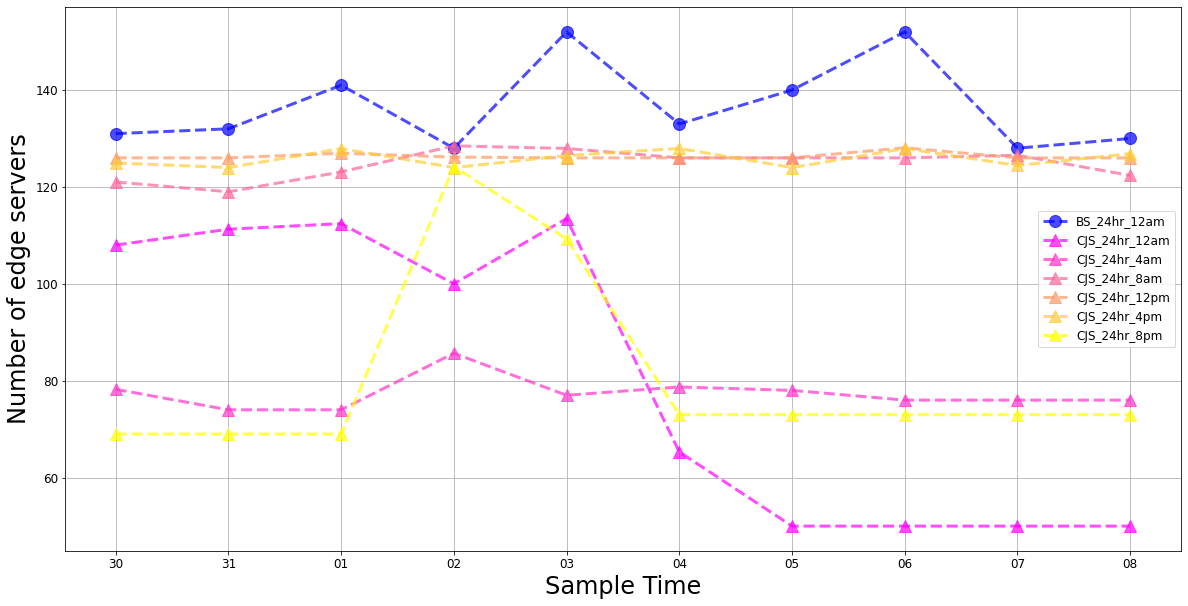

In [226]:
#CJS 24hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = ['30', '31', '01', '02', '03', '04', '05', '06', '07', '08']
# x_axis1 = [6*d for d in range(14)]
# x_axis2 = [6*d+1 for d in range(14)]
# x_axis3 = [6*d+2 for d in range(14)]
# x_axis4 = [6*d+3 for d in range(14)]
# x_axis5 = [6*d+4 for d in range(14)]
# x_axis6 = [6*d+5 for d in range(14)]
color_idx = np.linspace(0, 1, 6)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(x_axis, BS_24hr_12am[2:-2], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)


plt.plot(x_axis, estimate_N_24hr_12am_1hr[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_24hr_12am', alpha=0.7)
plt.plot(x_axis, estimate_N_24hr_4am[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_24hr_4am', alpha=0.7)
plt.plot(x_axis, estimate_N_24hr_8am[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_24hr_8am', alpha=0.7)
plt.plot(x_axis, estimate_N_24hr_12pm_1hr[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_24hr_12pm', alpha=0.7)
plt.plot(x_axis, estimate_N_24hr_4pm[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_24hr_4pm', alpha=0.7)
plt.plot(x_axis, estimate_N_24hr_8pm[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_24hr_8pm', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

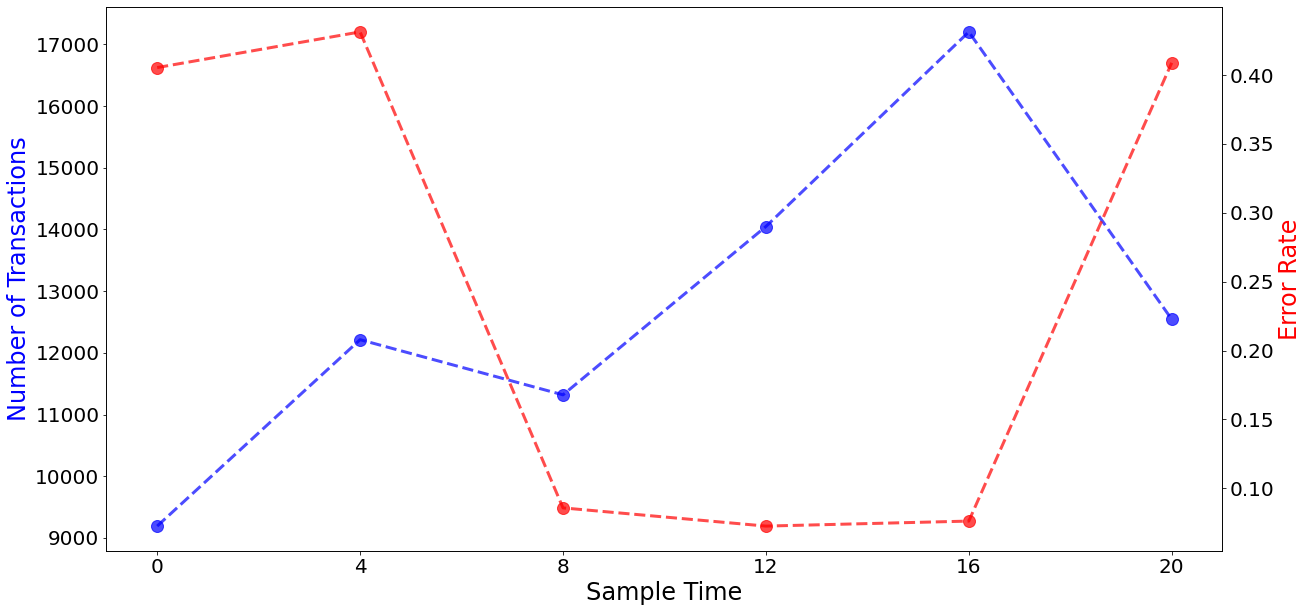

In [238]:
# transactions and error rate
fig, ax1 = plt.subplots(figsize=(20, 10))
x_axis = ['0', '4', '8', '12', '16', '20']
ax1.set_xlabel('Sample Time', fontsize=24)
ax1.set_ylabel('Number of Transactions', color='b', fontsize=24)
C_tran_table_24hr = np.zeros((6,))
C_tran_table_24hr[0] = np.mean(C_tran_24hr_12am_1hr[2:-2])
C_tran_table_24hr[1] = np.mean(C_tran_24hr_4am[2:-2])
C_tran_table_24hr[2] = np.mean(C_tran_24hr_8am[2:-2])
C_tran_table_24hr[3] = np.mean(C_tran_24hr_12pm_1hr[2:-2])
C_tran_table_24hr[4] = np.mean(C_tran_24hr_4pm[2:-2])
C_tran_table_24hr[5] = np.mean(C_tran_24hr_8pm[2:-2])

ax1.plot(x_axis, C_tran_table_24hr, "o--", markersize=12, linewidth=3, color='b', alpha=0.7)

# leg.set_title('Sampling Duration',prop={'size':20})

ax1.tick_params(axis='both', which='major', labelsize=20)

err_rate_24hr = np.zeros((6,))
err_rate_24hr[0] = np.sqrt(np.mean(np.abs(estimate_N_24hr_12am_1hr[2:-2] - BS_24hr_12am[2:-2])/BS_24hr_12am[2:-2])**2)
err_rate_24hr[1] = np.sqrt(np.mean(np.abs(estimate_N_24hr_4am[2:-2] - BS_24hr_12am[2:-2])/BS_24hr_12am[2:-2])**2)
err_rate_24hr[2] = np.sqrt(np.mean(np.abs(estimate_N_24hr_8am[2:-2] - BS_24hr_12am[2:-2])/BS_24hr_12am[2:-2])**2)
err_rate_24hr[3] = np.sqrt(np.mean(np.abs(estimate_N_24hr_12pm_1hr[2:-2] - BS_24hr_12am[2:-2])/BS_24hr_12am[2:-2])**2)
err_rate_24hr[4] = np.sqrt(np.mean(np.abs(estimate_N_24hr_4pm[2:-2] - BS_24hr_12am[2:-2])/BS_24hr_12am[2:-2])**2)
err_rate_24hr[5] = np.sqrt(np.mean(np.abs(estimate_N_24hr_8pm[2:-2] - BS_24hr_12am[2:-2])/BS_24hr_12am[2:-2])**2)

ax2 = ax1.twinx()
ax2.set_ylabel('Error Rate', color='r', fontsize=24)  # we already handled the x-label with ax1
ax2.plot(x_axis, err_rate_24hr, "o--", markersize=12, linewidth=3, color='r', alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=20)

plt.show()

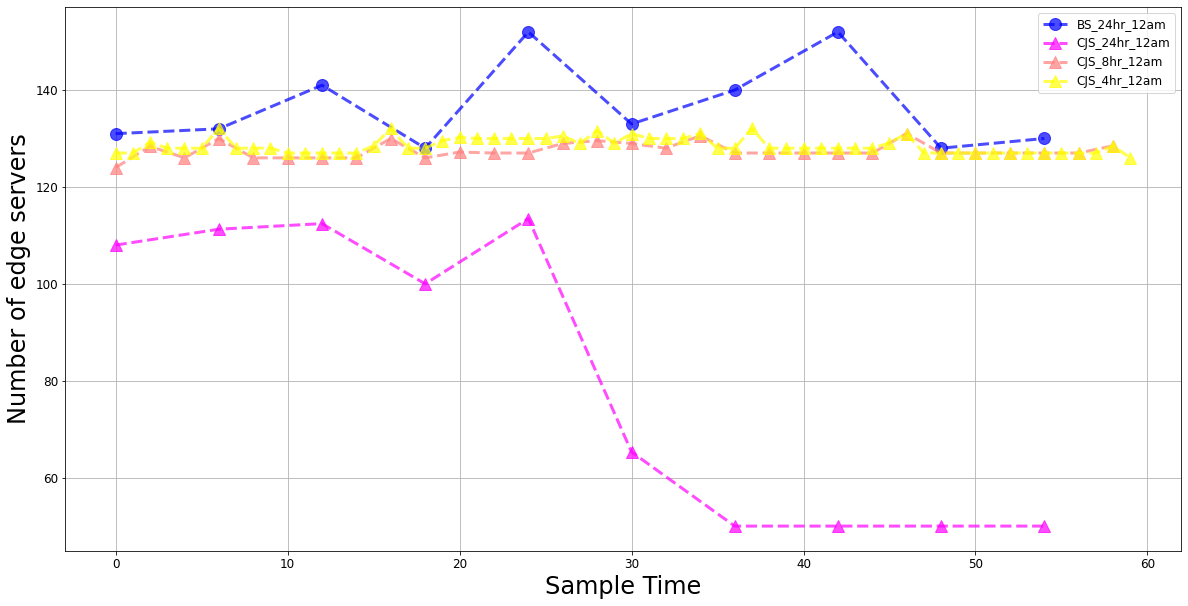

In [241]:
# CJS 12 am / 1 hr / 24 hr or 8 hr or 4 hr 
fig, ax = plt.subplots(figsize=(20, 10))
date = ['30', '31', '01', '02', '03', '04', '05', '06', '07', '08']
x_axis1 = [6*d for d in range(10)]
x_axis2 = [2*d for d in range(10*3)]
x_axis3 = [d for d in range(10*6)]
color_idx = np.linspace(0, 1, 3)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)
plt.plot(x_axis1, BS_24hr_12am[2:-2], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_24hr_12am_1hr[2:-2], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_24hr_12am', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_12am_60min[6:-6], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_12am', alpha=0.7)
plt.plot(x_axis3, estimate_N_4hr_12am_60min[12:-12], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_12am', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

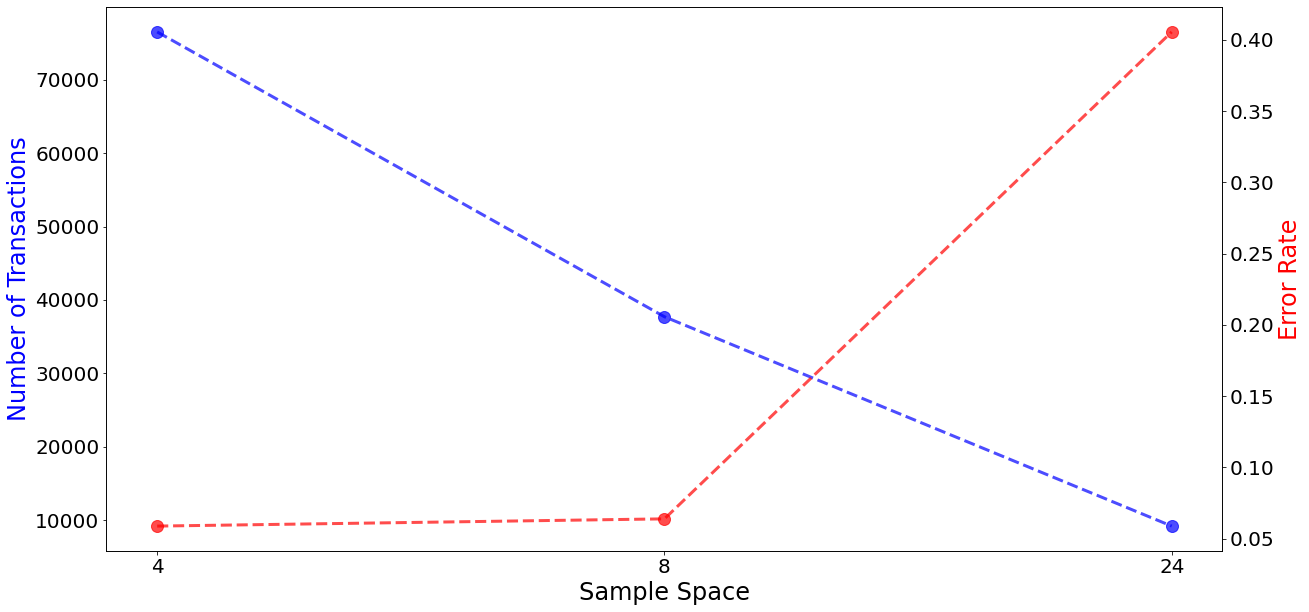

In [245]:
# transactions and error rate
fig, ax1 = plt.subplots(figsize=(20, 10))
x_axis = ['4', '8', '24']
ax1.set_xlabel('Sample Space', fontsize=24)
ax1.set_ylabel('Number of Transactions', color='b', fontsize=24)
C_tran_table_24hr = np.zeros((3,))
C_tran_table_24hr[2] = np.mean(C_tran_24hr_12am_1hr[2:-2])
C_tran_table_24hr[1] = np.mean(C_tran_8hr_12am_60min[6:-6])*3
C_tran_table_24hr[0] = np.mean(C_tran_4hr_12am_60min[12:-12])*6

ax1.plot(x_axis, C_tran_table_24hr, "o--", markersize=12, linewidth=3, color='b', alpha=0.7)

# leg.set_title('Sampling Duration',prop={'size':20})

ax1.tick_params(axis='both', which='major', labelsize=20)

err_rate_24hr = np.zeros((3,))
err_rate_24hr[2] = np.sqrt(np.mean(np.abs(estimate_N_24hr_12am_1hr[2:-2] - BS_24hr_12am[2:-2])/BS_24hr_12am[2:-2])**2)
err_rate_24hr[1] = np.sqrt(np.mean(np.abs(estimate_N_8hr_12am_60min[6:-6] - np.repeat(BS_24hr_12am[2:-2], 3))/np.repeat(BS_24hr_12am[2:-2], 3))**2)
err_rate_24hr[0] = np.sqrt(np.mean(np.abs(estimate_N_4hr_12am_60min[12:-12] - np.repeat(BS_24hr_12am[2:-2], 6))/np.repeat(BS_24hr_12am[2:-2], 6))**2)

ax2 = ax1.twinx()
ax2.set_ylabel('Error Rate', color='r', fontsize=24)  # we already handled the x-label with ax1
ax2.plot(x_axis, err_rate_24hr, "o--", markersize=12, linewidth=3, color='r', alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=20)

plt.show()

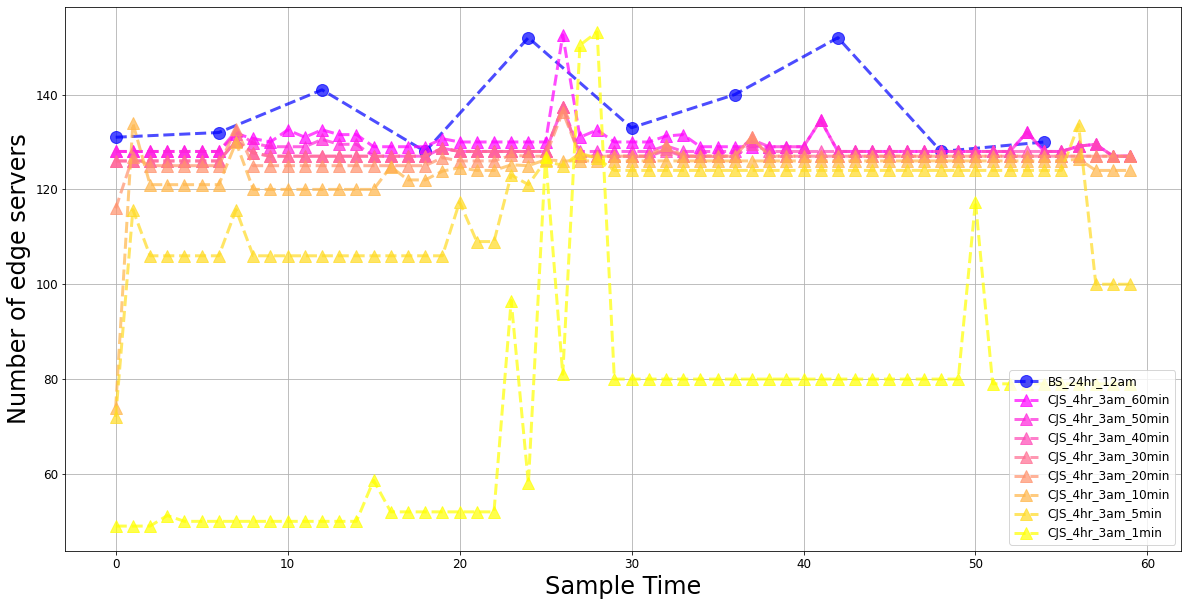

In [277]:
#CJS 4hr 3am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [6*d for d in range(10)]
x_axis1 = [d for d in range(10*6)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am[2:-2], "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_3am_60min[12:-12], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_4hr_3am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_50min[12:-12], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_4hr_3am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_40min[12:-12], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_3am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_30min[12:-12], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_3am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_20min[12:-12], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_4hr_3am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_10min[12:-12], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_4hr_3am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_5min[12:-12], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_4hr_3am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_1min[12:-12], "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_4hr_3am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12, loc=4)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

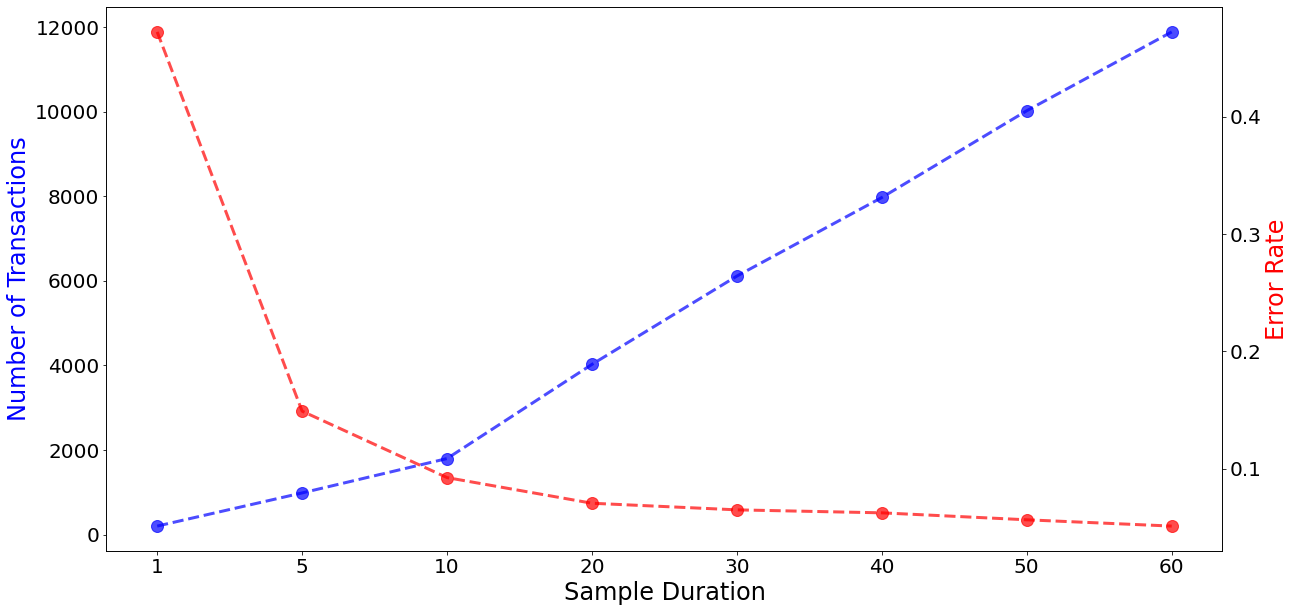

In [275]:
# transactions and error rate
fig, ax1 = plt.subplots(figsize=(20, 10))
x_axis = ['1', '5', '10', '20', '30', '40', '50', '60']
ax1.set_xlabel('Sample Duration', fontsize=24)
ax1.set_ylabel('Number of Transactions', color='b', fontsize=24)
C_tran_table = np.zeros((8,))
C_tran_table[7] = np.mean(C_tran_4hr_3am_60min[12:-12])
C_tran_table[6] = np.mean(C_tran_4hr_3am_50min[12:-12])
C_tran_table[5] = np.mean(C_tran_4hr_3am_40min[12:-12])
C_tran_table[4] = np.mean(C_tran_4hr_3am_30min[12:-12])
C_tran_table[3] = np.mean(C_tran_4hr_3am_20min[12:-12])
C_tran_table[2] = np.mean(C_tran_4hr_3am_10min[12:-12])
C_tran_table[1] = np.mean(C_tran_4hr_3am_5min[12:-12])
C_tran_table[0] = np.mean(C_tran_4hr_3am_1min[12:-12])

ax1.plot(x_axis, C_tran_table, "o--", markersize=12, linewidth=3, color='b', alpha=0.7)

# leg.set_title('Sampling Duration',prop={'size':20})

ax1.tick_params(axis='both', which='major', labelsize=20)

err_rate = np.zeros((8,))
err_rate[7] = np.sqrt(np.mean(np.abs(estimate_N_4hr_3am_60min[12:-12] - np.repeat(BS_24hr_12am[2:-2], 6))/np.repeat(BS_24hr_12am[2:-2], 6))**2)
err_rate[6] = np.sqrt(np.mean(np.abs(estimate_N_4hr_3am_50min[12:-12] - np.repeat(BS_24hr_12am[2:-2], 6))/np.repeat(BS_24hr_12am[2:-2], 6))**2)
err_rate[5] = np.sqrt(np.mean(np.abs(estimate_N_4hr_3am_40min[12:-12] - np.repeat(BS_24hr_12am[2:-2], 6))/np.repeat(BS_24hr_12am[2:-2], 6))**2)
err_rate[4] = np.sqrt(np.mean(np.abs(estimate_N_4hr_3am_30min[12:-12] - np.repeat(BS_24hr_12am[2:-2], 6))/np.repeat(BS_24hr_12am[2:-2], 6))**2)
err_rate[3] = np.sqrt(np.mean(np.abs(estimate_N_4hr_3am_20min[12:-12] - np.repeat(BS_24hr_12am[2:-2], 6))/np.repeat(BS_24hr_12am[2:-2], 6))**2)
err_rate[2] = np.sqrt(np.mean(np.abs(estimate_N_4hr_3am_10min[12:-12] - np.repeat(BS_24hr_12am[2:-2], 6))/np.repeat(BS_24hr_12am[2:-2], 6))**2)
err_rate[1] = np.sqrt(np.mean(np.abs(estimate_N_4hr_3am_5min[12:-12] - np.repeat(BS_24hr_12am[2:-2], 6))/np.repeat(BS_24hr_12am[2:-2], 6))**2)
err_rate[0] = np.sqrt(np.mean(np.abs(estimate_N_4hr_3am_1min[12:-12] - np.repeat(BS_24hr_12am[2:-2], 6))/np.repeat(BS_24hr_12am[2:-2], 6))**2)

ax2 = ax1.twinx()
ax2.set_ylabel('Error Rate', color='r', fontsize=24)  # we already handled the x-label with ax1
ax2.plot(x_axis, err_rate, "o--", markersize=12, linewidth=3, color='r', alpha=0.7)
ax2.tick_params(axis='both', which='major', labelsize=20)

plt.show()

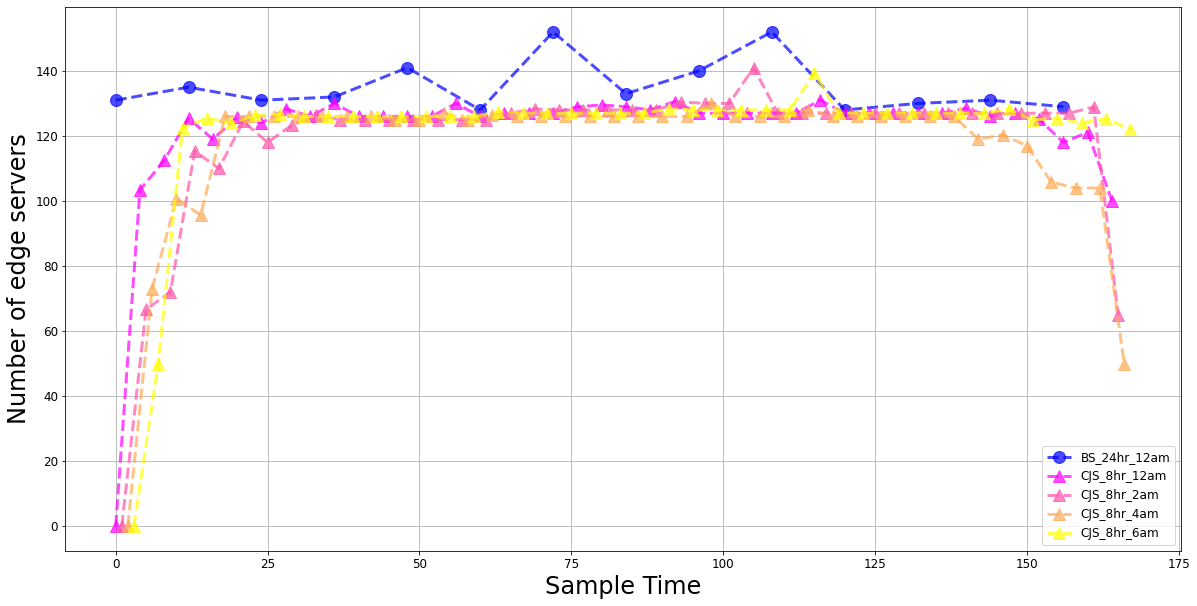

In [162]:
#CJS 8hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [12*d for d in range(14)]
x_axis1 = [4*d for d in range(14*3)]
x_axis2 = [4*d+1 for d in range(14*3)]
x_axis3 = [4*d+2 for d in range(14*3)]
x_axis4 = [4*d+3 for d in range(14*3)]
color_idx = np.linspace(0, 1, 4)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_8hr_12am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_8hr_12am', alpha=0.7)
plt.plot(x_axis2, estimate_N_8hr_2am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_2am', alpha=0.7)
plt.plot(x_axis3, estimate_N_8hr_4am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_8hr_4am', alpha=0.7)
plt.plot(x_axis4, estimate_N_8hr_6am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_8hr_6am', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

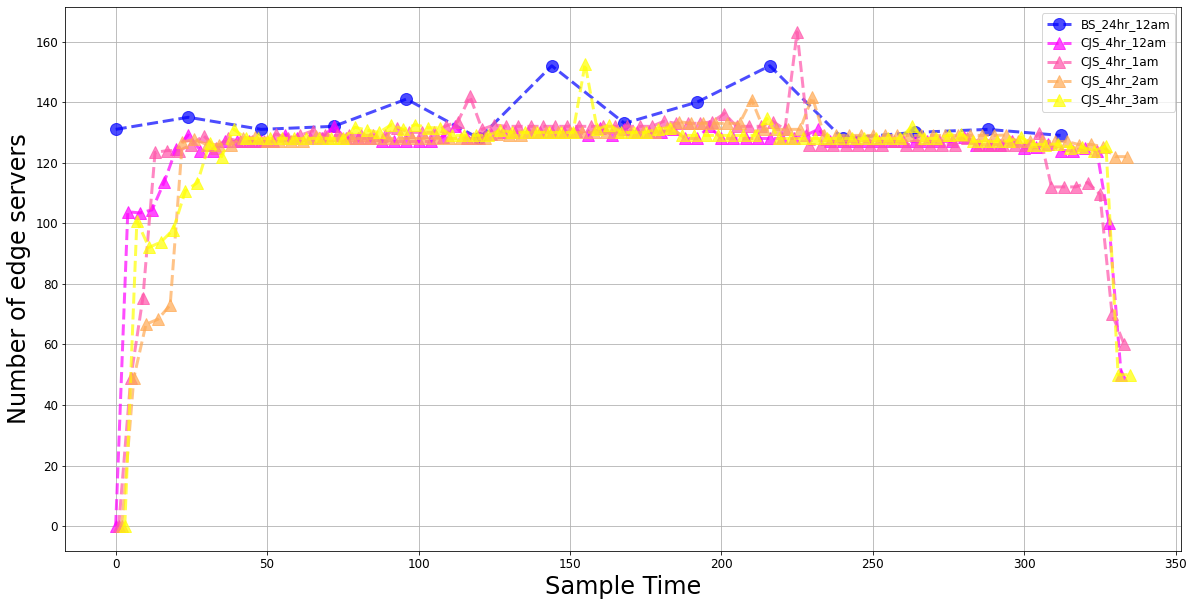

In [163]:
#CJS 4hr
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [24*d for d in range(14)]
x_axis1 = [4*d for d in range(14*6)]
x_axis2 = [4*d+1 for d in range(14*6)]
x_axis3 = [4*d+2 for d in range(14*6)]
x_axis4 = [4*d+3 for d in range(14*6)]
color_idx = np.linspace(0, 1, 4)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_12am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_4hr_12am', alpha=0.7)
plt.plot(x_axis2, estimate_N_4hr_1am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_4hr_1am', alpha=0.7)
plt.plot(x_axis3, estimate_N_4hr_2am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_2am', alpha=0.7)
plt.plot(x_axis4, estimate_N_4hr_3am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_3am', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

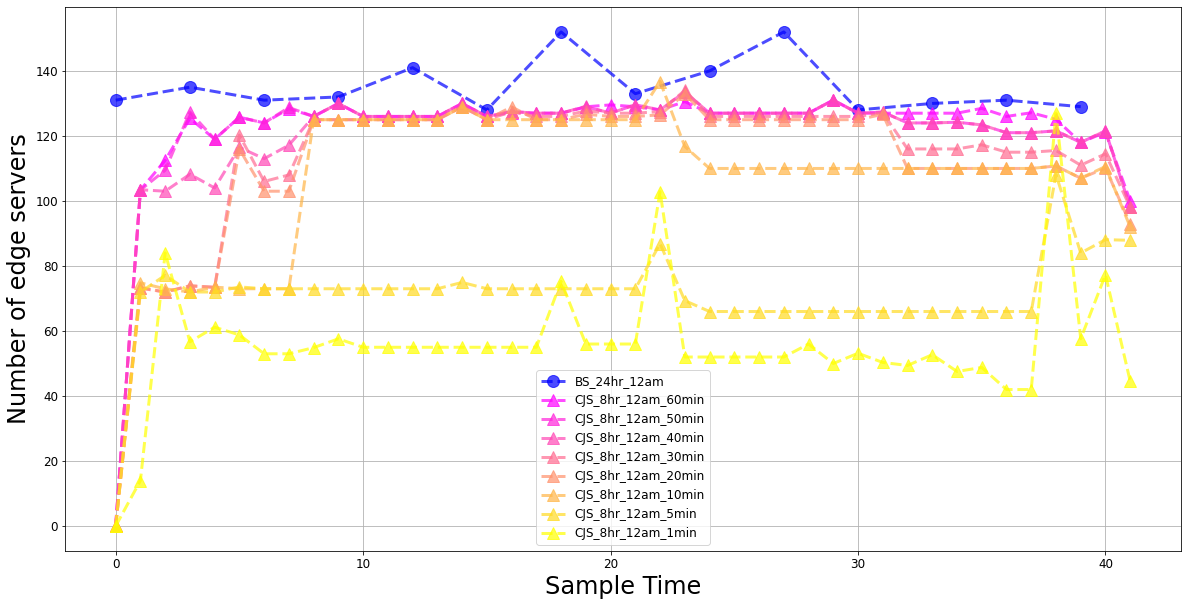

In [164]:
#CJS 8hr 12am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [3*d for d in range(14)]
x_axis1 = [d for d in range(14*3)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_8hr_12am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_8hr_12am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_12am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_8hr_12am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_8hr_12am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_8hr_12am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_8hr_12am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_8hr_12am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_12am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_8hr_12am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

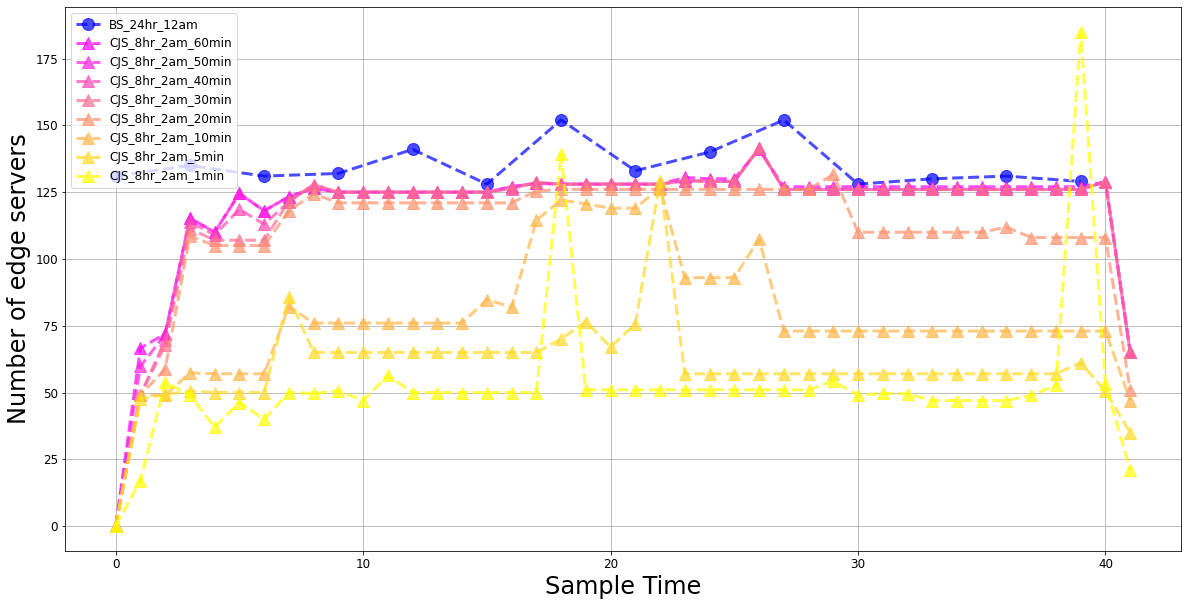

In [165]:
#CJS 8hr 2am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [3*d for d in range(14)]
x_axis1 = [d for d in range(14*3)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_8hr_2am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_8hr_2am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_2am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_8hr_2am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_8hr_2am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_8hr_2am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_8hr_2am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_8hr_2am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_2am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_8hr_2am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

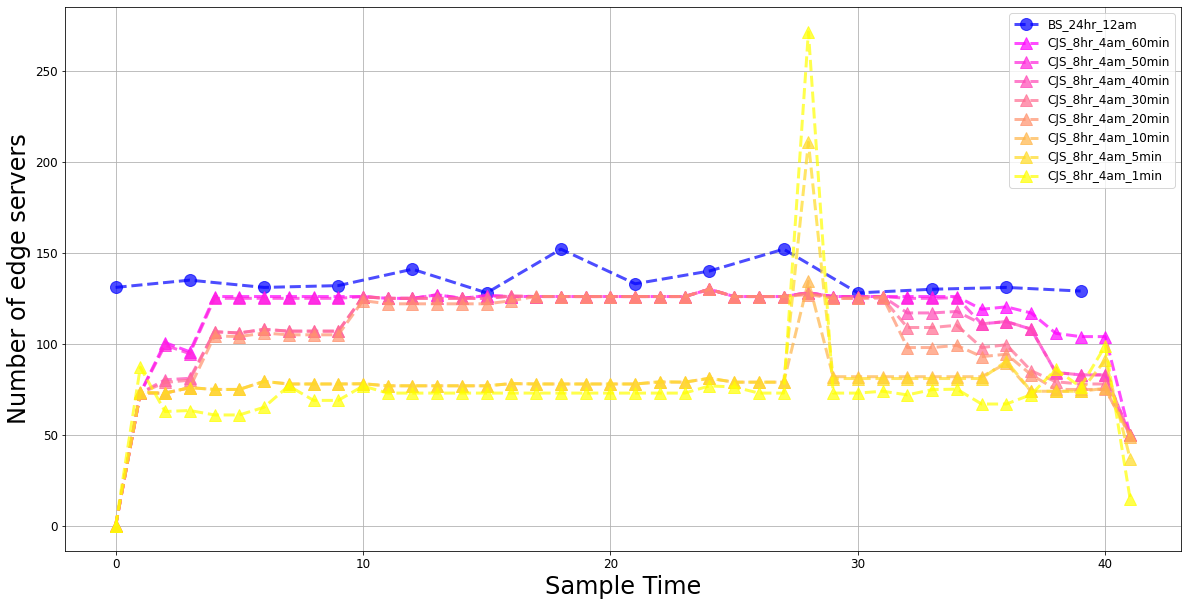

In [166]:
#CJS 8hr 4am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [3*d for d in range(14)]
x_axis1 = [d for d in range(14*3)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_8hr_4am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_8hr_4am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_4am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_8hr_4am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_8hr_4am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_8hr_4am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_8hr_4am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_8hr_4am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_4am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_8hr_4am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

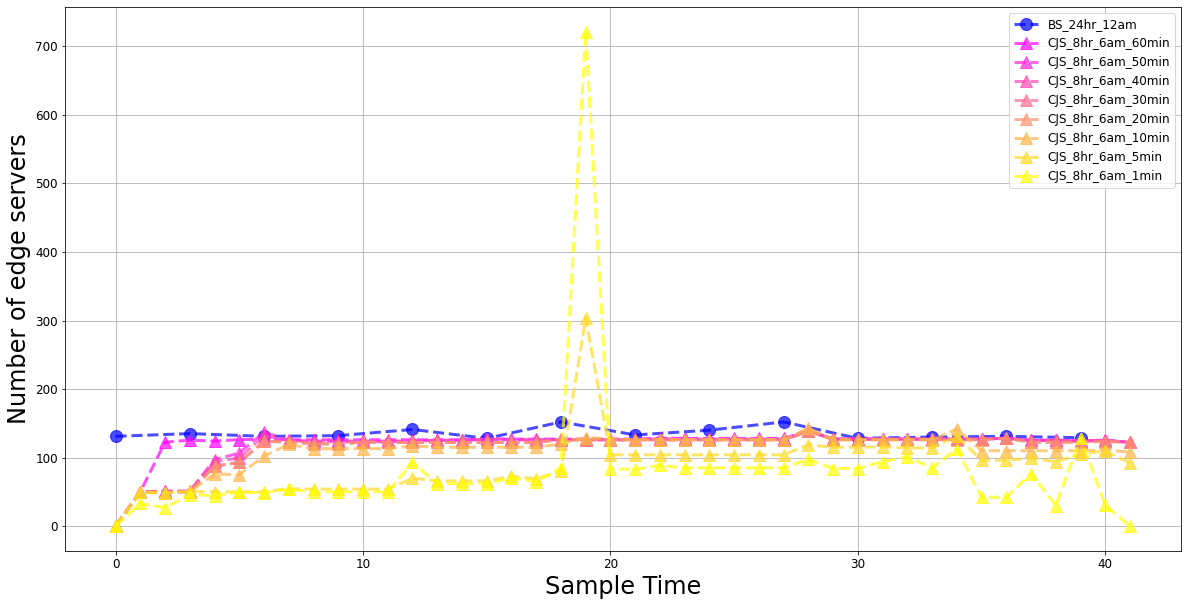

In [167]:
#CJS 8hr 6am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [3*d for d in range(14)]
x_axis1 = [d for d in range(14*3)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_8hr_6am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_8hr_6am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_8hr_6am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_8hr_6am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_8hr_6am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_8hr_6am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_8hr_6am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_8hr_6am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_8hr_6am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_8hr_6am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

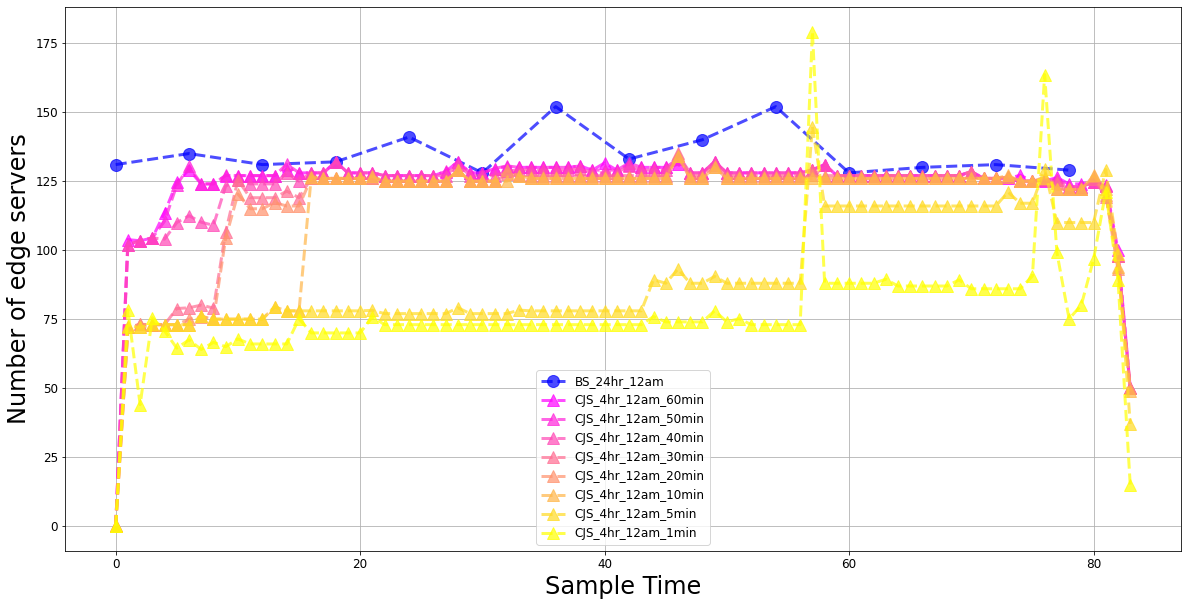

In [168]:
#CJS 4hr 12am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [6*d for d in range(14)]
x_axis1 = [d for d in range(14*6)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_12am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_4hr_12am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_4hr_12am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_12am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_12am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_4hr_12am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_4hr_12am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_4hr_12am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_12am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_4hr_12am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

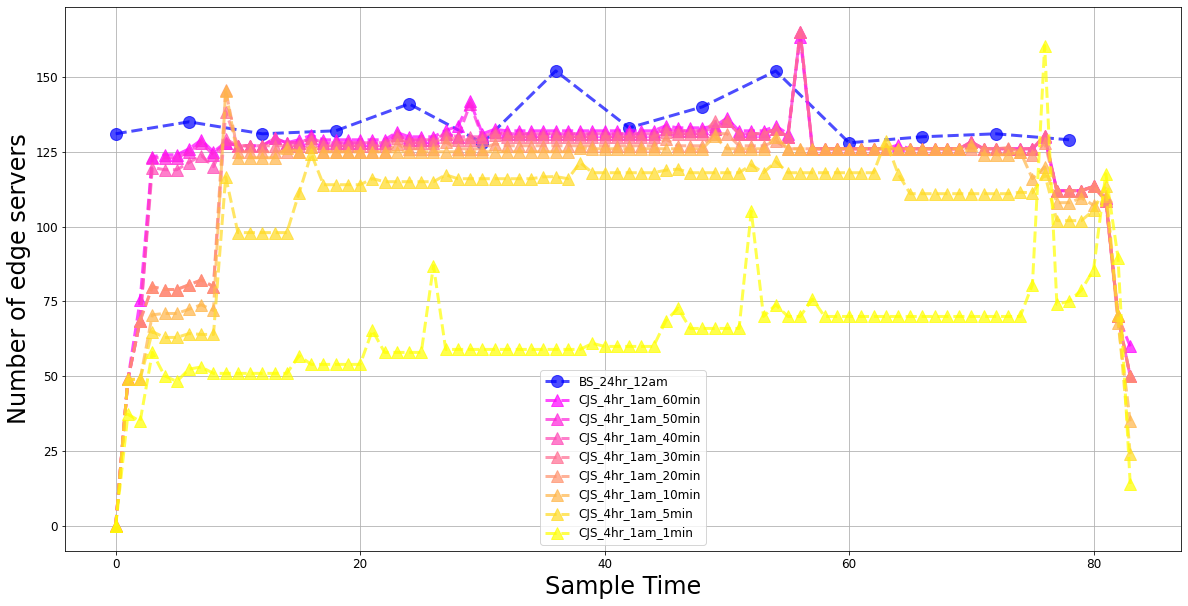

In [169]:
#CJS 4hr 1am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [6*d for d in range(14)]
x_axis1 = [d for d in range(14*6)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_1am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_4hr_1am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_4hr_1am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_1am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_1am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_4hr_1am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_4hr_1am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_4hr_1am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_1am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_4hr_1am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

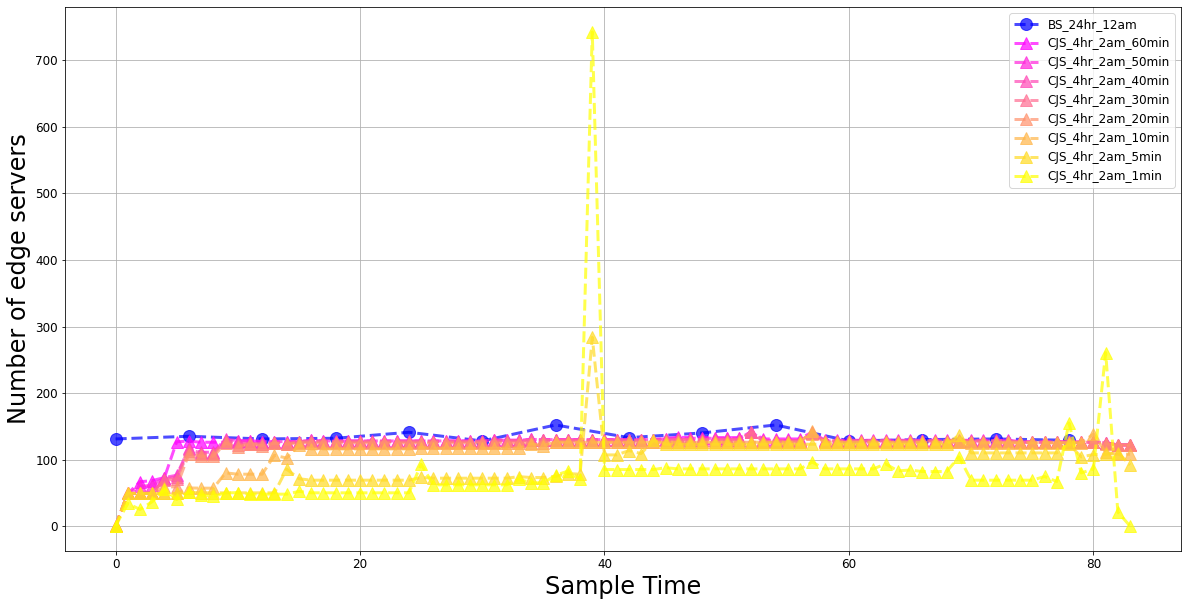

In [170]:
#CJS 4hr 2am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [6*d for d in range(14)]
x_axis1 = [d for d in range(14*6)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_2am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_4hr_2am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_4hr_2am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_2am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_2am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_4hr_2am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_4hr_2am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_4hr_2am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_2am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_4hr_2am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

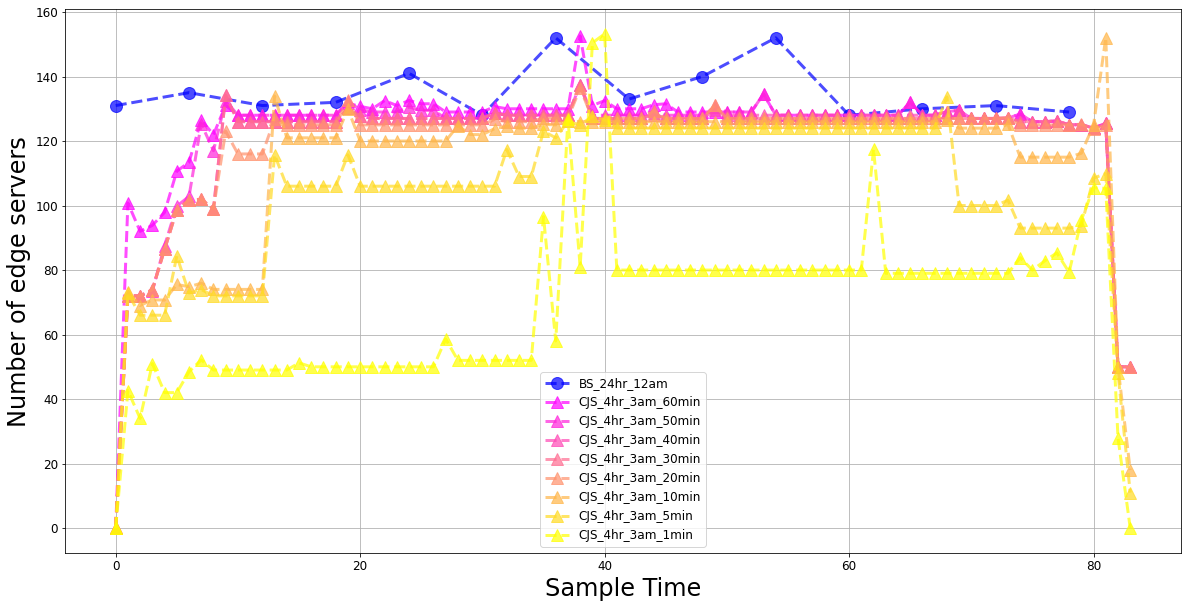

In [271]:
#CJS 4hr 3am
fig, ax = plt.subplots(figsize=(20, 10))
x_axis = [6*d for d in range(14)]
x_axis1 = [d for d in range(14*6)]

color_idx = np.linspace(0, 1, 8)
ax.set_xlabel('Sample Time', fontsize=24)
ax.set_ylabel('Number of edge servers', fontsize=24)

plt.plot(x_axis, BS_24hr_12am, "o--", markersize=12, linewidth=3, color=plt.cm.winter(color_idx[0]), label='BS_24hr_12am', alpha=0.7)

plt.plot(x_axis1, estimate_N_4hr_3am_60min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[0]), label='CJS_4hr_3am_60min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_50min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[1]), label='CJS_4hr_3am_50min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_40min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[2]), label='CJS_4hr_3am_40min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_30min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[3]), label='CJS_4hr_3am_30min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_20min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[4]), label='CJS_4hr_3am_20min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_10min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[5]), label='CJS_4hr_3am_10min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_5min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[6]), label='CJS_4hr_3am_5min', alpha=0.7)
plt.plot(x_axis1, estimate_N_4hr_3am_1min, "^--", markersize=12, linewidth=3, color=plt.cm.spring(color_idx[7]), label='CJS_4hr_3am_1min', alpha=0.7)

ax.grid()
leg = ax.legend(fontsize=12)
# leg.set_title('Sampling Duration',prop={'size':20})

ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

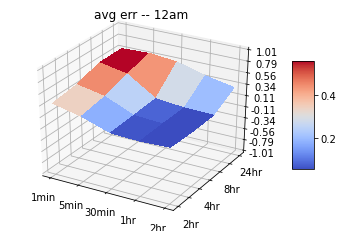

In [356]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.array([0, 1, 2, 3, 4])
Y = np.array([0, 1, 2, 3])
X, Y = np.meshgrid(X, Y)
# print(X)
# print(Y)
# print(error_rate_avg_12am.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, error_rate_avg_12am, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xticklabels(['', '1min', '5min', '30min', '1hr', '2hr'])
ax.set_yticklabels(['', '2hr', '', '4hr', '', '8hr', '', '24hr'])
ax.set_title("avg err -- 12am")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

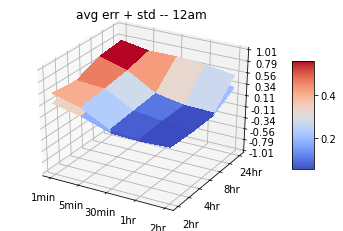

In [357]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.array([0, 1, 2, 3, 4])
Y = np.array([0, 1, 2, 3])
X, Y = np.meshgrid(X, Y)
# print(X)
# print(Y)
# print(error_rate_avg_12am.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, error_rate_avg_12am + error_rate_std_12am, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf = ax.plot_surface(X, Y, error_rate_avg_12am, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xticklabels(['', '1min', '5min', '30min', '1hr', '2hr'])
ax.set_yticklabels(['', '2hr', '', '4hr', '', '8hr', '', '24hr'])
ax.set_title("avg err + std -- 12am")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

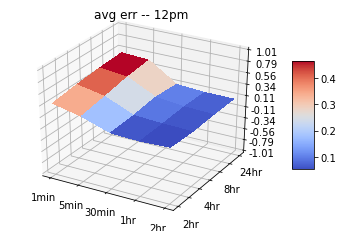

In [358]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.array([0, 1, 2, 3, 4])
Y = np.array([0, 1, 2, 3])
X, Y = np.meshgrid(X, Y)
# print(X)
# print(Y)
# print(error_rate_avg_12am.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, error_rate_avg_12pm, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xticklabels(['', '1min', '5min', '30min', '1hr', '2hr'])
ax.set_yticklabels(['', '2hr', '', '4hr', '', '8hr', '', '24hr'])
ax.set_title("avg err -- 12pm")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

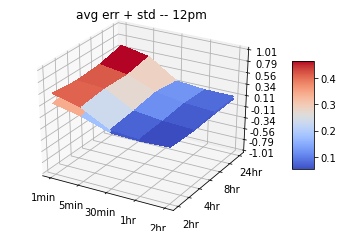

In [359]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.array([0, 1, 2, 3, 4])
Y = np.array([0, 1, 2, 3])
X, Y = np.meshgrid(X, Y)
# print(X)
# print(Y)
# print(error_rate_avg_12am.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, error_rate_avg_12pm + error_rate_std_12pm, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
surf = ax.plot_surface(X, Y, error_rate_avg_12pm, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xticklabels(['', '1min', '5min', '30min', '1hr', '2hr'])
ax.set_yticklabels(['', '2hr', '', '4hr', '', '8hr', '', '24hr'])
ax.set_title("avg err + std -- 12pm")


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [313]:
print(error_rate_avg_12am)
print(error_rate_std_12am)
print(error_rate_avg_12pm)
print(error_rate_std_12pm)

[[0.36743839 0.24621109 0.06165547 0.04113952 0.06588765]
 [0.43007837 0.32623196 0.08663453 0.05752873 0.04218574]
 [0.57808441 0.47209643 0.1149862  0.06347418 0.05042935]
 [0.58515917 0.60909722 0.55608618 0.40550324 0.29674945]]
[[0.19119541 0.17053482 0.06218337 0.04386424 0.04899264]
 [0.08081887 0.14599297 0.08695114 0.04904398 0.03622883]
 [0.11724517 0.06680818 0.09851867 0.05165655 0.04618773]
 [0.16360176 0.04512721 0.10184841 0.20903678 0.23961032]]
[[0.36743839 0.24621109 0.06165547 0.04113952 0.06588765]
 [0.43007837 0.32623196 0.08663453 0.05752873 0.04218574]
 [0.4753174  0.41729867 0.14560073 0.08523024 0.06290409]
 [0.50242851 0.47182658 0.10829144 0.07250395 0.07034315]]
[[0.19119541 0.17053482 0.06218337 0.04386424 0.04899264]
 [0.08081887 0.14599297 0.08695114 0.04904398 0.03622883]
 [0.06823002 0.0396337  0.09807384 0.06437682 0.05225091]
 [0.14689716 0.07208281 0.06931775 0.05390804 0.05436843]]
